Integrantes:

Thiare Guerrero 

Felipe Villa 

Valentin Lara

Sebastian Celedon

Bastian Antil

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np 
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_curve,auc, roc_auc_score
from sklearn.model_selection import train_test_split



FUNCIONES NECESARIAS PARA EL DESARROLLO DEL CODIGO

In [2]:
def load_dataset(): # funcion para obtener el data set 
    transform = transforms.Compose([transforms.ToTensor()]) # transformo los datos auna variable pytorch
    #cargo los datos y aplico transformacion
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True) # DATA DE ENTRENAMIENTO 
    test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True) # DATA DE TEST

    # one hot encoding
    trainY = train_dataset.targets # ETIQUETAS DE LA DATA DE ENTRENAMIENTO 
    testY = test_dataset.targets   # ETIQUETAS DE LA DATA DE TEST 

    # LOS SIGUIENTES PRINT PARA VERIFICAR LA DIMENSION DE CADA BASE DE DATOS 

    print("Dimensiones de trainX:", train_dataset.data.unsqueeze(1).float().shape)
    print("Dimensiones de trainY:", trainY.shape)
    print("Dimensiones de testX:", test_dataset.data.unsqueeze(1).float().shape)
    print("Dimensiones de testY:", testY.shape)






    # train_dataset.data.unsqueeze(1).float() -> DATA TRAIN 
    # test_dataset.data.unsqueeze(1).float() -> DATA TEST 
    return train_dataset.data.unsqueeze(1).float(), trainY, test_dataset.data.unsqueeze(1).float(), testY


def train(model, train_loader, criterion, optimizer): # funcion para entrenar el modelo 
    model.train() # modo train 
    running_loss = 0.0 # variable para obtener los valores de los errores
    correct_predictions=0
    total_samples=0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda') # variables necesarias para trabajar en la gpu 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return running_loss / len(train_loader), correct_predictions / total_samples # retorna el error de los train y el accuracy de los train


def evaluate(model, test_loader, criterion): # funcion para evaluar el modelo en data test 
    model.eval() # modo testeo 
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader: # recorro las imagenes y labels en el dataset 
            inputs, labels = inputs.to('cuda'), labels.to('cuda') # variables a la gpu 
            outputs = model(inputs) # Ejecuto el modelo con las variables de entrada
            loss = criterion(outputs, labels) # obtengo el error 
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # en esta parte se predice el resultado 
            total += labels.size(0)
            correct += (predicted == labels).sum().item() # con esta variable podemos calcular las predicciones correctas 
    accuracy = correct / total
    
    return running_loss / len(test_loader), accuracy # retorna el error y el accuracy 


def predict(model, data_loader):
    model.eval()  # Cambia el modo del modelo a evaluación
    
    predictions = []  # Almacenar las predicciones
    
    with torch.no_grad():
        for inputs,labels in data_loader: 
            inputs = inputs.to('cuda') # importante declarar para que no de errores 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Obtener la clase con la probabilidad más alta
            predictions.extend(predicted.cpu().numpy())  # Agregar predicciones a la lista

    model.train()  # Volver al modo de entrenamiento
    
    return predictions



# la intencion de esta clase es proporcionar una interfaz para acceder
# a los datos y etiquetas de manera eficiente 
class CustomDataset(Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data # imagenes
        self.labels = labels # etiquetas
        self.transforms = transforms # utilizado para hacerle transformaciones a los datos 

    def __len__(self):
        return len(self.data) # retorna la longitud del dataset 

    def __getitem__(self, idx): # este metodo es para obtener una muestra del dataset 
        sample = self.data[idx] # idx -> indice de la muestra que se quiere obtener 

        if self.transforms:
            sample = self.transforms(sample)

        label = self.labels[idx]

        return sample, label

In [3]:
class Red(nn.Module):
    def __init__(self):
        super(Red, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)   #creamos capas convolucionales 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 3 * 3, 100)  #creamos las capas completamente conectadas 
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # se aplica una funcion de activacion relu en las capas de convolucion 
        x = F.relu(F.max_pool2d(self.conv2(x), 2)) # seguido un maxpooling con kernel 2x2
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # se aplica un softmax para obtener la probabilidad 


    # funcion auxiliar que ayuda a determinar el tamaño correcto de la capa de entrada 
    # de las capas completamente conectadas en la arquitectura de la red 
    def num_flat_features(self, x):
        size = x.size()[1:]  # Todas las dimensiones excepto la del batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [16]:
def train_model_kfold(trainx, trainy,patience=4,n_folds=5):
    scores, histories, recalls = list(), list(), list()
    
    batch_size = 32
    learning_rate = 0.0001
    num_epochs = 10
   
    # objeto para dividir los datos en n pliegues 
    kfold = KFold(n_splits=n_folds, shuffle=True)

    # itera a través de los pliegues de validación cruzada
    for fold, (train_indices, test_indices) in enumerate(kfold.split(trainx)):
        print(f"Fold {fold + 1}/{n_folds}")
        
        # aqui se divide los datos en conjuntos de entrenamiento y prueba para el fold respectivo 
        train_data, test_data = trainx[train_indices], trainx[test_indices]
        train_labels, test_labels = trainy[train_indices], trainy[test_indices]

        # Crea dataloaders para entrenamiento y prueba para el fold respectivo 
        train_loader = torch.utils.data.DataLoader(dataset=CustomDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=CustomDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

        # Inicializa el modelo y el optimizador
        model = Red().to('cuda') # modelo en la gpu 
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        aux1 = [] # lista para obtener los errores del train
        aux2 = [] # lista para obtener los errores del test 

        aux3 = [] # lista para obtener accuracy del data train 
        aux4 = [] # lista para obtener accuracy del data test 

        best_val_loss=2
        # Entrena el modelo
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train(model, train_loader, criterion, optimizer) # en este momento se entrena el modelo por epocas 
            aux1.append(train_loss) # lista de errores en data train
            aux3.append(train_accuracy) # lista de accuracy en data train
            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

            # Evalúa el modelo en el conjunto de prueba
            test_loss, test_accuracy = evaluate(model, test_loader, criterion)# se llama a la funcion para evaluar el modelo y obtener el error y accuracy por epocas
            print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2%}\n")
            aux2.append(test_loss) # lista para obtener los errores del data test 
            
            aux4.append(test_accuracy) # lista de accuracy en data test 
            
            #implemento early stopping 
            if test_loss < best_val_loss: #comparacion simple de variables
                best_val_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                
            if no_improvement_count >= patience:
                print(f"Early stopping en fold {fold + 1}, epoch {epoch + 1}")
                break
        
        y_true = test_labels # variables true reales 
        y_pred = predict(model, test_loader)   # prediccion del modelo         
        report = classification_report(y_true, y_pred, output_dict=True)
        #Calcular y mostrar el recall
        print(f'Recall - Fold {fold + 1}:')
        for class_name, recall_value in report.items(): # itero la variable de recall en report.items()
            if class_name.isdigit():
                print(f'Class {class_name}: Recall = {recall_value["recall"]:.4f}')

        # calcular y mostrar valores F1 
        print(f'Valor F1 - Fold {fold + 1}:')
        for class_name, f1_value in report.items():
            if class_name.isdigit():
                print(f'Class {class_name}: F1-Score = {f1_value["f1-score"]:.4f}')

        
     

       
        recalls.append(report)  # Almacena el reporte de clasificación
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = None)
        cm_display.plot()
        plt.show()

        visualization_curves(aux1,aux3,aux2,aux4,fold)  

        print("MODELO TERMINADO!!!!")
        print('------------------')
        
      
       
    
    return aux1,aux3,aux2,aux4 # loss-train, accuracy-train, loss-test, accuracy-test


In [3]:
def visualization_curves(trainn_loss,trainn_accuracy,testt_loss, testt_accuracy,fold):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(trainn_loss, label='Train Loss') #error en train 
    plt.plot(testt_loss, label='Test Loss') # error en data test 
    plt.title(f'Fold {fold + 1} - Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 2, 2)
    plt.plot(trainn_accuracy, label='Train Accuracy') # precision en train 
    plt.plot(testt_accuracy, label='Test Accuracy') # accuracy en data test 
    plt.title(f'Fold {fold + 1} - Accuracy') # accuracy 
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [8]:
trainx, trainy, testx, testy = load_dataset() # cargo los datos 
print("...Dataset cargado")

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])
...Dataset cargado


Se aplica una normalizacion entre [0,1]

In [8]:
def pixelsceroyuno(train, test): # funcion para normalizar los datos en [0,1]

 train_norm = train / 255.0
 test_norm = test / 255.0

 # return normalized images
 return train_norm, test_norm

In [9]:
train_norm, test_norm = pixelsceroyuno(trainx,testx) # modelo normalizado en [0,1]

In [10]:
for i in range(10): # ciclo iterativo para comprobar la normalizacion 
    print(train_norm[i].min(),train_norm[i].max())

tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


Fold 1/5
Epoch [1/10] - Train Loss: 0.1969
Test Loss: 0.0673 - Test Accuracy: 97.71%

Epoch [2/10] - Train Loss: 0.0578
Test Loss: 0.0572 - Test Accuracy: 98.28%

Epoch [3/10] - Train Loss: 0.0412
Test Loss: 0.0397 - Test Accuracy: 98.78%

Epoch [4/10] - Train Loss: 0.0311
Test Loss: 0.0482 - Test Accuracy: 98.54%

Epoch [5/10] - Train Loss: 0.0258
Test Loss: 0.0368 - Test Accuracy: 98.96%

Epoch [6/10] - Train Loss: 0.0200
Test Loss: 0.0343 - Test Accuracy: 99.12%

Epoch [7/10] - Train Loss: 0.0175
Test Loss: 0.0443 - Test Accuracy: 98.88%

Epoch [8/10] - Train Loss: 0.0137
Test Loss: 0.0419 - Test Accuracy: 99.00%

Epoch [9/10] - Train Loss: 0.0132
Test Loss: 0.0340 - Test Accuracy: 99.22%

Epoch [10/10] - Train Loss: 0.0107
Test Loss: 0.0493 - Test Accuracy: 98.83%

Recall - Fold 1:
Class 0: Recall = 0.9924
Class 1: Recall = 0.9941
Class 2: Recall = 0.9899
Class 3: Recall = 0.9850
Class 4: Recall = 0.9897
Class 5: Recall = 0.9915
Class 6: Recall = 0.9932
Class 7: Recall = 0.9704
Cla

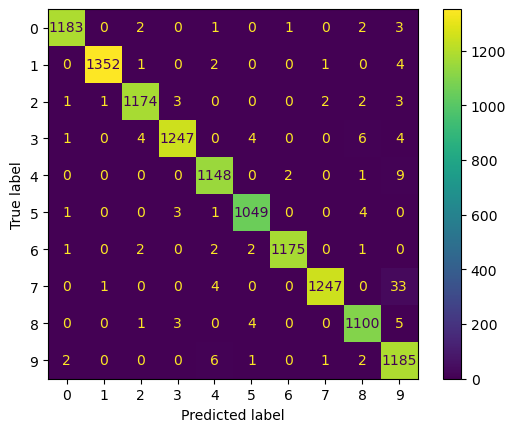

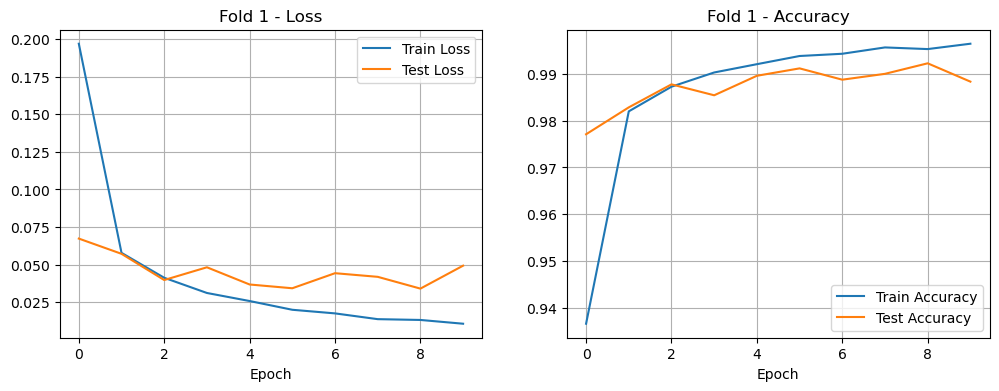

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 0.1888
Test Loss: 0.0818 - Test Accuracy: 97.40%

Epoch [2/10] - Train Loss: 0.0553
Test Loss: 0.0436 - Test Accuracy: 98.65%

Epoch [3/10] - Train Loss: 0.0392
Test Loss: 0.0420 - Test Accuracy: 98.69%

Epoch [4/10] - Train Loss: 0.0293
Test Loss: 0.0388 - Test Accuracy: 98.93%

Epoch [5/10] - Train Loss: 0.0231
Test Loss: 0.0453 - Test Accuracy: 98.59%

Epoch [6/10] - Train Loss: 0.0198
Test Loss: 0.0408 - Test Accuracy: 98.82%

Epoch [7/10] - Train Loss: 0.0152
Test Loss: 0.0392 - Test Accuracy: 98.89%

Epoch [8/10] - Train Loss: 0.0130
Test Loss: 0.0360 - Test Accuracy: 99.08%

Epoch [9/10] - Train Loss: 0.0119
Test Loss: 0.0385 - Test Accuracy: 98.98%

Epoch [10/10] - Train Loss: 0.0104
Test Loss: 0.0386 - Test Accuracy: 99.12%

Recall - Fold 2:
Class 0: Recall = 0.9953
Class 1: Recall = 0.9923
Class 2: Recall = 0.9960
Class 3: Recall = 0.9878
Class 4: Recall = 0.9933
Class 5: Recall = 0.9833
Class 6: Reca

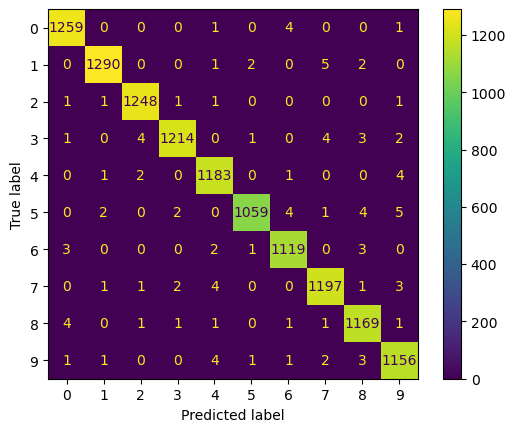

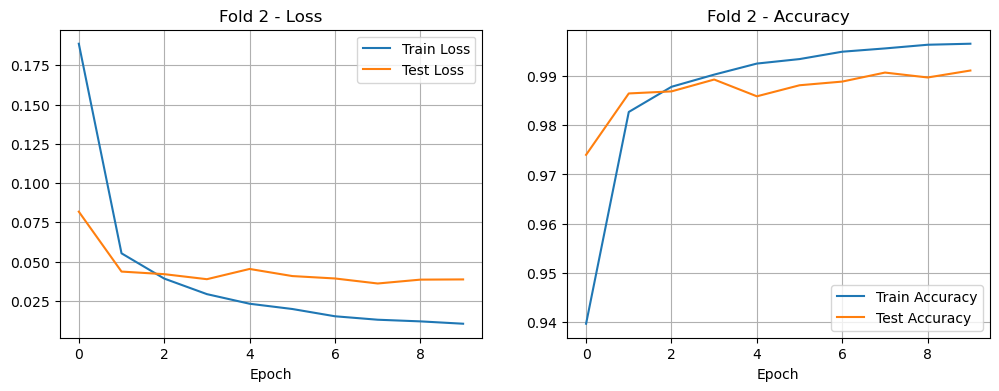

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 0.1937
Test Loss: 0.0597 - Test Accuracy: 98.06%

Epoch [2/10] - Train Loss: 0.0564
Test Loss: 0.0538 - Test Accuracy: 98.42%

Epoch [3/10] - Train Loss: 0.0398
Test Loss: 0.0547 - Test Accuracy: 98.39%

Epoch [4/10] - Train Loss: 0.0298
Test Loss: 0.0397 - Test Accuracy: 98.80%

Epoch [5/10] - Train Loss: 0.0242
Test Loss: 0.0454 - Test Accuracy: 98.74%

Epoch [6/10] - Train Loss: 0.0196
Test Loss: 0.0435 - Test Accuracy: 98.73%

Epoch [7/10] - Train Loss: 0.0164
Test Loss: 0.0376 - Test Accuracy: 98.90%

Epoch [8/10] - Train Loss: 0.0136
Test Loss: 0.0398 - Test Accuracy: 98.96%

Epoch [9/10] - Train Loss: 0.0124
Test Loss: 0.0432 - Test Accuracy: 99.06%

Epoch [10/10] - Train Loss: 0.0109
Test Loss: 0.0510 - Test Accuracy: 98.90%

Recall - Fold 3:
Class 0: Recall = 0.9983
Class 1: Recall = 0.9880
Class 2: Recall = 0.9931
Class 3: Recall = 0.9919
Class 4: Recall = 0.9923
Class 5: Recall = 0.9841
Class 6: Reca

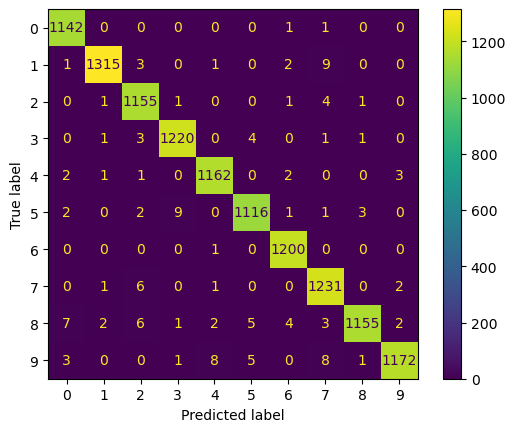

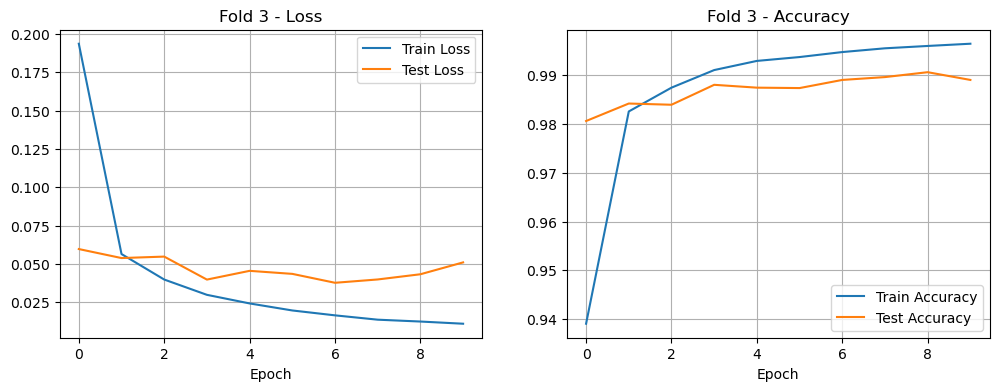

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 0.1877
Test Loss: 0.0979 - Test Accuracy: 97.25%

Epoch [2/10] - Train Loss: 0.0534
Test Loss: 0.0526 - Test Accuracy: 98.38%

Epoch [3/10] - Train Loss: 0.0379
Test Loss: 0.0510 - Test Accuracy: 98.52%

Epoch [4/10] - Train Loss: 0.0308
Test Loss: 0.0387 - Test Accuracy: 98.83%

Epoch [5/10] - Train Loss: 0.0223
Test Loss: 0.0567 - Test Accuracy: 98.37%

Epoch [6/10] - Train Loss: 0.0190
Test Loss: 0.0401 - Test Accuracy: 98.92%

Epoch [7/10] - Train Loss: 0.0155
Test Loss: 0.0386 - Test Accuracy: 99.02%

Epoch [8/10] - Train Loss: 0.0138
Test Loss: 0.0492 - Test Accuracy: 98.79%

Epoch [9/10] - Train Loss: 0.0119
Test Loss: 0.0542 - Test Accuracy: 98.63%

Epoch [10/10] - Train Loss: 0.0102
Test Loss: 0.0534 - Test Accuracy: 98.78%

Recall - Fold 4:
Class 0: Recall = 1.0000
Class 1: Recall = 0.9904
Class 2: Recall = 0.9939
Class 3: Recall = 0.9860
Class 4: Recall = 0.9799
Class 5: Recall = 0.9783
Class 6: Reca

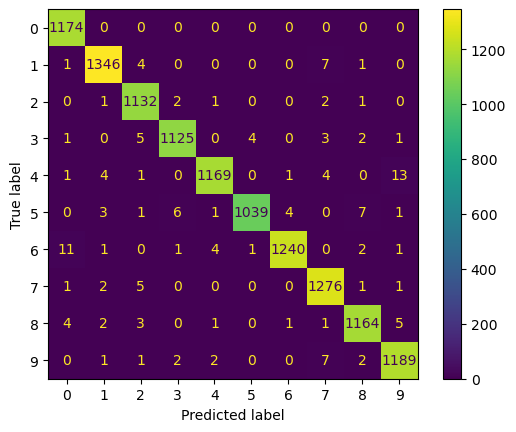

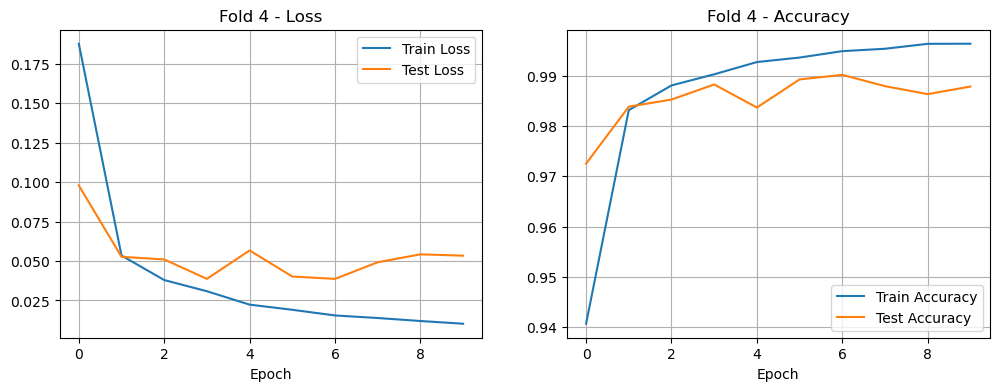

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 0.1931
Test Loss: 0.0594 - Test Accuracy: 98.17%

Epoch [2/10] - Train Loss: 0.0566
Test Loss: 0.0588 - Test Accuracy: 98.10%

Epoch [3/10] - Train Loss: 0.0397
Test Loss: 0.0387 - Test Accuracy: 98.92%

Epoch [4/10] - Train Loss: 0.0325
Test Loss: 0.0427 - Test Accuracy: 98.78%

Epoch [5/10] - Train Loss: 0.0251
Test Loss: 0.0368 - Test Accuracy: 98.89%

Epoch [6/10] - Train Loss: 0.0209
Test Loss: 0.0404 - Test Accuracy: 98.83%

Epoch [7/10] - Train Loss: 0.0160
Test Loss: 0.0424 - Test Accuracy: 99.00%

Epoch [8/10] - Train Loss: 0.0135
Test Loss: 0.0340 - Test Accuracy: 99.10%

Epoch [9/10] - Train Loss: 0.0113
Test Loss: 0.0384 - Test Accuracy: 98.95%

Epoch [10/10] - Train Loss: 0.0108
Test Loss: 0.0388 - Test Accuracy: 99.02%

Recall - Fold 5:
Class 0: Recall = 0.9930
Class 1: Recall = 0.9971
Class 2: Recall = 0.9918
Class 3: Recall = 0.9937
Class 4: Recall = 0.9752
Class 5: Recall = 0.9853
Class 6: Reca

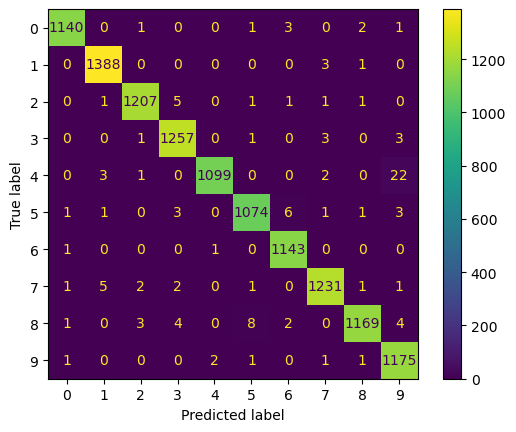

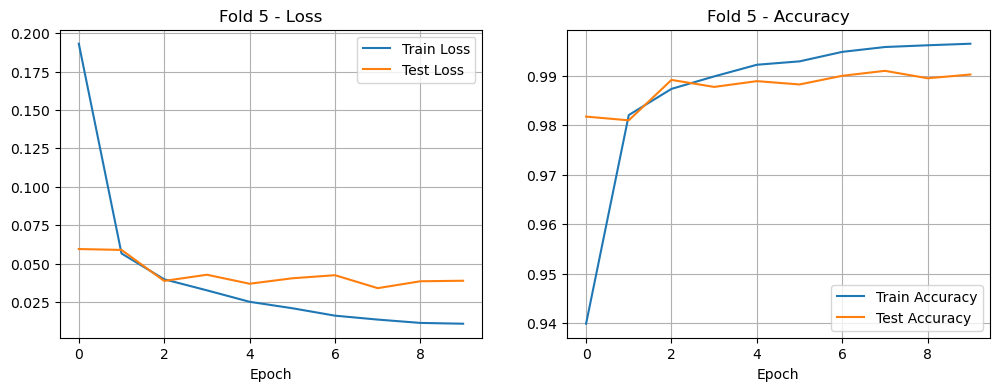

MODELO TERMINADO!!!!
------------------
... Modelo evaluado !!


In [11]:
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy = train_model_kfold(train_norm, trainy) # se entrena el modelo con los datos [0,1]
print ("... Modelo evaluado !!")

Ahora con una normalizacion de [-1,1]

In [7]:
def pixelsmenosuno(train, test):
    # normaliza el conjunto de entrenamiento
    train_norm = (train / 127.5) - 1.0

    # Normaliza el conjunto de prueba
    test_norm = (test / 127.5) - 1.0

    # Devuelve las imágenes normalizadas en el rango [-1, 1]
    return train_norm, test_norm

In [8]:
trainxx, trainyy, testxx, testyy = load_dataset() # cargo datos en [-1,1]

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])


In [9]:
train_norm, test_norm = pixelsmenosuno(trainxx,testxx)  # se aplica una normalizacion 

In [10]:
for i in range(10): #ciclo iterativo para comprobar la normalizaicon 
    print(train_norm[i].min(),train_norm[i].max())

tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)
tensor(-1.) tensor(1.)


Fold 1/5
Epoch [1/10] - Train Loss: 0.1626
Test Loss: 0.0661 - Test Accuracy: 97.97%

Epoch [2/10] - Train Loss: 0.0486
Test Loss: 0.0375 - Test Accuracy: 98.83%

Epoch [3/10] - Train Loss: 0.0371
Test Loss: 0.0387 - Test Accuracy: 98.79%

Epoch [4/10] - Train Loss: 0.0273
Test Loss: 0.0516 - Test Accuracy: 98.47%

Epoch [5/10] - Train Loss: 0.0220
Test Loss: 0.0560 - Test Accuracy: 98.42%

Epoch [6/10] - Train Loss: 0.0188
Test Loss: 0.0323 - Test Accuracy: 99.08%

Epoch [7/10] - Train Loss: 0.0159
Test Loss: 0.0423 - Test Accuracy: 98.98%

Epoch [8/10] - Train Loss: 0.0145
Test Loss: 0.0517 - Test Accuracy: 98.83%

Epoch [9/10] - Train Loss: 0.0117
Test Loss: 0.0429 - Test Accuracy: 99.03%

Epoch [10/10] - Train Loss: 0.0111
Test Loss: 0.0503 - Test Accuracy: 98.92%

Early stopping en fold 1, epoch 10
Recall - Fold 1:
Class 0: Recall = 0.9958
Class 1: Recall = 0.9897
Class 2: Recall = 0.9926
Class 3: Recall = 0.9791
Class 4: Recall = 0.9840
Class 5: Recall = 0.9945
Class 6: Recall = 

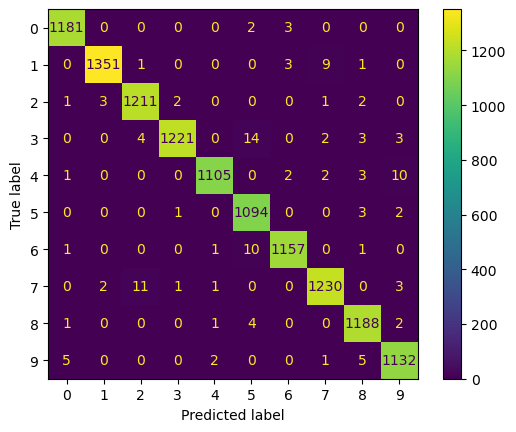

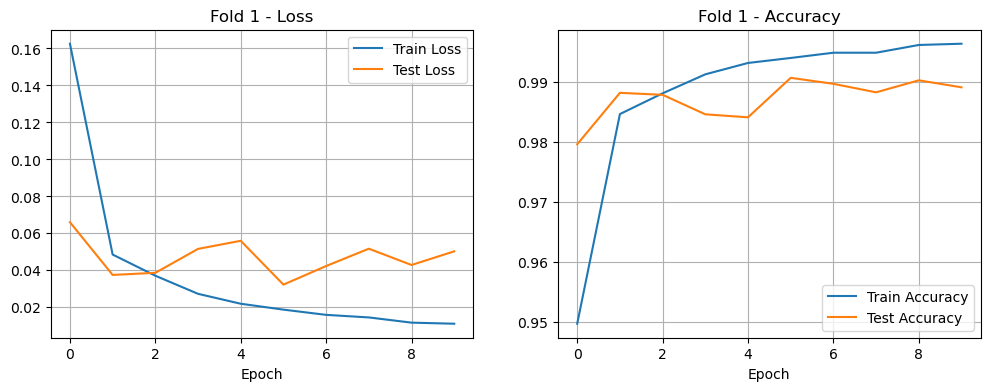

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 0.1609
Test Loss: 0.0556 - Test Accuracy: 98.32%

Epoch [2/10] - Train Loss: 0.0513
Test Loss: 0.0501 - Test Accuracy: 98.46%

Epoch [3/10] - Train Loss: 0.0378
Test Loss: 0.0394 - Test Accuracy: 98.71%

Epoch [4/10] - Train Loss: 0.0274
Test Loss: 0.0428 - Test Accuracy: 98.78%

Epoch [5/10] - Train Loss: 0.0219
Test Loss: 0.0416 - Test Accuracy: 98.84%

Epoch [6/10] - Train Loss: 0.0191
Test Loss: 0.0553 - Test Accuracy: 98.47%

Epoch [7/10] - Train Loss: 0.0164
Test Loss: 0.0615 - Test Accuracy: 98.28%

Early stopping en fold 2, epoch 7
Recall - Fold 2:
Class 0: Recall = 0.9943
Class 1: Recall = 0.9878
Class 2: Recall = 0.9870
Class 3: Recall = 0.9924
Class 4: Recall = 0.9827
Class 5: Recall = 0.9982
Class 6: Recall = 0.9796
Class 7: Recall = 0.9953
Class 8: Recall = 0.9411
Class 9: Recall = 0.9657
Valor F1 - Fold 2:
Class 0: F1-Score = 0.9910
Class 1: F1-Score = 0.9916
Class 2: F1-Score = 0.9858
Class 3: F1

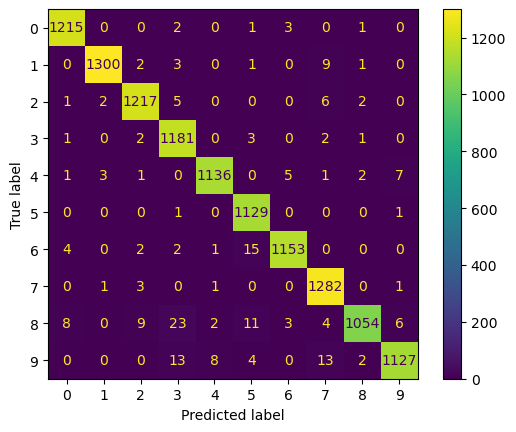

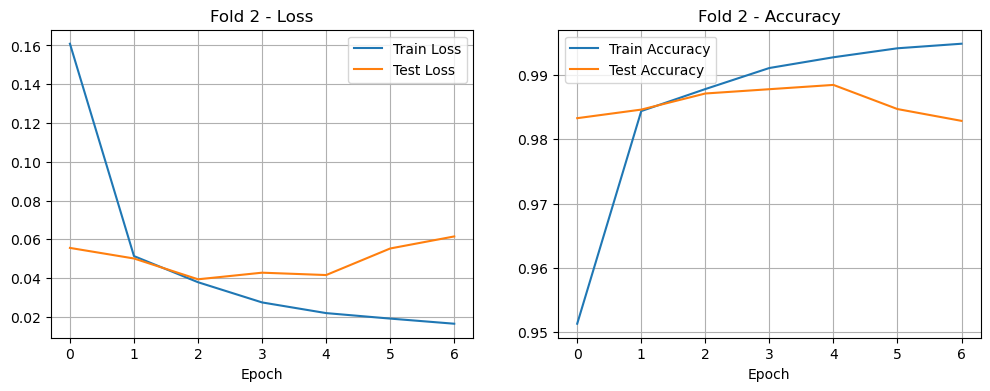

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 0.1670
Test Loss: 0.0681 - Test Accuracy: 97.95%

Epoch [2/10] - Train Loss: 0.0517
Test Loss: 0.0487 - Test Accuracy: 98.56%

Epoch [3/10] - Train Loss: 0.0386
Test Loss: 0.0572 - Test Accuracy: 98.22%

Epoch [4/10] - Train Loss: 0.0304
Test Loss: 0.0449 - Test Accuracy: 98.70%

Epoch [5/10] - Train Loss: 0.0237
Test Loss: 0.0540 - Test Accuracy: 98.42%

Epoch [6/10] - Train Loss: 0.0201
Test Loss: 0.0392 - Test Accuracy: 98.91%

Epoch [7/10] - Train Loss: 0.0160
Test Loss: 0.0462 - Test Accuracy: 98.78%

Epoch [8/10] - Train Loss: 0.0151
Test Loss: 0.0450 - Test Accuracy: 98.80%

Epoch [9/10] - Train Loss: 0.0123
Test Loss: 0.0524 - Test Accuracy: 98.85%

Epoch [10/10] - Train Loss: 0.0096
Test Loss: 0.0497 - Test Accuracy: 98.78%

Early stopping en fold 3, epoch 10
Recall - Fold 3:
Class 0: Recall = 0.9957
Class 1: Recall = 0.9948
Class 2: Recall = 0.9848
Class 3: Recall = 0.9882
Class 4: Recall = 0.9948
Cla

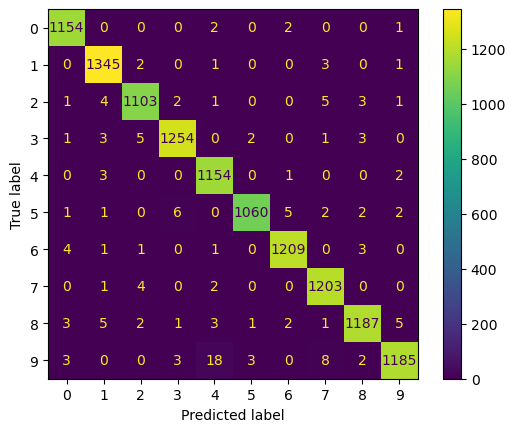

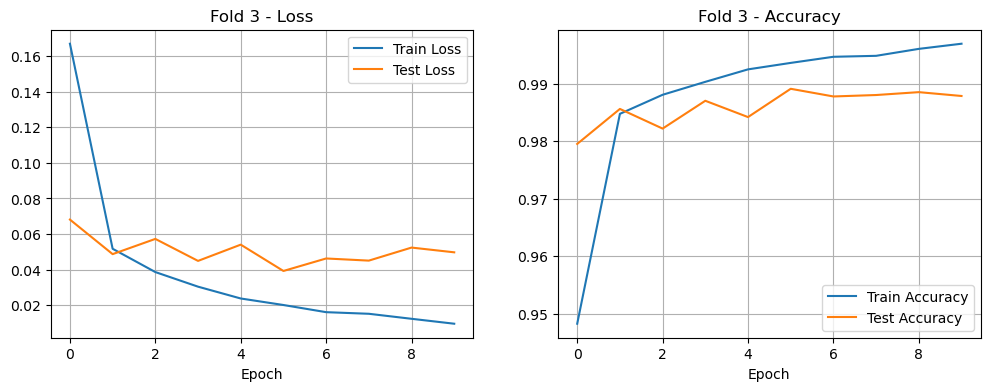

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 0.1861
Test Loss: 0.0615 - Test Accuracy: 98.14%

Epoch [2/10] - Train Loss: 0.0525
Test Loss: 0.0409 - Test Accuracy: 98.76%

Epoch [3/10] - Train Loss: 0.0379
Test Loss: 0.0388 - Test Accuracy: 98.91%

Epoch [4/10] - Train Loss: 0.0297
Test Loss: 0.0344 - Test Accuracy: 98.97%

Epoch [5/10] - Train Loss: 0.0237
Test Loss: 0.0414 - Test Accuracy: 98.94%

Epoch [6/10] - Train Loss: 0.0185
Test Loss: 0.0469 - Test Accuracy: 98.64%

Epoch [7/10] - Train Loss: 0.0165
Test Loss: 0.0439 - Test Accuracy: 98.92%

Epoch [8/10] - Train Loss: 0.0126
Test Loss: 0.0499 - Test Accuracy: 98.80%

Early stopping en fold 4, epoch 8
Recall - Fold 4:
Class 0: Recall = 0.9950
Class 1: Recall = 0.9963
Class 2: Recall = 0.9854
Class 3: Recall = 0.9908
Class 4: Recall = 0.9909
Class 5: Recall = 0.9765
Class 6: Recall = 0.9924
Class 7: Recall = 0.9905
Class 8: Recall = 0.9868
Class 9: Recall = 0.9729
Valor F1 - Fold 4:
Class 0: F1-Sco

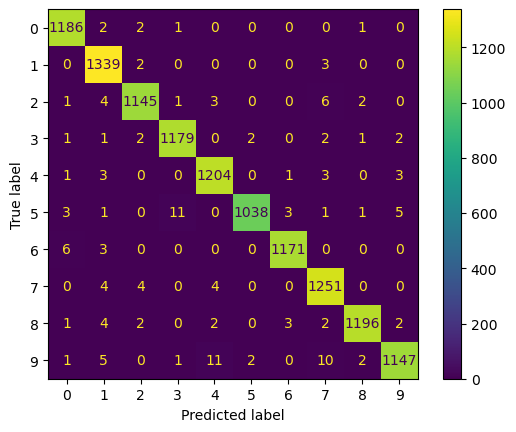

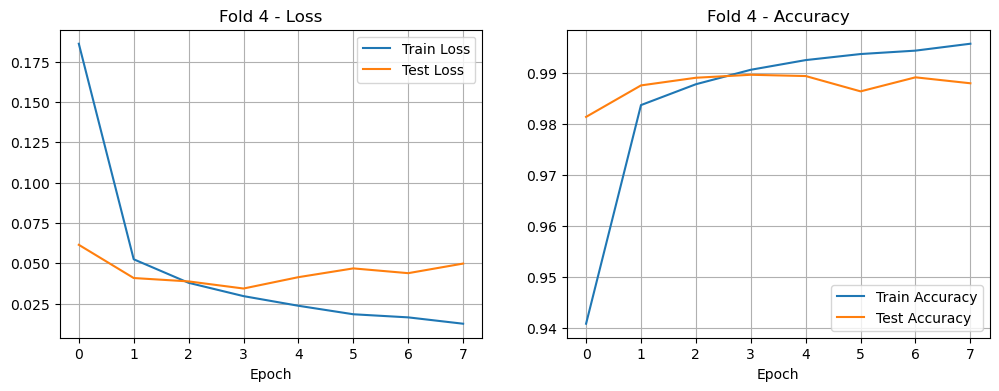

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 0.1745
Test Loss: 0.0591 - Test Accuracy: 98.27%

Epoch [2/10] - Train Loss: 0.0529
Test Loss: 0.0495 - Test Accuracy: 98.52%

Epoch [3/10] - Train Loss: 0.0388
Test Loss: 0.0391 - Test Accuracy: 98.92%

Epoch [4/10] - Train Loss: 0.0303
Test Loss: 0.0438 - Test Accuracy: 98.63%

Epoch [5/10] - Train Loss: 0.0238
Test Loss: 0.0376 - Test Accuracy: 98.86%

Epoch [6/10] - Train Loss: 0.0185
Test Loss: 0.0523 - Test Accuracy: 98.70%

Epoch [7/10] - Train Loss: 0.0180
Test Loss: 0.0416 - Test Accuracy: 98.98%

Epoch [8/10] - Train Loss: 0.0146
Test Loss: 0.0450 - Test Accuracy: 98.86%

Epoch [9/10] - Train Loss: 0.0106
Test Loss: 0.0746 - Test Accuracy: 98.62%

Early stopping en fold 5, epoch 9
Recall - Fold 5:
Class 0: Recall = 0.9931
Class 1: Recall = 0.9963
Class 2: Recall = 0.9779
Class 3: Recall = 0.9870
Class 4: Recall = 0.9857
Class 5: Recall = 0.9847
Class 6: Recall = 0.9846
Class 7: Recall = 0.9881
Class 8

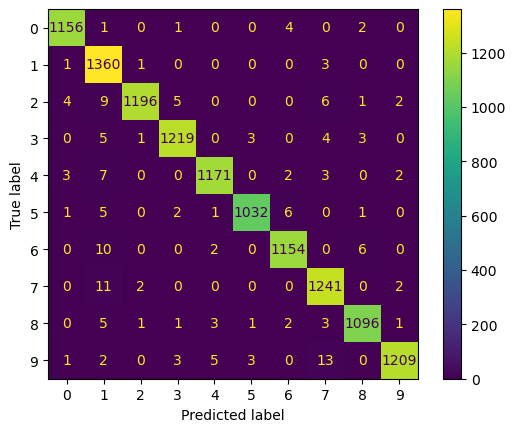

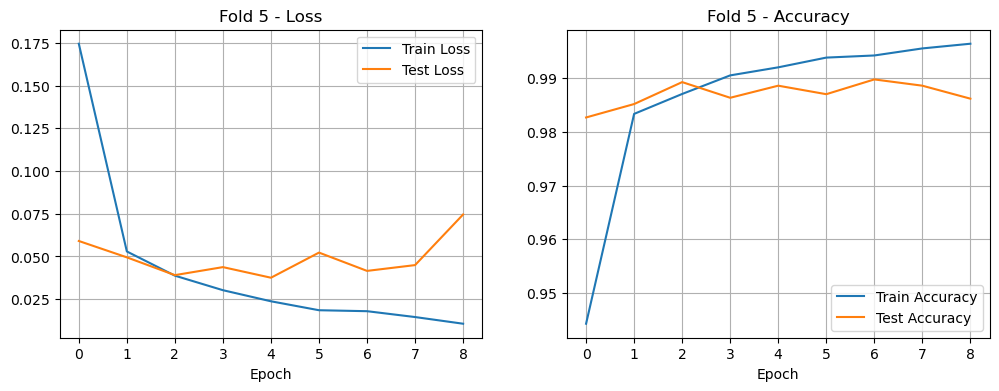

MODELO TERMINADO!!!!
------------------
... Modelo evaluado !!


In [11]:
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy = train_model_kfold(train_norm, trainyy) # se entrena el modelo con los datos[-1,1]
print ("... Modelo evaluado !!")

OTRA OPCION DE NORMALIZACION ES LA ESTANDARIZACION 

In [6]:
def estandarizacion(train, test):
    # Calcula la media y la desviación estándar de los datos de entrenamiento
    mean = torch.mean(train)
    std = torch.std(train)

    # Aplica la estandarización a los datos de entrenamiento y prueba
    train_std = (train - mean) / std
    test_std = (test - mean) / std

    return train_std, test_std

In [7]:
trainxx, trainyy, testxx, testyy = load_dataset() # cargo datos 

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])


In [8]:
train_std , test_std = estandarizacion(trainxx, testxx) # aplica normalizacion 

In [9]:
for i in range(10): # verifico los valores 
    print(train_std[i].min(),train_std[i].max())

tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)


Fold 1/5
Epoch [1/10] - Train Loss: 0.1487
Test Loss: 0.0582 - Test Accuracy: 98.26%

Epoch [2/10] - Train Loss: 0.0490
Test Loss: 0.0518 - Test Accuracy: 98.44%

Epoch [3/10] - Train Loss: 0.0351
Test Loss: 0.0449 - Test Accuracy: 98.63%

Epoch [4/10] - Train Loss: 0.0271
Test Loss: 0.0448 - Test Accuracy: 98.76%

Epoch [5/10] - Train Loss: 0.0218
Test Loss: 0.0344 - Test Accuracy: 99.02%

Epoch [6/10] - Train Loss: 0.0172
Test Loss: 0.0354 - Test Accuracy: 99.02%

Epoch [7/10] - Train Loss: 0.0149
Test Loss: 0.0494 - Test Accuracy: 98.88%

Epoch [8/10] - Train Loss: 0.0124
Test Loss: 0.0488 - Test Accuracy: 98.81%

Epoch [9/10] - Train Loss: 0.0123
Test Loss: 0.0448 - Test Accuracy: 98.96%

Early stopping en fold 1, epoch 9
Recall - Fold 1:
Class 0: Recall = 0.9983
Class 1: Recall = 0.9985
Class 2: Recall = 0.9906
Class 3: Recall = 0.9834
Class 4: Recall = 0.9813
Class 5: Recall = 0.9874
Class 6: Recall = 0.9975
Class 7: Recall = 0.9880
Class 8: Recall = 0.9851
Class 9: Recall = 0.98

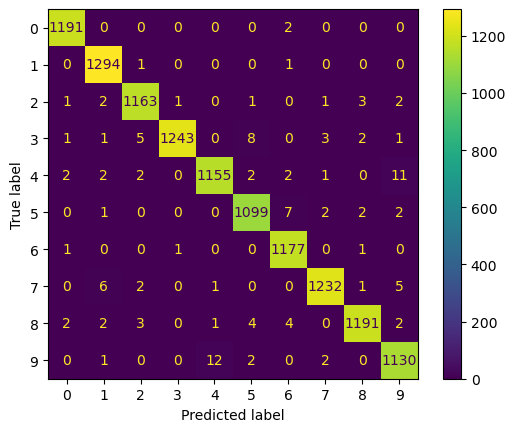

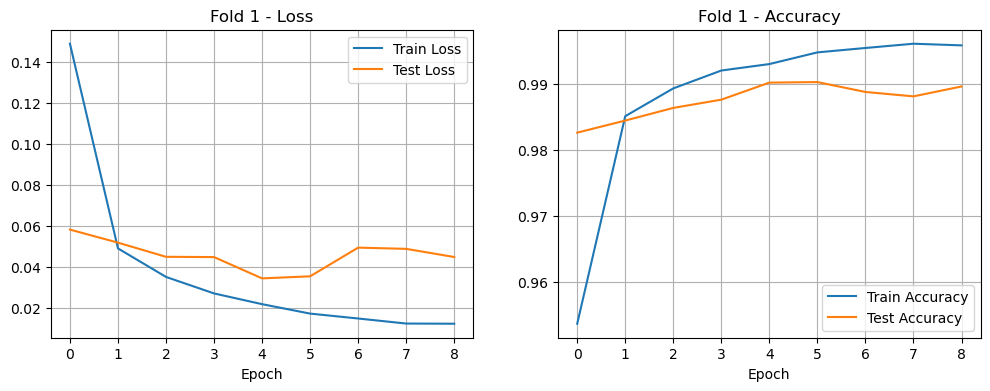

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 0.1442
Test Loss: 0.0671 - Test Accuracy: 97.96%

Epoch [2/10] - Train Loss: 0.0467
Test Loss: 0.0388 - Test Accuracy: 98.83%

Epoch [3/10] - Train Loss: 0.0349
Test Loss: 0.0466 - Test Accuracy: 98.71%

Epoch [4/10] - Train Loss: 0.0273
Test Loss: 0.0535 - Test Accuracy: 98.47%

Epoch [5/10] - Train Loss: 0.0216
Test Loss: 0.0475 - Test Accuracy: 98.68%

Epoch [6/10] - Train Loss: 0.0177
Test Loss: 0.0600 - Test Accuracy: 98.57%

Early stopping en fold 2, epoch 6
Recall - Fold 2:
Class 0: Recall = 0.9899
Class 1: Recall = 0.9852
Class 2: Recall = 0.9865
Class 3: Recall = 0.9836
Class 4: Recall = 0.9896
Class 5: Recall = 0.9953
Class 6: Recall = 0.9959
Class 7: Recall = 0.9952
Class 8: Recall = 0.9527
Class 9: Recall = 0.9821
Valor F1 - Fold 2:
Class 0: F1-Score = 0.9916
Class 1: F1-Score = 0.9896
Class 2: F1-Score = 0.9840
Class 3: F1-Score = 0.9873
Class 4: F1-Score = 0.9862
Class 5: F1-Score = 0.9855
Class 6

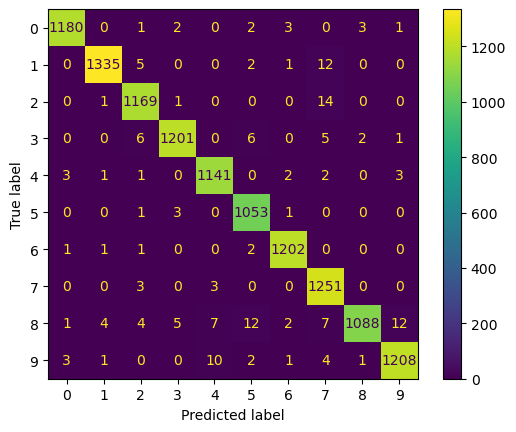

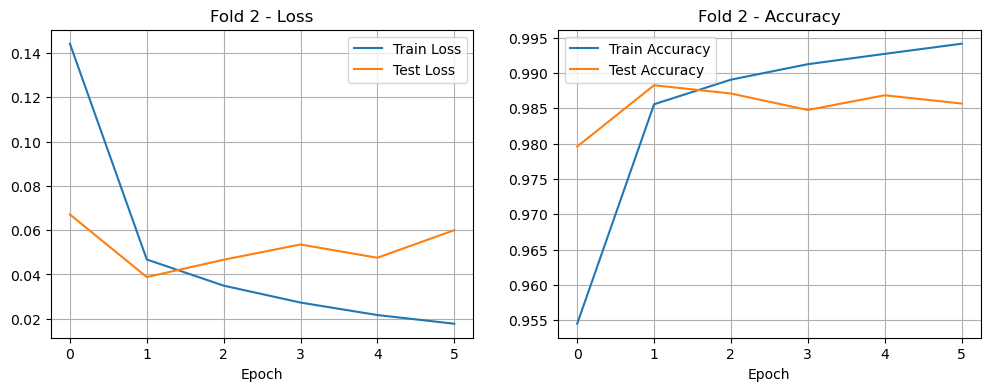

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 0.1527
Test Loss: 0.0821 - Test Accuracy: 97.49%

Epoch [2/10] - Train Loss: 0.0489
Test Loss: 0.0489 - Test Accuracy: 98.54%

Epoch [3/10] - Train Loss: 0.0358
Test Loss: 0.0427 - Test Accuracy: 98.74%

Epoch [4/10] - Train Loss: 0.0260
Test Loss: 0.0411 - Test Accuracy: 98.90%

Epoch [5/10] - Train Loss: 0.0211
Test Loss: 0.0379 - Test Accuracy: 98.95%

Epoch [6/10] - Train Loss: 0.0183
Test Loss: 0.0446 - Test Accuracy: 98.69%

Epoch [7/10] - Train Loss: 0.0141
Test Loss: 0.0389 - Test Accuracy: 98.95%

Epoch [8/10] - Train Loss: 0.0132
Test Loss: 0.0501 - Test Accuracy: 98.70%

Epoch [9/10] - Train Loss: 0.0112
Test Loss: 0.0479 - Test Accuracy: 98.83%

Early stopping en fold 3, epoch 9
Recall - Fold 3:
Class 0: Recall = 0.9959
Class 1: Recall = 0.9891
Class 2: Recall = 0.9932
Class 3: Recall = 0.9865
Class 4: Recall = 0.9892
Class 5: Recall = 0.9785
Class 6: Recall = 0.9880
Class 7: Recall = 0.9802
Class 8

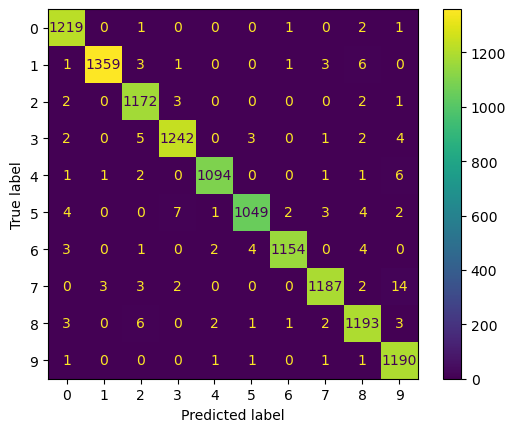

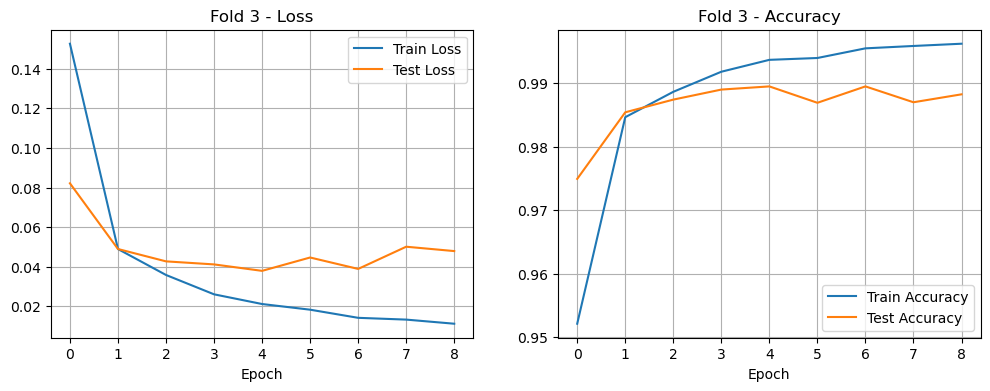

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 0.1514
Test Loss: 0.0582 - Test Accuracy: 98.23%

Epoch [2/10] - Train Loss: 0.0505
Test Loss: 0.0442 - Test Accuracy: 98.64%

Epoch [3/10] - Train Loss: 0.0357
Test Loss: 0.0674 - Test Accuracy: 97.99%

Epoch [4/10] - Train Loss: 0.0280
Test Loss: 0.0369 - Test Accuracy: 99.02%

Epoch [5/10] - Train Loss: 0.0225
Test Loss: 0.0399 - Test Accuracy: 98.80%

Epoch [6/10] - Train Loss: 0.0178
Test Loss: 0.0349 - Test Accuracy: 99.12%

Epoch [7/10] - Train Loss: 0.0151
Test Loss: 0.0427 - Test Accuracy: 98.97%

Epoch [8/10] - Train Loss: 0.0138
Test Loss: 0.0396 - Test Accuracy: 99.01%

Epoch [9/10] - Train Loss: 0.0112
Test Loss: 0.0387 - Test Accuracy: 99.10%

Epoch [10/10] - Train Loss: 0.0128
Test Loss: 0.0440 - Test Accuracy: 99.10%

Early stopping en fold 4, epoch 10
Recall - Fold 4:
Class 0: Recall = 0.9966
Class 1: Recall = 0.9964
Class 2: Recall = 0.9932
Class 3: Recall = 0.9905
Class 4: Recall = 0.9958
Cla

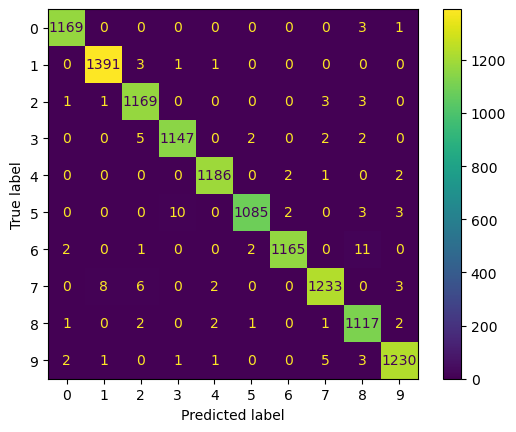

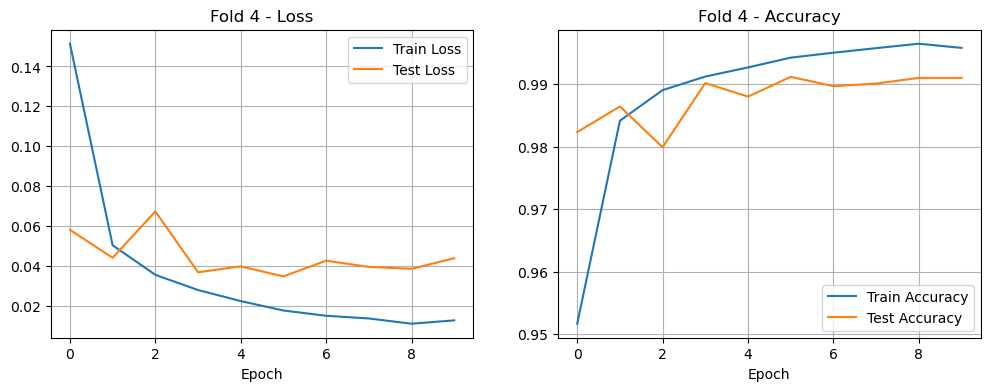

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 0.1536
Test Loss: 0.0602 - Test Accuracy: 98.08%

Epoch [2/10] - Train Loss: 0.0486
Test Loss: 0.0694 - Test Accuracy: 97.72%

Epoch [3/10] - Train Loss: 0.0357
Test Loss: 0.0485 - Test Accuracy: 98.49%

Epoch [4/10] - Train Loss: 0.0274
Test Loss: 0.0454 - Test Accuracy: 98.83%

Epoch [5/10] - Train Loss: 0.0226
Test Loss: 0.0405 - Test Accuracy: 98.90%

Epoch [6/10] - Train Loss: 0.0177
Test Loss: 0.0358 - Test Accuracy: 99.05%

Epoch [7/10] - Train Loss: 0.0145
Test Loss: 0.0429 - Test Accuracy: 99.00%

Epoch [8/10] - Train Loss: 0.0119
Test Loss: 0.0425 - Test Accuracy: 99.01%

Epoch [9/10] - Train Loss: 0.0116
Test Loss: 0.0446 - Test Accuracy: 98.97%

Epoch [10/10] - Train Loss: 0.0106
Test Loss: 0.0500 - Test Accuracy: 98.96%

Early stopping en fold 5, epoch 10
Recall - Fold 5:
Class 0: Recall = 0.9930
Class 1: Recall = 0.9955
Class 2: Recall = 0.9952
Class 3: Recall = 0.9902
Class 4: Recall = 0.9926
Cla

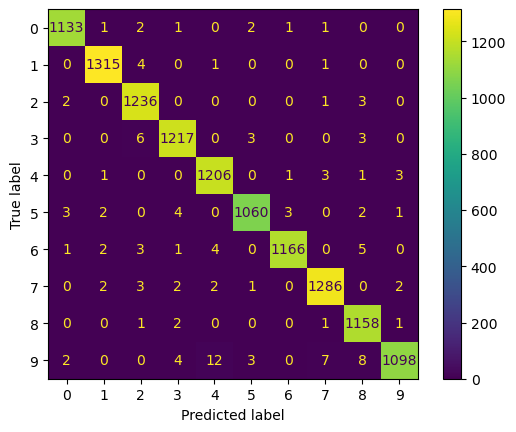

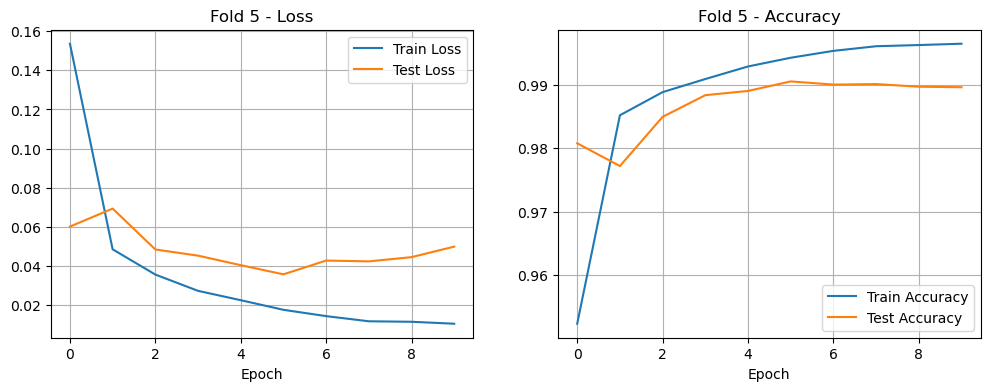

MODELO TERMINADO!!!!
------------------
... Modelo evaluado !!


In [10]:
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy = train_model_kfold(train_std, trainyy) # se entrena el modelo con la estandarizacion
print ("... Modelo evaluado !!")

NORMALIZANDO DE FORMA CENTRALIZADA

In [6]:
def centrado(train, test): # se aplica una normalizacion centralizada  
    mean = torch.mean(train)
    train_centered = train - mean
    test_centered = test - mean
    return train_centered, test_centered

In [7]:
trainxx, trainyy, testxx, testyy = load_dataset() # cargo los datos 

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])


In [8]:
train_centrado , test_centrado = centrado(trainxx, testxx) # aplico la normalizacion de forma centralizada

In [9]:
for i in range(10):         # compruebo valores 
    print(train_centrado[i].min(),train_centrado[i].max())

tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)
tensor(-33.3184) tensor(221.6816)


Fold 1/5
Epoch [1/10] - Train Loss: 0.1540
Test Loss: 0.0724 - Test Accuracy: 97.72%

Epoch [2/10] - Train Loss: 0.0643
Test Loss: 0.1028 - Test Accuracy: 96.77%

Epoch [3/10] - Train Loss: 0.0557
Test Loss: 0.0558 - Test Accuracy: 98.28%

Epoch [4/10] - Train Loss: 0.0524
Test Loss: 0.0821 - Test Accuracy: 97.72%

Epoch [5/10] - Train Loss: 0.0380
Test Loss: 0.0656 - Test Accuracy: 98.16%

Epoch [6/10] - Train Loss: 0.0409
Test Loss: 0.0633 - Test Accuracy: 98.18%

Epoch [7/10] - Train Loss: 0.0364
Test Loss: 0.0797 - Test Accuracy: 98.14%

Early stopping en fold 1, epoch 7
Recall - Fold 1:
Class 0: Recall = 0.9902
Class 1: Recall = 0.9786
Class 2: Recall = 0.9601
Class 3: Recall = 0.9893
Class 4: Recall = 0.9813
Class 5: Recall = 0.9694
Class 6: Recall = 0.9894
Class 7: Recall = 0.9900
Class 8: Recall = 0.9769
Class 9: Recall = 0.9868
Valor F1 - Fold 1:
Class 0: F1-Score = 0.9902
Class 1: F1-Score = 0.9842
Class 2: F1-Score = 0.9692
Class 3: F1-Score = 0.9853
Class 4: F1-Score = 0.98

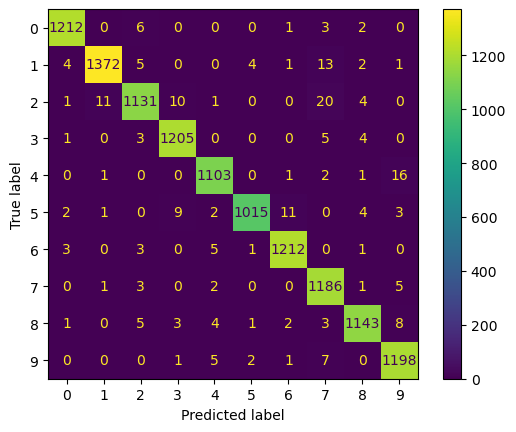

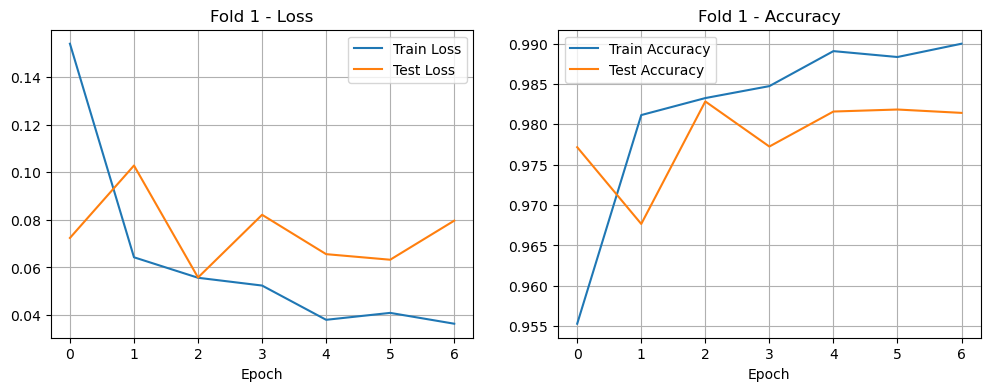

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 0.1560
Test Loss: 0.0809 - Test Accuracy: 97.67%

Epoch [2/10] - Train Loss: 0.0624
Test Loss: 0.0626 - Test Accuracy: 98.15%

Epoch [3/10] - Train Loss: 0.0511
Test Loss: 0.0722 - Test Accuracy: 98.19%

Epoch [4/10] - Train Loss: 0.0431
Test Loss: 0.0924 - Test Accuracy: 97.42%

Epoch [5/10] - Train Loss: 0.0400
Test Loss: 0.0557 - Test Accuracy: 98.52%

Epoch [6/10] - Train Loss: 0.0353
Test Loss: 0.0705 - Test Accuracy: 98.42%

Epoch [7/10] - Train Loss: 0.0357
Test Loss: 0.0592 - Test Accuracy: 98.52%

Epoch [8/10] - Train Loss: 0.0328
Test Loss: 0.0765 - Test Accuracy: 98.40%

Epoch [9/10] - Train Loss: 0.0332
Test Loss: 0.0884 - Test Accuracy: 98.39%

Early stopping en fold 2, epoch 9
Recall - Fold 2:
Class 0: Recall = 0.9949
Class 1: Recall = 0.9910
Class 2: Recall = 0.9761
Class 3: Recall = 0.9772
Class 4: Recall = 0.9899
Class 5: Recall = 0.9701
Class 6: Recall = 0.9861
Class 7: Recall = 0.9876
Class 8

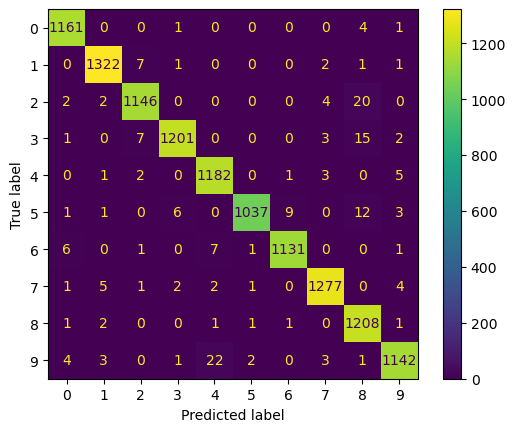

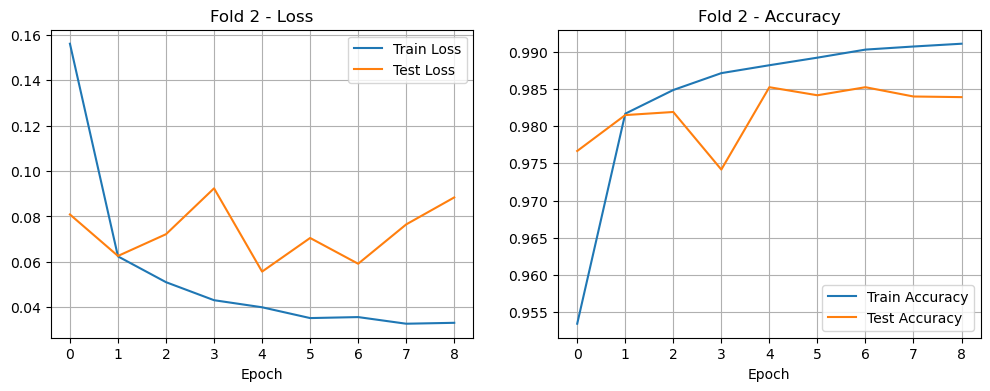

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 0.1376
Test Loss: 0.0668 - Test Accuracy: 98.05%

Epoch [2/10] - Train Loss: 0.0599
Test Loss: 0.0561 - Test Accuracy: 98.62%

Epoch [3/10] - Train Loss: 0.0488
Test Loss: 0.1234 - Test Accuracy: 97.22%

Epoch [4/10] - Train Loss: 0.0418
Test Loss: 0.0615 - Test Accuracy: 98.47%

Epoch [5/10] - Train Loss: 0.0382
Test Loss: 0.0622 - Test Accuracy: 98.54%

Epoch [6/10] - Train Loss: 0.0352
Test Loss: 0.1114 - Test Accuracy: 97.43%

Early stopping en fold 3, epoch 6
Recall - Fold 3:
Class 0: Recall = 0.9725
Class 1: Recall = 0.9847
Class 2: Recall = 0.9813
Class 3: Recall = 0.9694
Class 4: Recall = 0.9267
Class 5: Recall = 0.9596
Class 6: Recall = 0.9931
Class 7: Recall = 0.9894
Class 8: Recall = 0.9895
Class 9: Recall = 0.9760
Valor F1 - Fold 3:
Class 0: F1-Score = 0.9835
Class 1: F1-Score = 0.9908
Class 2: F1-Score = 0.9830
Class 3: F1-Score = 0.9816
Class 4: F1-Score = 0.9582
Class 5: F1-Score = 0.9736
Class 6

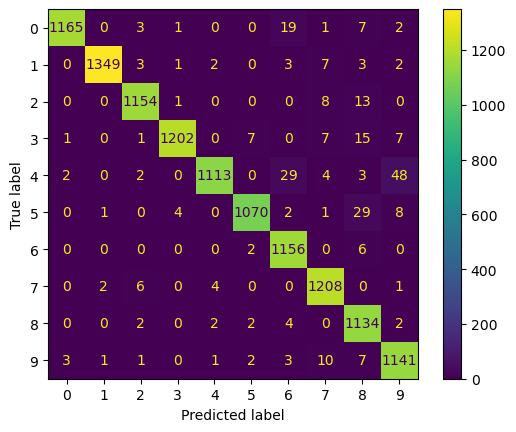

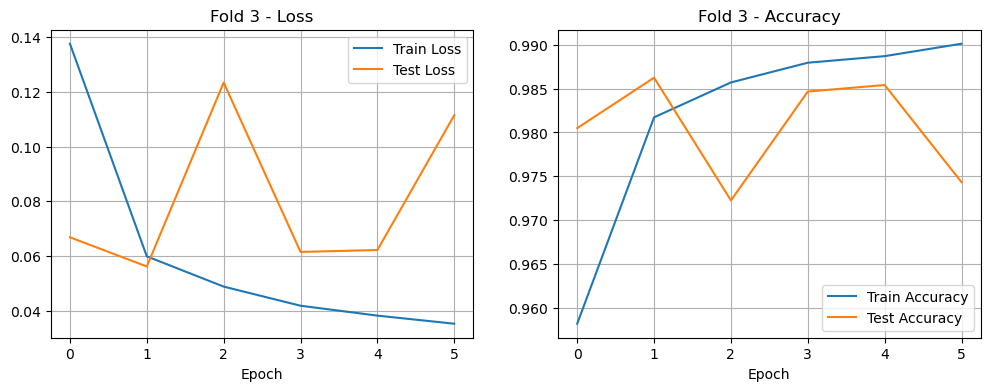

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 0.1449
Test Loss: 0.0711 - Test Accuracy: 97.78%

Epoch [2/10] - Train Loss: 0.0620
Test Loss: 0.0667 - Test Accuracy: 98.17%

Epoch [3/10] - Train Loss: 0.0493
Test Loss: 0.0564 - Test Accuracy: 98.43%

Epoch [4/10] - Train Loss: 0.0465
Test Loss: 0.0863 - Test Accuracy: 97.84%

Epoch [5/10] - Train Loss: 0.0405
Test Loss: 0.0448 - Test Accuracy: 98.67%

Epoch [6/10] - Train Loss: 0.0371
Test Loss: 0.0578 - Test Accuracy: 98.52%

Epoch [7/10] - Train Loss: 0.0363
Test Loss: 0.0675 - Test Accuracy: 98.32%

Epoch [8/10] - Train Loss: 0.0337
Test Loss: 0.0643 - Test Accuracy: 98.42%

Epoch [9/10] - Train Loss: 0.0283
Test Loss: 0.0772 - Test Accuracy: 98.36%

Early stopping en fold 4, epoch 9
Recall - Fold 4:
Class 0: Recall = 0.9915
Class 1: Recall = 0.9866
Class 2: Recall = 0.9781
Class 3: Recall = 0.9645
Class 4: Recall = 0.9947
Class 5: Recall = 0.9945
Class 6: Recall = 0.9837
Class 7: Recall = 0.9853
Class 8

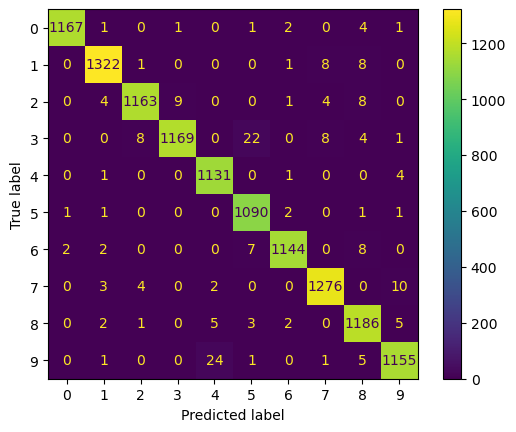

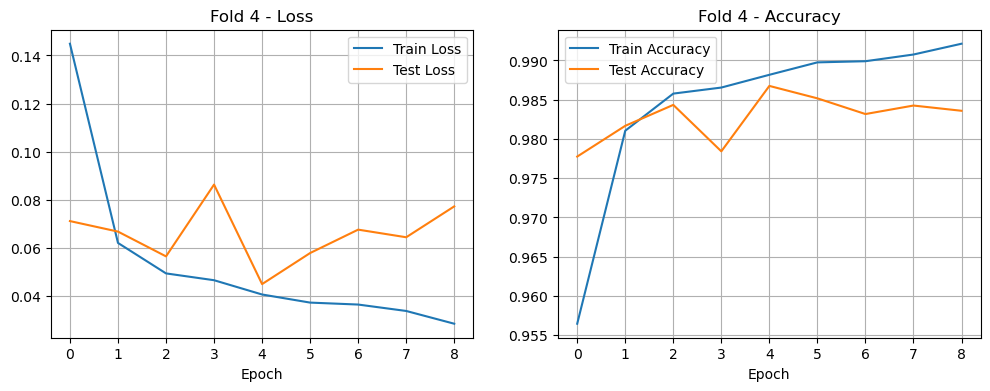

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 0.1483
Test Loss: 0.0645 - Test Accuracy: 98.03%

Epoch [2/10] - Train Loss: 0.0611
Test Loss: 0.0575 - Test Accuracy: 98.24%

Epoch [3/10] - Train Loss: 0.0507
Test Loss: 0.0718 - Test Accuracy: 98.12%

Epoch [4/10] - Train Loss: 0.0480
Test Loss: 0.0810 - Test Accuracy: 97.86%

Epoch [5/10] - Train Loss: 0.0392
Test Loss: 0.0708 - Test Accuracy: 98.02%

Epoch [6/10] - Train Loss: 0.0366
Test Loss: 0.0561 - Test Accuracy: 98.47%

Epoch [7/10] - Train Loss: 0.0324
Test Loss: 0.0633 - Test Accuracy: 98.43%

Epoch [8/10] - Train Loss: 0.0325
Test Loss: 0.0962 - Test Accuracy: 98.08%

Epoch [9/10] - Train Loss: 0.0320
Test Loss: 0.0703 - Test Accuracy: 98.62%

Epoch [10/10] - Train Loss: 0.0291
Test Loss: 0.0879 - Test Accuracy: 98.44%

Early stopping en fold 5, epoch 10
Recall - Fold 5:
Class 0: Recall = 0.9922
Class 1: Recall = 0.9853
Class 2: Recall = 0.9863
Class 3: Recall = 0.9797
Class 4: Recall = 0.9815
Cla

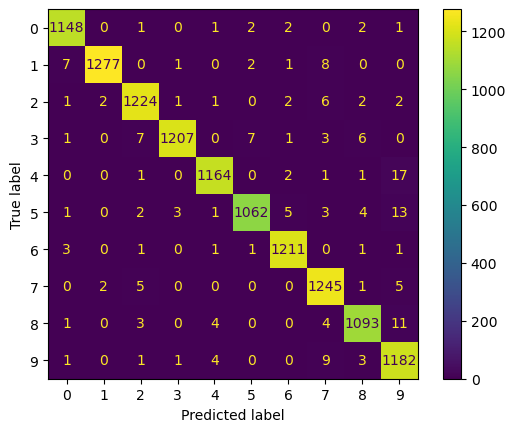

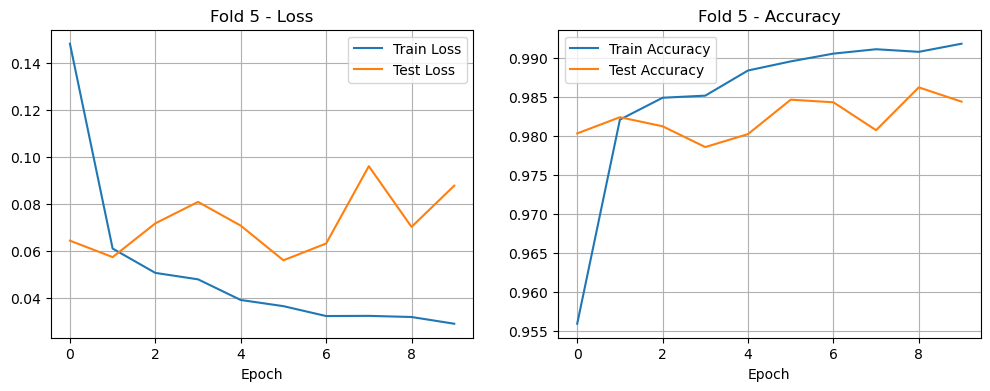

MODELO TERMINADO!!!!
------------------


In [10]:
# se entrenan los datos con una normalizacion centralizada 
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy = train_model_kfold(train_centrado, trainyy) 

Despues de recopilar los datos neceesario de cada modelo para poder visualizar sus curvas,
matrices, recalls, f1-score,etc. en el excel, hemos llegado a la conclusion de elegir la 
normalizacion estandarizada ya que en las matrices de cada fold el numero de errores de cada 
clase es menor en comparacion a los otros erroes de las demas matrices, incluyendo la del
modelo base, donde el numero mayor de error en una clase es 33. Ademas sus curvas
son las unicas que demuestran un entrenamiento constante, no teniendo 'cerros'

A pesar de que en el grafico de recalls de la estandarizacion no es tan estable como lo es en
la normalizacion [-1,1] - teniendo en consideracion la definicion: capacidad de un modelo para
identificar correctamente todos los ejemplos positivos en un conjunto de datos- es mas
estable que en el modelo base demostrando un equilibrio entre las cases.

En el grafico de f1-score - definicion: Combina dos métricas clave: la precisión (precision) y el recall 
(exhaustividad o sensibilidad) en un solo número, proporcionando una medida equilibrada del 
rendimiento del modelo- de igual manera los resultados son mas estables en todas las clases, es decir, que en las 
clases el % que mas prevalece es de 98 en todas las clases.

En la normalizacion centrada se podria descartar de manera automatica ya que en los graficos
recalls y f1-score los resultados no son beneficioso, dado que, el modelo es capaz de predecir
ciertas cantidad de clases pero en las otras clases al parecer le cuesta mas reconocerlas. Ademas,
de tener unas curvas de entrenamiento bastante distintas a las demas teniendo 'peaks' tanto para 
arriba como para abajo lo cual no es lo mejor para un modelo. 
Lo que se busca es tener curvas de entrenamiento estables para poder tener buenas predicciones
en todas las clases  

En resumen, los datos de la forma estandarizada tienen una mejora en comparacion al modelo base
en el sentido de la matriz, curvas y graficos recalls

EN BUSCA DE LOS MEJORES PARAMETROS 

In [6]:
from sklearn.base import BaseEstimator
# define un modelo personalizacod  como una subclase de BaseEstimator
class CustomModel(BaseEstimator):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [13]:
def train_learningrate(trainx, trainy, learning_rate=0.001, patience=4, n_folds=5): # patience encargado de regular el early stopping 
    scores, histories, recalls = list(), list(), list()
    
    batch_size = 32
    num_epochs = 10
   
    # objeto para dividir los datos en n pliegues estratificados
    kfold = KFold(n_splits=n_folds, shuffle=True)

    # Itera a través de los pliegues de validación cruzada
    for fold, (train_indices, test_indices) in enumerate(kfold.split(trainx)):
        print(f"Fold {fold + 1}/{n_folds}")
        
        # Divide los datos en conjuntos de entrenamiento y prueba para el fold respectivo 
        train_data, test_data = trainx[train_indices], trainx[test_indices]
        train_labels, test_labels = trainy[train_indices], trainy[test_indices]

        # Crea dataloaders para entrenamiento y prueba para el fold respectivo 
        train_loader = torch.utils.data.DataLoader(dataset=CustomDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=CustomDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

        # Inicializa el modelo y el optimizador
        model = Red().to('cuda') # modelo en la gpu 
        
        criterion = nn.CrossEntropyLoss() # funcion del error 
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        aux1 = [] # lista para obtener los errores del train
        aux2 = [] # lista para obtener los errores del test 

        aux3 = [] # lista para obtener accuracy del data train 
        aux4 = [] # lista para obtener accuracy del data test 
 

        best_val_loss=2
        no_improvement_count=0
        # Entrena el modelo
        for epoch in range(num_epochs):
            
            train_loss,train_accuracy = train(model, train_loader, criterion, optimizer) # en este momento de entrena el modelo por epocas 
            aux1.append(train_loss) # lista de errores en data train
            aux3.append(train_accuracy) # lista de accuracy en data train
            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

            # Evalúa el modelo en el conjunto de prueba
            test_loss, test_accuracy = evaluate(model, test_loader, criterion)
            print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2%}\n")
            aux2.append(test_loss) # lista para obtener los errores del data test             
            aux4.append(test_accuracy) # lista de accuracy en data test


            #implemento early stopping 
            if test_loss < best_val_loss:
                best_val_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                
            if no_improvement_count >= patience:
                print(f"Early stopping en fold {fold + 1}, epoch {epoch + 1}")
                break


        visualization_curves(aux1,aux3,aux2,aux4,fold) # muestro las curvas despues de cada fold
   
    
    return aux1,aux3,aux2,aux4 # loss-train, accuracy-train, loss-test, accuracy-test

In [9]:
def estandarizacion(train, test):
    # Calcula la media y la desviación estándar de los datos de entrenamiento
    mean = torch.mean(train)
    std = torch.std(train)

    # Aplica la estandarización a los datos de entrenamiento y prueba
    train_std = (train - mean) / std
    test_std = (test - mean) / std

    return train_std, test_std

In [10]:
trainxx, trainyy, testxx, testyy = load_dataset() # cargo datos 

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])


In [11]:
train_std , test_std = estandarizacion(trainxx, testxx) # aplica normalizacion 

EVALUACION PARA:  0.001
Fold 1/5
Epoch [1/10] - Train Loss: 0.1550
Test Loss: 0.0612 - Test Accuracy: 98.17%

Epoch [2/10] - Train Loss: 0.0515
Test Loss: 0.0627 - Test Accuracy: 98.10%

Epoch [3/10] - Train Loss: 0.0350
Test Loss: 0.0437 - Test Accuracy: 98.73%

Epoch [4/10] - Train Loss: 0.0273
Test Loss: 0.0508 - Test Accuracy: 98.41%

Epoch [5/10] - Train Loss: 0.0225
Test Loss: 0.0438 - Test Accuracy: 98.78%

Epoch [6/10] - Train Loss: 0.0178
Test Loss: 0.0361 - Test Accuracy: 98.96%

Epoch [7/10] - Train Loss: 0.0145
Test Loss: 0.0413 - Test Accuracy: 98.89%

Epoch [8/10] - Train Loss: 0.0139
Test Loss: 0.0365 - Test Accuracy: 98.92%

Epoch [9/10] - Train Loss: 0.0107
Test Loss: 0.0446 - Test Accuracy: 98.99%

Epoch [10/10] - Train Loss: 0.0101
Test Loss: 0.0487 - Test Accuracy: 98.93%

Early stopping en fold 1, epoch 10


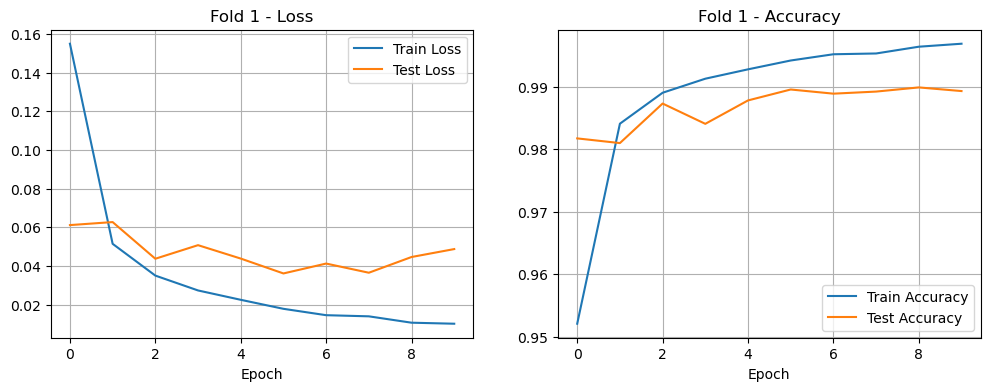

Fold 2/5
Epoch [1/10] - Train Loss: 0.1510
Test Loss: 0.0593 - Test Accuracy: 98.15%

Epoch [2/10] - Train Loss: 0.0507
Test Loss: 0.0521 - Test Accuracy: 98.35%

Epoch [3/10] - Train Loss: 0.0342
Test Loss: 0.0649 - Test Accuracy: 98.18%

Epoch [4/10] - Train Loss: 0.0275
Test Loss: 0.0556 - Test Accuracy: 98.42%

Epoch [5/10] - Train Loss: 0.0208
Test Loss: 0.0438 - Test Accuracy: 98.78%

Epoch [6/10] - Train Loss: 0.0173
Test Loss: 0.0370 - Test Accuracy: 99.00%

Epoch [7/10] - Train Loss: 0.0149
Test Loss: 0.0520 - Test Accuracy: 98.72%

Epoch [8/10] - Train Loss: 0.0122
Test Loss: 0.0558 - Test Accuracy: 98.78%

Epoch [9/10] - Train Loss: 0.0120
Test Loss: 0.0398 - Test Accuracy: 98.98%

Epoch [10/10] - Train Loss: 0.0088
Test Loss: 0.0596 - Test Accuracy: 98.72%

Early stopping en fold 2, epoch 10


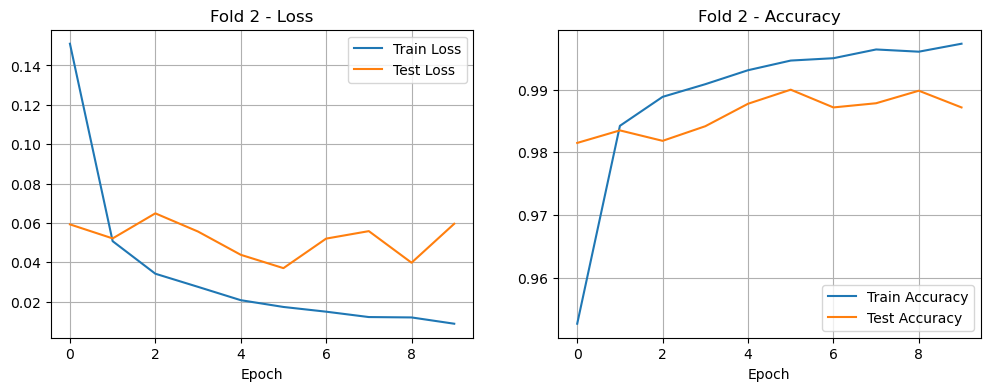

Fold 3/5
Epoch [1/10] - Train Loss: 0.1584
Test Loss: 0.0599 - Test Accuracy: 98.19%

Epoch [2/10] - Train Loss: 0.0521
Test Loss: 0.0429 - Test Accuracy: 98.78%

Epoch [3/10] - Train Loss: 0.0373
Test Loss: 0.0419 - Test Accuracy: 98.78%

Epoch [4/10] - Train Loss: 0.0283
Test Loss: 0.0409 - Test Accuracy: 98.79%

Epoch [5/10] - Train Loss: 0.0235
Test Loss: 0.0398 - Test Accuracy: 98.96%

Epoch [6/10] - Train Loss: 0.0186
Test Loss: 0.0449 - Test Accuracy: 98.79%

Epoch [7/10] - Train Loss: 0.0159
Test Loss: 0.0406 - Test Accuracy: 99.02%

Epoch [8/10] - Train Loss: 0.0141
Test Loss: 0.0481 - Test Accuracy: 98.78%

Epoch [9/10] - Train Loss: 0.0119
Test Loss: 0.0460 - Test Accuracy: 99.00%

Early stopping en fold 3, epoch 9


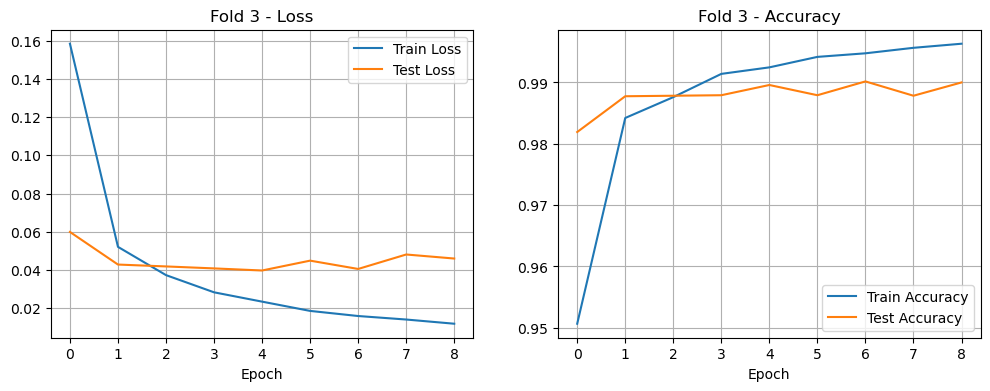

Fold 4/5
Epoch [1/10] - Train Loss: 0.1576
Test Loss: 0.0606 - Test Accuracy: 98.10%

Epoch [2/10] - Train Loss: 0.0502
Test Loss: 0.0428 - Test Accuracy: 98.67%

Epoch [3/10] - Train Loss: 0.0377
Test Loss: 0.0560 - Test Accuracy: 98.42%

Epoch [4/10] - Train Loss: 0.0282
Test Loss: 0.0474 - Test Accuracy: 98.83%

Epoch [5/10] - Train Loss: 0.0243
Test Loss: 0.0389 - Test Accuracy: 98.93%

Epoch [6/10] - Train Loss: 0.0182
Test Loss: 0.0448 - Test Accuracy: 98.92%

Epoch [7/10] - Train Loss: 0.0152
Test Loss: 0.0496 - Test Accuracy: 98.87%

Epoch [8/10] - Train Loss: 0.0126
Test Loss: 0.0512 - Test Accuracy: 98.71%

Epoch [9/10] - Train Loss: 0.0102
Test Loss: 0.0415 - Test Accuracy: 99.05%

Early stopping en fold 4, epoch 9


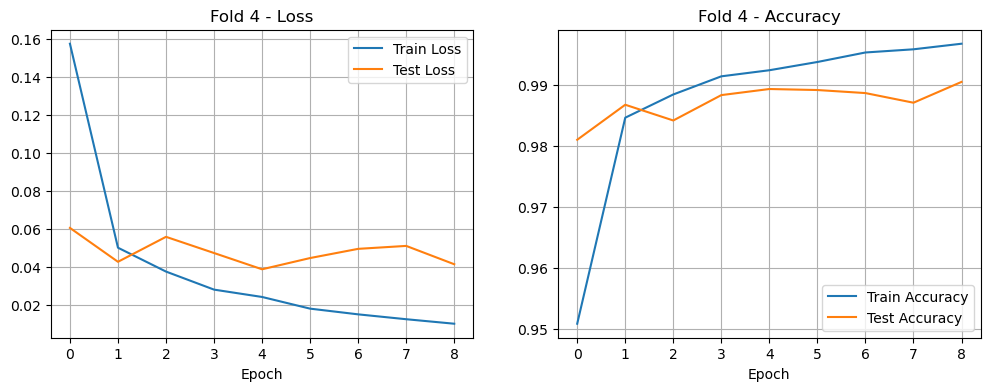

Fold 5/5
Epoch [1/10] - Train Loss: 0.1548
Test Loss: 0.0977 - Test Accuracy: 96.88%

Epoch [2/10] - Train Loss: 0.0487
Test Loss: 0.0527 - Test Accuracy: 98.44%

Epoch [3/10] - Train Loss: 0.0356
Test Loss: 0.0509 - Test Accuracy: 98.50%

Epoch [4/10] - Train Loss: 0.0276
Test Loss: 0.0431 - Test Accuracy: 98.95%

Epoch [5/10] - Train Loss: 0.0227
Test Loss: 0.0432 - Test Accuracy: 98.78%

Epoch [6/10] - Train Loss: 0.0166
Test Loss: 0.0457 - Test Accuracy: 98.89%

Epoch [7/10] - Train Loss: 0.0168
Test Loss: 0.0389 - Test Accuracy: 98.93%

Epoch [8/10] - Train Loss: 0.0128
Test Loss: 0.0473 - Test Accuracy: 98.82%

Epoch [9/10] - Train Loss: 0.0120
Test Loss: 0.0497 - Test Accuracy: 99.12%

Epoch [10/10] - Train Loss: 0.0113
Test Loss: 0.0532 - Test Accuracy: 98.96%



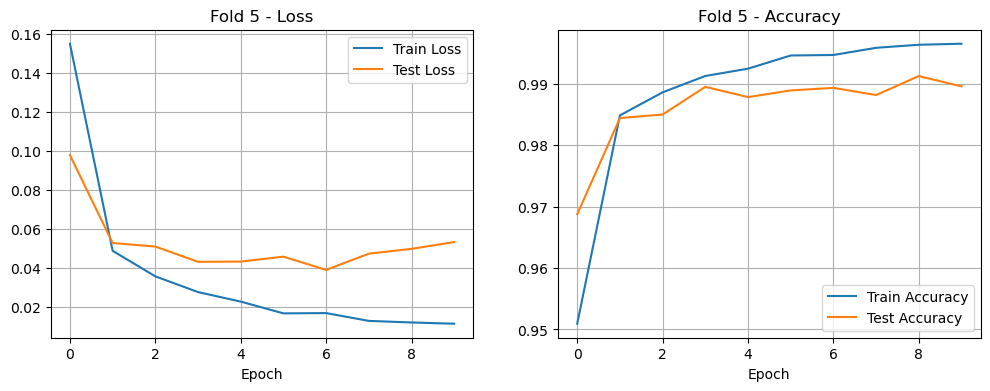

EVALUACION PARA:  0.0001
Fold 1/5
Epoch [1/10] - Train Loss: 0.4028
Test Loss: 0.1525 - Test Accuracy: 95.43%

Epoch [2/10] - Train Loss: 0.1073
Test Loss: 0.0956 - Test Accuracy: 96.88%

Epoch [3/10] - Train Loss: 0.0747
Test Loss: 0.0875 - Test Accuracy: 97.24%

Epoch [4/10] - Train Loss: 0.0595
Test Loss: 0.0609 - Test Accuracy: 98.12%

Epoch [5/10] - Train Loss: 0.0498
Test Loss: 0.0533 - Test Accuracy: 98.29%

Epoch [6/10] - Train Loss: 0.0421
Test Loss: 0.0492 - Test Accuracy: 98.43%

Epoch [7/10] - Train Loss: 0.0365
Test Loss: 0.0450 - Test Accuracy: 98.52%

Epoch [8/10] - Train Loss: 0.0316
Test Loss: 0.0461 - Test Accuracy: 98.56%

Epoch [9/10] - Train Loss: 0.0283
Test Loss: 0.0419 - Test Accuracy: 98.63%

Epoch [10/10] - Train Loss: 0.0242
Test Loss: 0.0373 - Test Accuracy: 98.79%



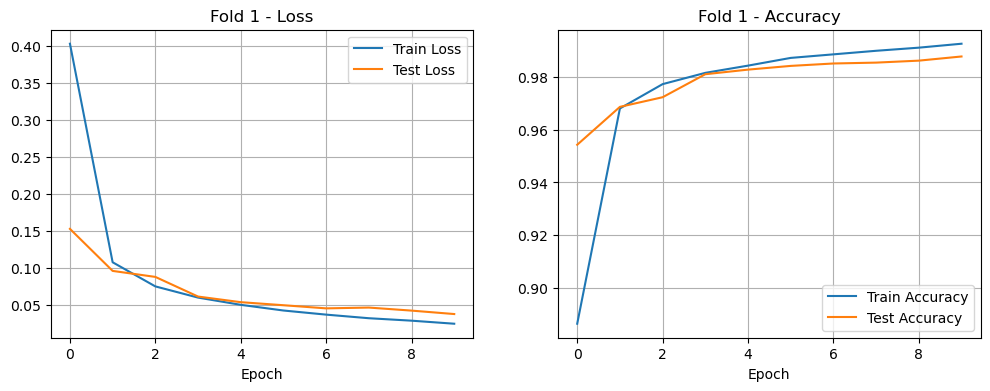

Fold 2/5
Epoch [1/10] - Train Loss: 0.4184
Test Loss: 0.1439 - Test Accuracy: 95.49%

Epoch [2/10] - Train Loss: 0.1139
Test Loss: 0.0894 - Test Accuracy: 97.35%

Epoch [3/10] - Train Loss: 0.0767
Test Loss: 0.0724 - Test Accuracy: 97.79%

Epoch [4/10] - Train Loss: 0.0612
Test Loss: 0.0604 - Test Accuracy: 98.11%

Epoch [5/10] - Train Loss: 0.0501
Test Loss: 0.0626 - Test Accuracy: 98.01%

Epoch [6/10] - Train Loss: 0.0432
Test Loss: 0.0431 - Test Accuracy: 98.61%

Epoch [7/10] - Train Loss: 0.0373
Test Loss: 0.0483 - Test Accuracy: 98.47%

Epoch [8/10] - Train Loss: 0.0327
Test Loss: 0.0408 - Test Accuracy: 98.77%

Epoch [9/10] - Train Loss: 0.0281
Test Loss: 0.0377 - Test Accuracy: 98.79%

Epoch [10/10] - Train Loss: 0.0252
Test Loss: 0.0432 - Test Accuracy: 98.64%



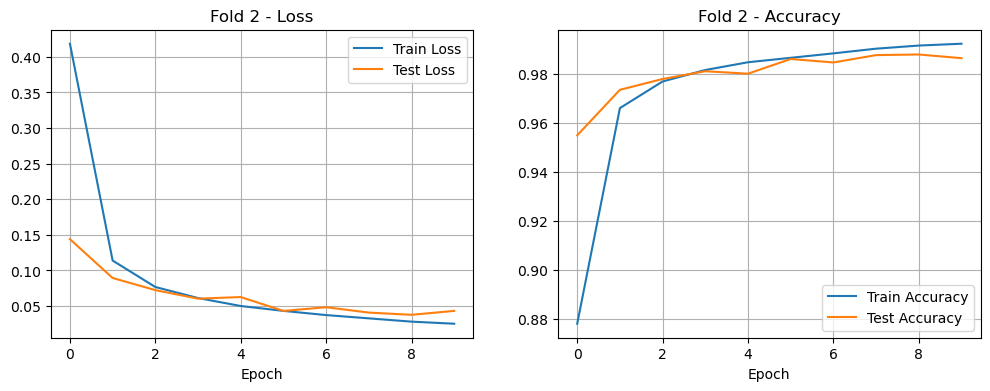

Fold 3/5
Epoch [1/10] - Train Loss: 0.4071
Test Loss: 0.1454 - Test Accuracy: 95.40%

Epoch [2/10] - Train Loss: 0.1101
Test Loss: 0.0813 - Test Accuracy: 97.51%

Epoch [3/10] - Train Loss: 0.0745
Test Loss: 0.0654 - Test Accuracy: 98.03%

Epoch [4/10] - Train Loss: 0.0587
Test Loss: 0.0509 - Test Accuracy: 98.47%

Epoch [5/10] - Train Loss: 0.0498
Test Loss: 0.0480 - Test Accuracy: 98.57%

Epoch [6/10] - Train Loss: 0.0414
Test Loss: 0.0441 - Test Accuracy: 98.68%

Epoch [7/10] - Train Loss: 0.0367
Test Loss: 0.0488 - Test Accuracy: 98.59%

Epoch [8/10] - Train Loss: 0.0320
Test Loss: 0.0362 - Test Accuracy: 98.88%

Epoch [9/10] - Train Loss: 0.0285
Test Loss: 0.0341 - Test Accuracy: 98.90%

Epoch [10/10] - Train Loss: 0.0250
Test Loss: 0.0468 - Test Accuracy: 98.59%



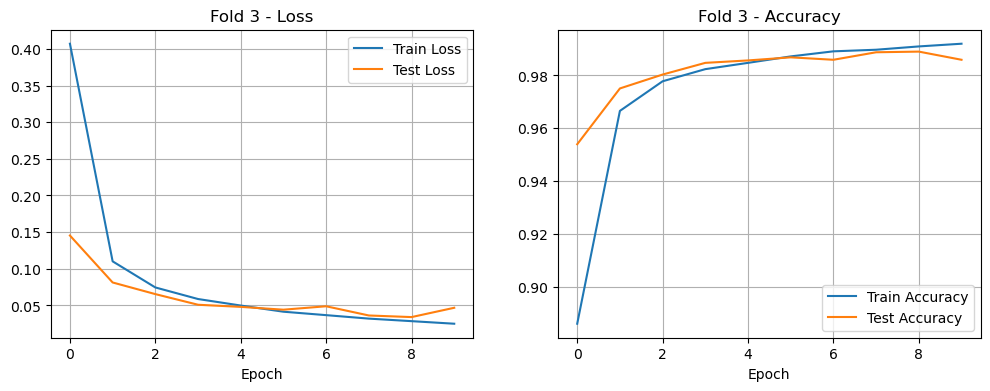

Fold 4/5
Epoch [1/10] - Train Loss: 0.3820
Test Loss: 0.1352 - Test Accuracy: 96.10%

Epoch [2/10] - Train Loss: 0.1067
Test Loss: 0.0844 - Test Accuracy: 97.55%

Epoch [3/10] - Train Loss: 0.0757
Test Loss: 0.0695 - Test Accuracy: 97.95%

Epoch [4/10] - Train Loss: 0.0603
Test Loss: 0.0560 - Test Accuracy: 98.22%

Epoch [5/10] - Train Loss: 0.0504
Test Loss: 0.0466 - Test Accuracy: 98.59%

Epoch [6/10] - Train Loss: 0.0425
Test Loss: 0.0427 - Test Accuracy: 98.72%

Epoch [7/10] - Train Loss: 0.0367
Test Loss: 0.0428 - Test Accuracy: 98.69%

Epoch [8/10] - Train Loss: 0.0327
Test Loss: 0.0439 - Test Accuracy: 98.74%

Epoch [9/10] - Train Loss: 0.0281
Test Loss: 0.0372 - Test Accuracy: 98.87%

Epoch [10/10] - Train Loss: 0.0251
Test Loss: 0.0352 - Test Accuracy: 98.90%



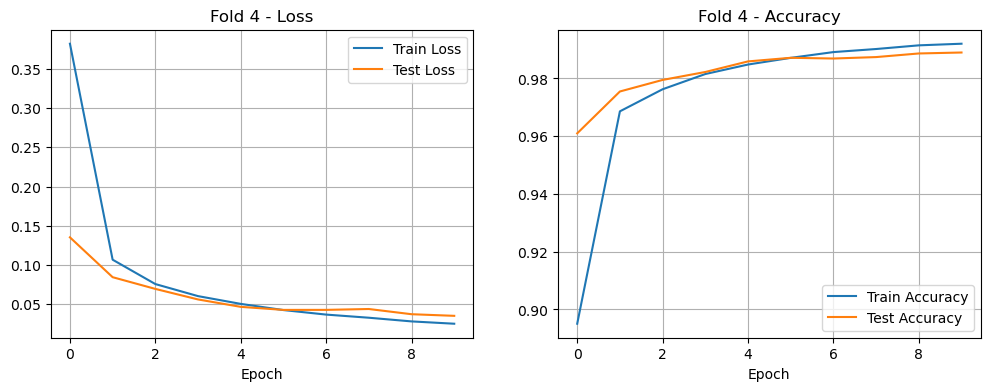

Fold 5/5
Epoch [1/10] - Train Loss: 0.3965
Test Loss: 0.1420 - Test Accuracy: 95.82%

Epoch [2/10] - Train Loss: 0.1155
Test Loss: 0.1137 - Test Accuracy: 96.58%

Epoch [3/10] - Train Loss: 0.0797
Test Loss: 0.0736 - Test Accuracy: 97.82%

Epoch [4/10] - Train Loss: 0.0621
Test Loss: 0.0603 - Test Accuracy: 98.23%

Epoch [5/10] - Train Loss: 0.0514
Test Loss: 0.0504 - Test Accuracy: 98.51%

Epoch [6/10] - Train Loss: 0.0444
Test Loss: 0.0485 - Test Accuracy: 98.48%

Epoch [7/10] - Train Loss: 0.0377
Test Loss: 0.0443 - Test Accuracy: 98.68%

Epoch [8/10] - Train Loss: 0.0335
Test Loss: 0.0403 - Test Accuracy: 98.71%

Epoch [9/10] - Train Loss: 0.0300
Test Loss: 0.0407 - Test Accuracy: 98.83%

Epoch [10/10] - Train Loss: 0.0264
Test Loss: 0.0405 - Test Accuracy: 98.88%



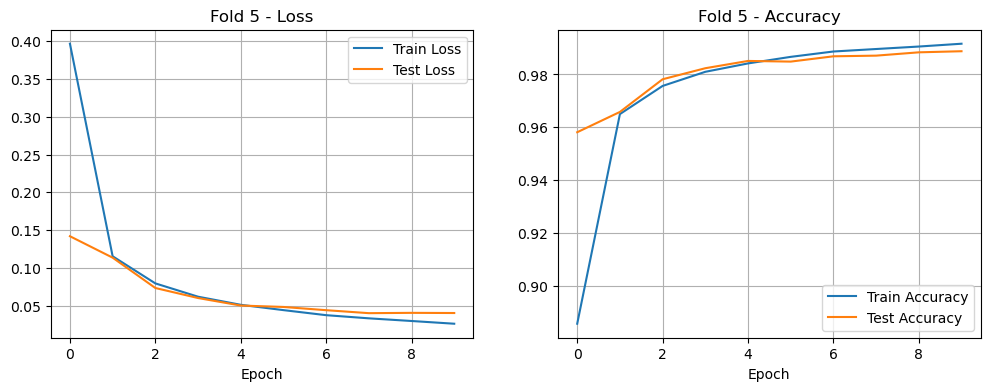

Mejor valor de learning_rate: 0.001
Mejor precisión promedio: 0.9886145833333334


In [14]:
import numpy as np
from sklearn.model_selection import KFold


learning_rates = [0.001, 0.0001] # valores a buscar 


best_hparams = {} # variable para almacenar los mejores parametros
best_mean_accuracy = 0.0

for learning_rate in learning_rates: # se iterapor los valores disponibles 
    print('EVALUACION PARA: ', learning_rate)
    aux1,aux3,aux2,aux4 = train_learningrate(train_std, trainyy,learning_rate=learning_rate) # realiza la búsqueda para el valor respectivo de learning_rate
    mean_accuracy = np.mean([np.max(accuracies) for accuracies in aux3]) # calcula el promedio de la precisión en todos los pliegues
    # verifica si este valor de learning_rate es el mejor hasta ahora
    if mean_accuracy > best_mean_accuracy:
        best_mean_accuracy = mean_accuracy
        best_hparams = {
            'learning_rate': learning_rate
        }


print("Mejor valor de learning_rate:", best_hparams['learning_rate'])   
print("Mejor precisión promedio:", best_mean_accuracy)


Nos llamo la atencion que el algoritmo nos haya arrojado el valor 0,001 

cuando en sus graficas respectivas las curvas de loss tienen una tendencia

a subir, como si fuera un indicio de overfitting, por otro lado, en el valor

0,0001 sus graficas de entrenamientos suelen ser con un aprendizaje mas constante

o estable estando bastante cerca una de la otra como en el loss. Por lo que tomamos

la decision de ver el impacto que tiene el valor 0,0001 en nuestro modelo normalizado

por la estandarizacion para luego tomar una decision respecto a este punto.


Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])
Fold 1/5
Epoch [1/10] - Train Loss: 0.3837
Test Loss: 0.1273 - Test Accuracy: 95.88%

Epoch [2/10] - Train Loss: 0.1095
Test Loss: 0.0811 - Test Accuracy: 97.44%

Epoch [3/10] - Train Loss: 0.0760
Test Loss: 0.0632 - Test Accuracy: 97.99%

Epoch [4/10] - Train Loss: 0.0599
Test Loss: 0.0500 - Test Accuracy: 98.32%

Epoch [5/10] - Train Loss: 0.0495
Test Loss: 0.0538 - Test Accuracy: 98.18%

Epoch [6/10] - Train Loss: 0.0425
Test Loss: 0.0465 - Test Accuracy: 98.62%

Epoch [7/10] - Train Loss: 0.0370
Test Loss: 0.0461 - Test Accuracy: 98.54%

Epoch [8/10] - Train Loss: 0.0322
Test Loss: 0.0424 - Test Accuracy: 98.68%

Epoch [9/10] - Train Loss: 0.0282
Test Loss: 0.0433 - Test Accuracy: 98.65%

Epoch [10/10] - Train Loss: 0.0247
Test Loss: 0.0318 - Test Accuracy: 98.90%

Recall - Fold 1:
Class 0: Re

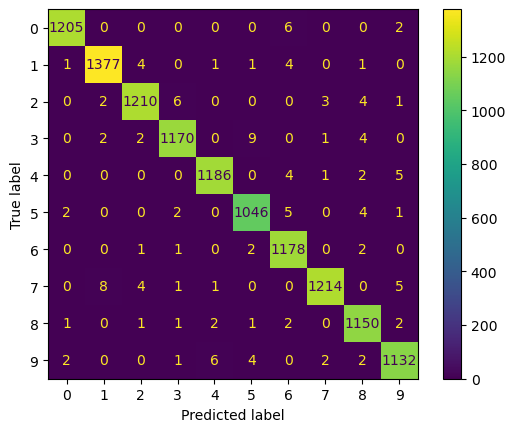

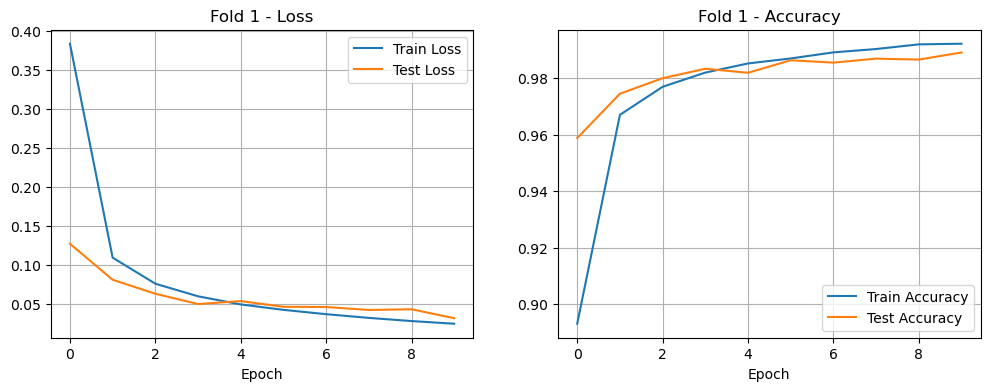

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 0.3974
Test Loss: 0.1367 - Test Accuracy: 95.91%

Epoch [2/10] - Train Loss: 0.1122
Test Loss: 0.1040 - Test Accuracy: 96.95%

Epoch [3/10] - Train Loss: 0.0781
Test Loss: 0.0982 - Test Accuracy: 97.02%

Epoch [4/10] - Train Loss: 0.0611
Test Loss: 0.0666 - Test Accuracy: 98.09%

Epoch [5/10] - Train Loss: 0.0505
Test Loss: 0.0588 - Test Accuracy: 98.30%

Epoch [6/10] - Train Loss: 0.0437
Test Loss: 0.0556 - Test Accuracy: 98.38%

Epoch [7/10] - Train Loss: 0.0369
Test Loss: 0.0518 - Test Accuracy: 98.59%

Epoch [8/10] - Train Loss: 0.0333
Test Loss: 0.0506 - Test Accuracy: 98.44%

Epoch [9/10] - Train Loss: 0.0288
Test Loss: 0.0483 - Test Accuracy: 98.68%

Epoch [10/10] - Train Loss: 0.0249
Test Loss: 0.0453 - Test Accuracy: 98.76%

Recall - Fold 2:
Class 0: Recall = 0.9991
Class 1: Recall = 0.9910
Class 2: Recall = 0.9862
Class 3: Recall = 0.9798
Class 4: Recall = 0.9841
Class 5: Recall = 0.9885
Class 6: Reca

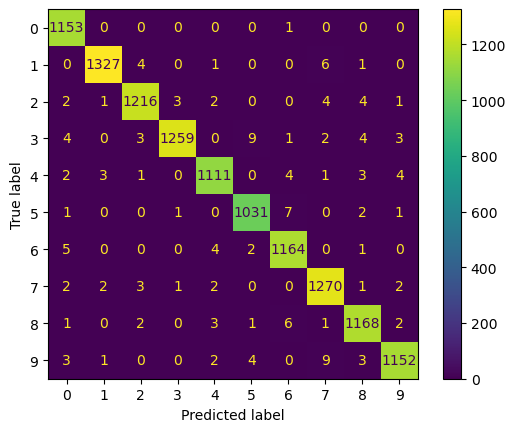

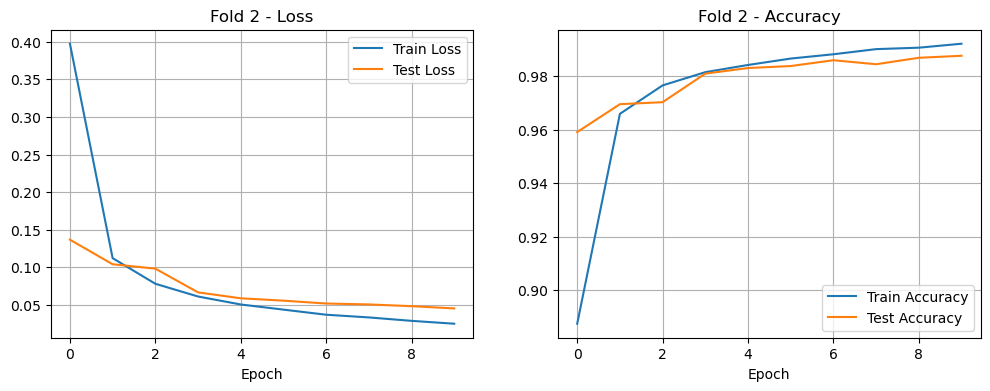

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 0.4105
Test Loss: 0.1567 - Test Accuracy: 95.32%

Epoch [2/10] - Train Loss: 0.1130
Test Loss: 0.0947 - Test Accuracy: 97.12%

Epoch [3/10] - Train Loss: 0.0764
Test Loss: 0.0800 - Test Accuracy: 97.58%

Epoch [4/10] - Train Loss: 0.0592
Test Loss: 0.0572 - Test Accuracy: 98.28%

Epoch [5/10] - Train Loss: 0.0487
Test Loss: 0.0528 - Test Accuracy: 98.34%

Epoch [6/10] - Train Loss: 0.0402
Test Loss: 0.0500 - Test Accuracy: 98.50%

Epoch [7/10] - Train Loss: 0.0351
Test Loss: 0.0469 - Test Accuracy: 98.67%

Epoch [8/10] - Train Loss: 0.0314
Test Loss: 0.0449 - Test Accuracy: 98.58%

Epoch [9/10] - Train Loss: 0.0271
Test Loss: 0.0403 - Test Accuracy: 98.83%

Epoch [10/10] - Train Loss: 0.0234
Test Loss: 0.0391 - Test Accuracy: 98.87%

Recall - Fold 3:
Class 0: Recall = 0.9919
Class 1: Recall = 0.9954
Class 2: Recall = 0.9865
Class 3: Recall = 0.9891
Class 4: Recall = 0.9819
Class 5: Recall = 0.9930
Class 6: Reca

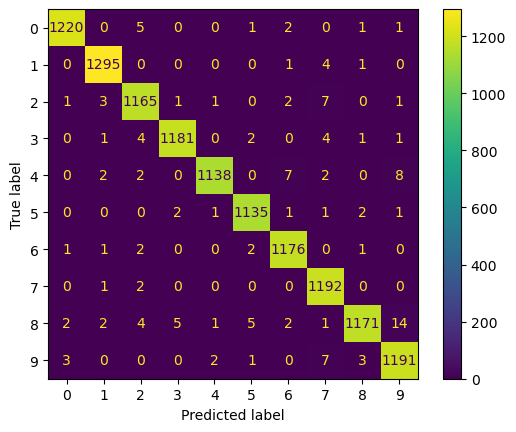

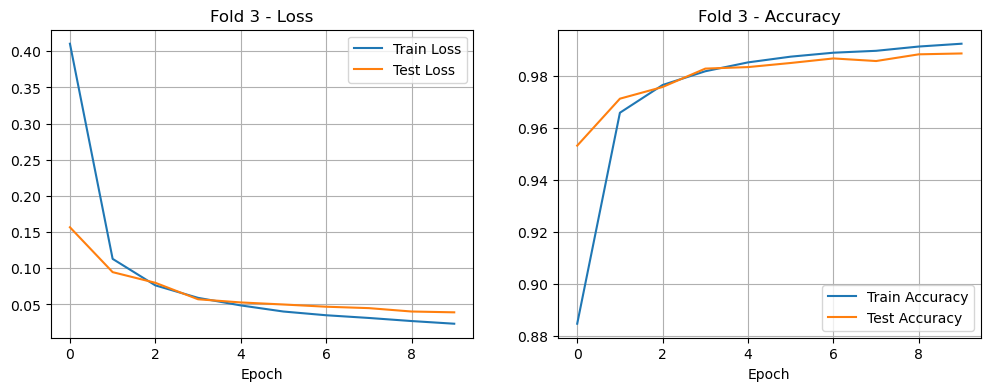

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 0.4034
Test Loss: 0.1505 - Test Accuracy: 95.51%

Epoch [2/10] - Train Loss: 0.1131
Test Loss: 0.0951 - Test Accuracy: 97.23%

Epoch [3/10] - Train Loss: 0.0780
Test Loss: 0.0785 - Test Accuracy: 97.62%

Epoch [4/10] - Train Loss: 0.0620
Test Loss: 0.0637 - Test Accuracy: 98.07%

Epoch [5/10] - Train Loss: 0.0510
Test Loss: 0.0589 - Test Accuracy: 98.18%

Epoch [6/10] - Train Loss: 0.0435
Test Loss: 0.0462 - Test Accuracy: 98.59%

Epoch [7/10] - Train Loss: 0.0367
Test Loss: 0.0492 - Test Accuracy: 98.47%

Epoch [8/10] - Train Loss: 0.0322
Test Loss: 0.0421 - Test Accuracy: 98.73%

Epoch [9/10] - Train Loss: 0.0279
Test Loss: 0.0504 - Test Accuracy: 98.47%

Epoch [10/10] - Train Loss: 0.0243
Test Loss: 0.0472 - Test Accuracy: 98.66%

Recall - Fold 4:
Class 0: Recall = 0.9907
Class 1: Recall = 0.9897
Class 2: Recall = 0.9965
Class 3: Recall = 0.9853
Class 4: Recall = 0.9877
Class 5: Recall = 0.9821
Class 6: Reca

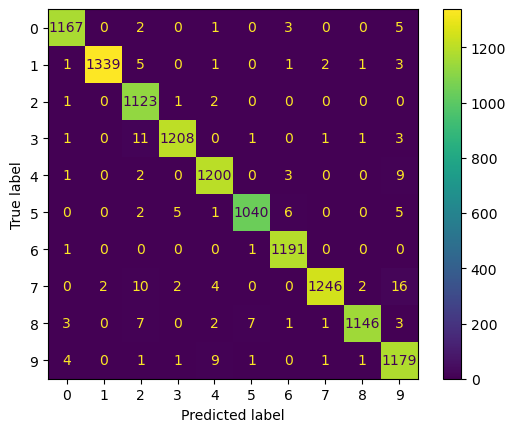

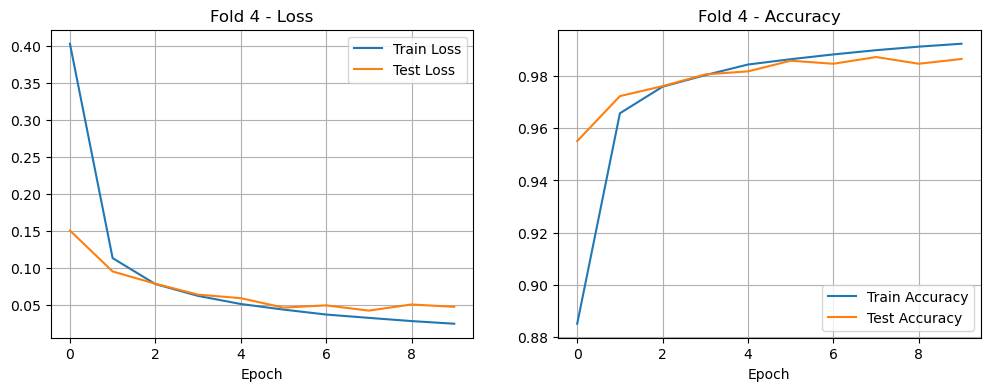

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 0.3975
Test Loss: 0.1309 - Test Accuracy: 96.14%

Epoch [2/10] - Train Loss: 0.1103
Test Loss: 0.0847 - Test Accuracy: 97.53%

Epoch [3/10] - Train Loss: 0.0765
Test Loss: 0.0620 - Test Accuracy: 98.19%

Epoch [4/10] - Train Loss: 0.0615
Test Loss: 0.0518 - Test Accuracy: 98.41%

Epoch [5/10] - Train Loss: 0.0507
Test Loss: 0.0486 - Test Accuracy: 98.49%

Epoch [6/10] - Train Loss: 0.0427
Test Loss: 0.0416 - Test Accuracy: 98.72%

Epoch [7/10] - Train Loss: 0.0373
Test Loss: 0.0394 - Test Accuracy: 98.77%

Epoch [8/10] - Train Loss: 0.0325
Test Loss: 0.0381 - Test Accuracy: 98.81%

Epoch [9/10] - Train Loss: 0.0292
Test Loss: 0.0347 - Test Accuracy: 98.90%

Epoch [10/10] - Train Loss: 0.0254
Test Loss: 0.0353 - Test Accuracy: 98.86%

Recall - Fold 5:
Class 0: Recall = 0.9922
Class 1: Recall = 0.9956
Class 2: Recall = 0.9916
Class 3: Recall = 0.9766
Class 4: Recall = 0.9851
Class 5: Recall = 0.9928
Class 6: Reca

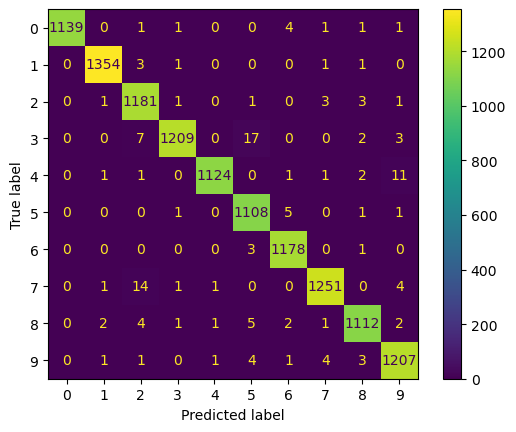

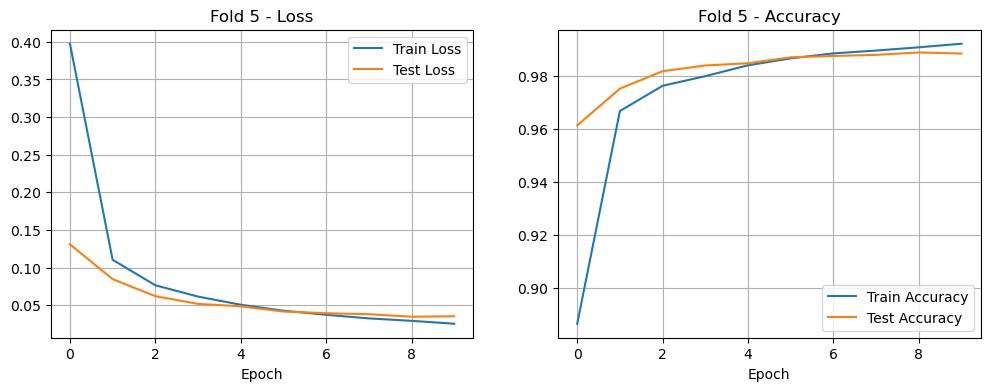

MODELO TERMINADO!!!!
------------------
... Modelo evaluado !!


In [6]:
def estandarizacion(train, test):
    # Calcula la media y la desviación estándar de los datos de entrenamiento
    mean = torch.mean(train)
    std = torch.std(train)

    # Aplica la estandarización a los datos de entrenamiento y prueba
    train_std = (train - mean) / std
    test_std = (test - mean) / std

    return train_std, test_std

trainxx, trainyy, testxx, testyy = load_dataset() # cargo datos 
train_std , test_std = estandarizacion(trainxx, testxx) # aplica normalizacion 
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy = train_model_kfold(train_std, trainyy) # se entrena el modelo con lr=0.0001
print ("... Modelo evaluado !!")

La mejora en el entrenamiento es bastante notoria, reduciendo o quitando el overfitting como tal y
teniendo un entrenamiento muy estable y constante 

MODIFICACION DEL MODELO PARA AGREGAR MAS PROFUNDIDAD

In [5]:
class red_modificada(nn.Module):
    def __init__(self,transforms=None, dropout_prob=0.5): # variable dropout se preocupa de regular las neuronas 
        super(red_modificada,self).__init__()
        
        self.transform = transforms
        self.conv1 = nn.Conv2d(1, 32, 3)   #creamos capas convolucionales 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)  
        self.conv4 = nn.Conv2d(64,128,3)  # añadimos capas
        

        self.fc1 = nn.Linear(1152,256) #41472 caracteristicas esperadas por el modelo 
        self.fc2 = nn.Linear(256,100)
        self.fc3 = nn.Linear(100,10) # capa densa añadida
        

        self.dropout = nn.Dropout(p=dropout_prob) 
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),1))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # Todas las dimensiones excepto la del batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [5]:
def show_images(images, labels): # funcion adicional para poder ver las transformaciones de las imagenes y la normalizacion 
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))  # Reorganiza las dimensiones de la imagen
        axes[i].set_title(f"{labels[i]}")
        axes[i].axis('off')
    plt.show()

In [4]:
def train_model_kfold2(trainx, trainy,patience=3,n_folds=5):
    scores, histories, recalls = list(), list(), list()
    
    batch_size = 32
    learning_rate = 0.0001
    num_epochs = 10
   
    # objeto para dividir los datos en n pliegues 
    kfold = KFold(n_splits=n_folds, shuffle=True)

    # itera a través de los pliegues de validación cruzada
    for fold, (train_indices, test_indices) in enumerate(kfold.split(trainx)):
        print(f"Fold {fold + 1}/{n_folds}")
        
        # aqui se divide los datos en conjuntos de entrenamiento y prueba para el fold respectivo 
        train_data, test_data = trainx[train_indices], trainx[test_indices]
        train_labels, test_labels = trainy[train_indices], trainy[test_indices]

        # Crea dataloaders para entrenamiento y prueba para el fold respectivo 
        train_loader = torch.utils.data.DataLoader(dataset=CustomDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=CustomDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

        # Inicializa el modelo y el optimizador
        model = red_modificada().to('cuda') # modelo en la gpu 
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        aux1 = [] # lista para obtener los errores del train
        aux2 = [] # lista para obtener los errores del test 

        aux3 = [] # lista para obtener accuracy del data train 
        aux4 = [] # lista para obtener accuracy del data test 

        best_val_loss=2
        # Entrena el modelo
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train(model, train_loader, criterion, optimizer) # en este momento se entrena el modelo por epocas 
            aux1.append(train_loss) # lista de errores en data train
            aux3.append(train_accuracy) # lista de accuracy en data train
            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

            # Evalúa el modelo en el conjunto de prueba
            test_loss, test_accuracy = evaluate(model, test_loader, criterion)# se llama a la funcion para evaluar el modelo y obtener el error y accuracy por epocas
            print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2%}\n")
            aux2.append(test_loss) # lista para obtener los errores del data test 
            
            aux4.append(test_accuracy) # lista de accuracy en data test 
            
            #implemento early stopping 
            if test_loss < best_val_loss: #comparacion simple de variables
                best_val_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                
            if no_improvement_count >= patience:
                print(f"Early stopping en fold {fold + 1}, epoch {epoch + 1}")
                break
        
        y_true = test_labels # variables true reales 
        y_pred = predict(model, test_loader)   # prediccion del modelo         
        report = classification_report(y_true, y_pred, output_dict=True)
        #Calcular y mostrar el recall
        print(f'Recall - Fold {fold + 1}:')
        for class_name, recall_value in report.items(): # itero la variable de recall en report.items()
            if class_name.isdigit():
                print(f'Class {class_name}: Recall = {recall_value["recall"]:.4f}')

        # calcular y mostrar valores F1 
        print(f'Valor F1 - Fold {fold + 1}:')
        for class_name, f1_value in report.items():
            if class_name.isdigit():
                print(f'Class {class_name}: F1-Score = {f1_value["f1-score"]:.4f}')

        
     

       
        recalls.append(report)  # Almacena el reporte de clasificación
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = None)
        cm_display.plot()
        plt.show()

        visualization_curves(aux1,aux3,aux2,aux4,fold)  

        print("MODELO TERMINADO!!!!")
        print('------------------')
        
      
       
    
    return aux1,aux3,aux2,aux4 # loss-train, accuracy-train, loss-test, accuracy-test


In [5]:
def estandarizacion(train, test):
    # Calcula la media y la desviación estándar de los datos de entrenamiento
    mean = torch.mean(train)
    std = torch.std(train)

    # Aplica la estandarización a los datos de entrenamiento y prueba
    train_std = (train - mean) / std
    test_std = (test - mean) / std

    return train_std, test_std

In [6]:
trainxx, trainyy, testxx, testyy = load_dataset() # cargo los datos 

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])


In [7]:
train_std , test_std = estandarizacion(trainxx, testxx) # aplicamos la normalizacion de datos 

In [8]:
for i in range(10):             #comprobamos datos 
    print(train_std[i].min(),train_std[i].max())

tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)
tensor(-0.4241) tensor(2.8215)


se aplica un dropout de 0.5 para reducir el overfitting


Fold 1/5
Epoch [1/10] - Train Loss: 0.3963
Test Loss: 0.1222 - Test Accuracy: 96.06%

Epoch [2/10] - Train Loss: 0.1079
Test Loss: 0.0769 - Test Accuracy: 97.67%

Epoch [3/10] - Train Loss: 0.0729
Test Loss: 0.0592 - Test Accuracy: 98.34%

Epoch [4/10] - Train Loss: 0.0577
Test Loss: 0.0506 - Test Accuracy: 98.44%

Epoch [5/10] - Train Loss: 0.0460
Test Loss: 0.0477 - Test Accuracy: 98.71%

Epoch [6/10] - Train Loss: 0.0390
Test Loss: 0.0479 - Test Accuracy: 98.72%

Epoch [7/10] - Train Loss: 0.0322
Test Loss: 0.0451 - Test Accuracy: 98.70%

Epoch [8/10] - Train Loss: 0.0295
Test Loss: 0.0399 - Test Accuracy: 98.72%

Epoch [9/10] - Train Loss: 0.0251
Test Loss: 0.0392 - Test Accuracy: 98.89%

Epoch [10/10] - Train Loss: 0.0211
Test Loss: 0.0409 - Test Accuracy: 98.97%

Recall - Fold 1:
Class 0: Recall = 0.9939
Class 1: Recall = 0.9955
Class 2: Recall = 0.9948
Class 3: Recall = 0.9928
Class 4: Recall = 0.9890
Class 5: Recall = 0.9945
Class 6: Recall = 0.9885
Class 7: Recall = 0.9869
Cla

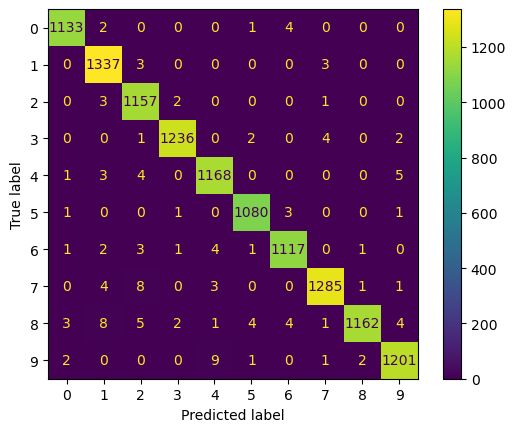

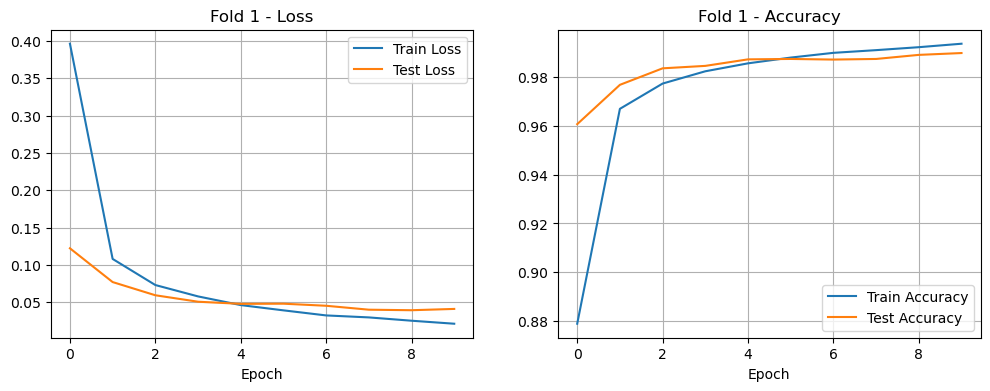

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 0.4142
Test Loss: 0.1209 - Test Accuracy: 96.23%

Epoch [2/10] - Train Loss: 0.1104
Test Loss: 0.0840 - Test Accuracy: 97.51%

Epoch [3/10] - Train Loss: 0.0715
Test Loss: 0.0608 - Test Accuracy: 98.22%

Epoch [4/10] - Train Loss: 0.0596
Test Loss: 0.0513 - Test Accuracy: 98.47%

Epoch [5/10] - Train Loss: 0.0476
Test Loss: 0.0392 - Test Accuracy: 98.81%

Epoch [6/10] - Train Loss: 0.0401
Test Loss: 0.0372 - Test Accuracy: 98.89%

Epoch [7/10] - Train Loss: 0.0347
Test Loss: 0.0346 - Test Accuracy: 99.00%

Epoch [8/10] - Train Loss: 0.0282
Test Loss: 0.0381 - Test Accuracy: 98.89%

Epoch [9/10] - Train Loss: 0.0256
Test Loss: 0.0365 - Test Accuracy: 98.89%

Epoch [10/10] - Train Loss: 0.0230
Test Loss: 0.0318 - Test Accuracy: 98.97%

Recall - Fold 2:
Class 0: Recall = 0.9948
Class 1: Recall = 0.9925
Class 2: Recall = 0.9852
Class 3: Recall = 0.9871
Class 4: Recall = 0.9876
Class 5: Recall = 0.9935
Class 6: Reca

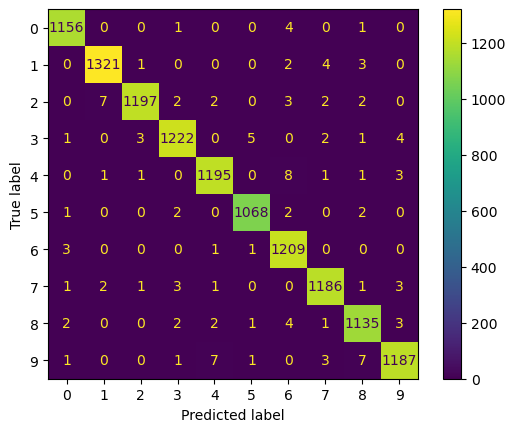

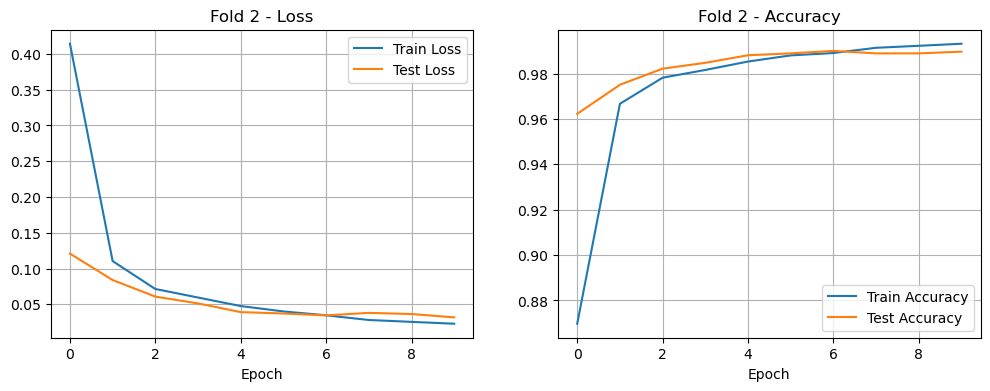

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 0.4102
Test Loss: 0.1019 - Test Accuracy: 96.83%

Epoch [2/10] - Train Loss: 0.1074
Test Loss: 0.0647 - Test Accuracy: 98.08%

Epoch [3/10] - Train Loss: 0.0767
Test Loss: 0.0475 - Test Accuracy: 98.48%

Epoch [4/10] - Train Loss: 0.0562
Test Loss: 0.0452 - Test Accuracy: 98.61%

Epoch [5/10] - Train Loss: 0.0475
Test Loss: 0.0449 - Test Accuracy: 98.66%

Epoch [6/10] - Train Loss: 0.0379
Test Loss: 0.0395 - Test Accuracy: 98.86%

Epoch [7/10] - Train Loss: 0.0341
Test Loss: 0.0319 - Test Accuracy: 99.02%

Epoch [8/10] - Train Loss: 0.0279
Test Loss: 0.0336 - Test Accuracy: 99.02%

Epoch [9/10] - Train Loss: 0.0238
Test Loss: 0.0348 - Test Accuracy: 98.88%

Epoch [10/10] - Train Loss: 0.0217
Test Loss: 0.0290 - Test Accuracy: 99.17%

Recall - Fold 3:
Class 0: Recall = 0.9991
Class 1: Recall = 1.0000
Class 2: Recall = 0.9926
Class 3: Recall = 0.9896
Class 4: Recall = 0.9886
Class 5: Recall = 0.9851
Class 6: Reca

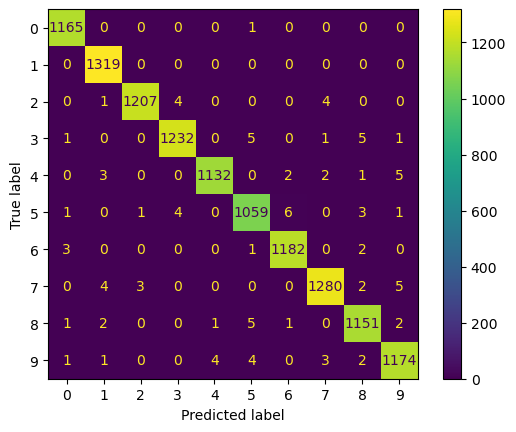

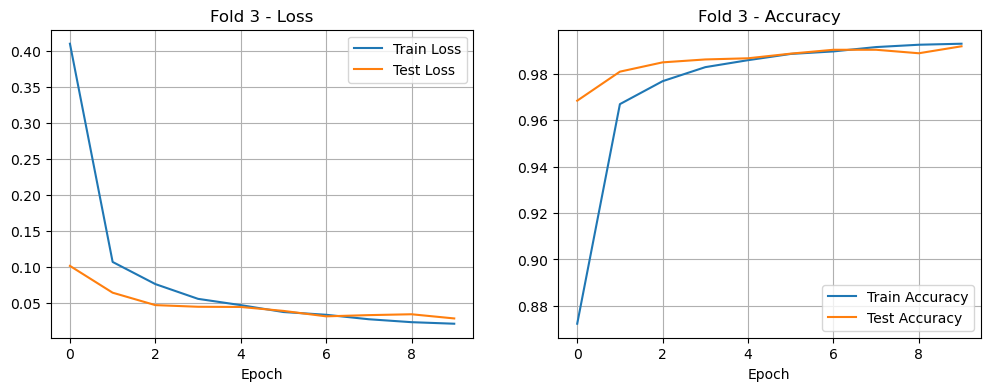

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 0.4011
Test Loss: 0.1003 - Test Accuracy: 96.86%

Epoch [2/10] - Train Loss: 0.1095
Test Loss: 0.0572 - Test Accuracy: 98.30%

Epoch [3/10] - Train Loss: 0.0733
Test Loss: 0.0474 - Test Accuracy: 98.52%

Epoch [4/10] - Train Loss: 0.0563
Test Loss: 0.0465 - Test Accuracy: 98.66%

Epoch [5/10] - Train Loss: 0.0473
Test Loss: 0.0365 - Test Accuracy: 98.88%

Epoch [6/10] - Train Loss: 0.0408
Test Loss: 0.0363 - Test Accuracy: 98.89%

Epoch [7/10] - Train Loss: 0.0319
Test Loss: 0.0378 - Test Accuracy: 98.87%

Epoch [8/10] - Train Loss: 0.0290
Test Loss: 0.0326 - Test Accuracy: 99.02%

Epoch [9/10] - Train Loss: 0.0252
Test Loss: 0.0311 - Test Accuracy: 99.07%

Epoch [10/10] - Train Loss: 0.0213
Test Loss: 0.0359 - Test Accuracy: 98.92%

Recall - Fold 4:
Class 0: Recall = 0.9951
Class 1: Recall = 0.9935
Class 2: Recall = 0.9866
Class 3: Recall = 0.9901
Class 4: Recall = 0.9879
Class 5: Recall = 0.9839
Class 6: Reca

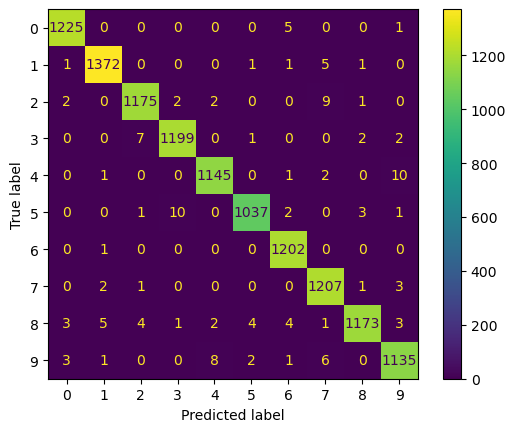

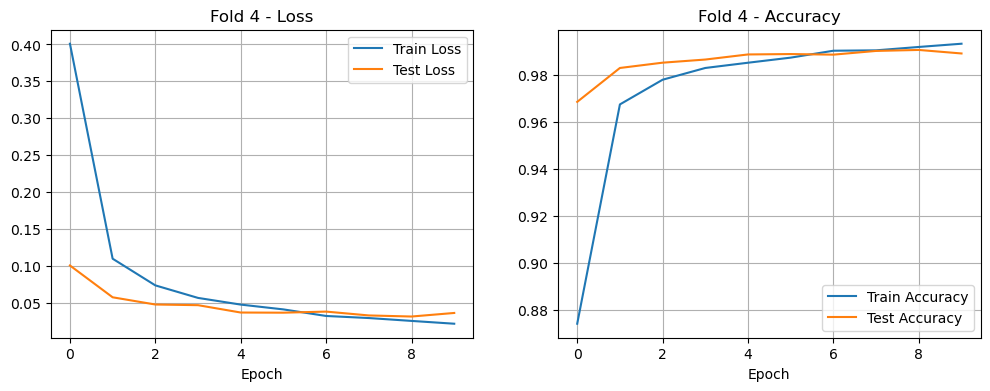

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 0.4056
Test Loss: 0.1121 - Test Accuracy: 96.42%

Epoch [2/10] - Train Loss: 0.1080
Test Loss: 0.0605 - Test Accuracy: 98.12%

Epoch [3/10] - Train Loss: 0.0745
Test Loss: 0.0482 - Test Accuracy: 98.42%

Epoch [4/10] - Train Loss: 0.0592
Test Loss: 0.0407 - Test Accuracy: 98.70%

Epoch [5/10] - Train Loss: 0.0498
Test Loss: 0.0340 - Test Accuracy: 98.89%

Epoch [6/10] - Train Loss: 0.0404
Test Loss: 0.0377 - Test Accuracy: 98.72%

Epoch [7/10] - Train Loss: 0.0362
Test Loss: 0.0338 - Test Accuracy: 99.00%

Epoch [8/10] - Train Loss: 0.0286
Test Loss: 0.0297 - Test Accuracy: 99.07%

Epoch [9/10] - Train Loss: 0.0256
Test Loss: 0.0265 - Test Accuracy: 99.20%

Epoch [10/10] - Train Loss: 0.0233
Test Loss: 0.0266 - Test Accuracy: 99.29%

Recall - Fold 5:
Class 0: Recall = 0.9967
Class 1: Recall = 0.9963
Class 2: Recall = 0.9881
Class 3: Recall = 0.9899
Class 4: Recall = 0.9983
Class 5: Recall = 0.9947
Class 6: Reca

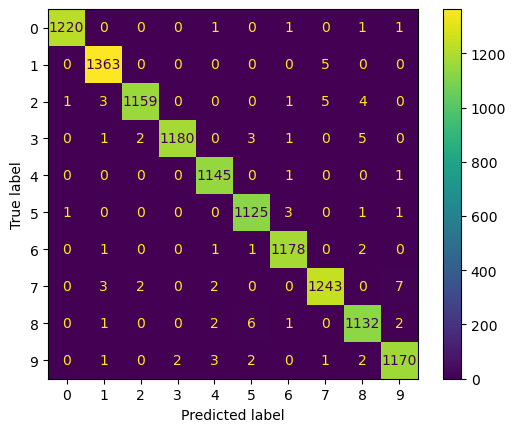

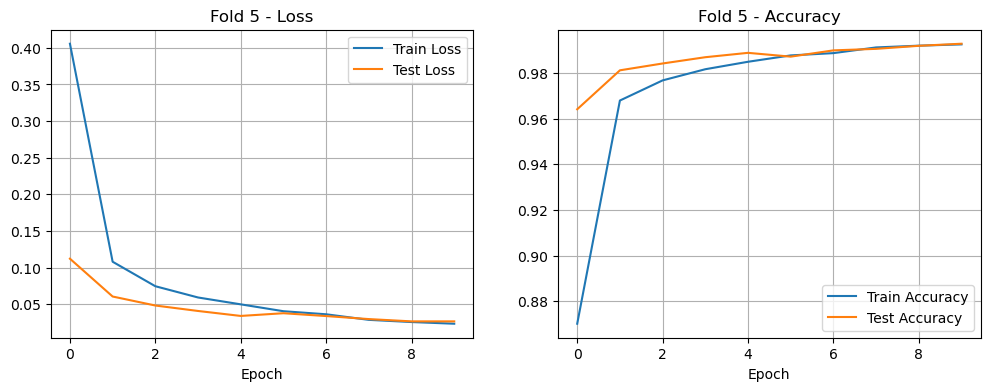

MODELO TERMINADO!!!!
------------------


In [16]:
class red_modificada(nn.Module):
    def __init__(self,transforms=None, dropout_prob=0.5): # variable dropout se preocupa de regular las neuronas 
        super(red_modificada,self).__init__()
        
        self.transform = transforms
        self.conv1 = nn.Conv2d(1, 32, 3)   #creamos capas convolucionales 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)  
        self.conv4 = nn.Conv2d(64,128,3)  # añadimos capas
        

        self.fc1 = nn.Linear(1152,256) #41472 caracteristicas esperadas por el modelo 
        self.fc2 = nn.Linear(256,100)
        self.fc3 = nn.Linear(100,10) # capa densa añadida
        

        self.dropout = nn.Dropout(p=dropout_prob) 
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),1))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # Todas las dimensiones excepto la del batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy=train_model_kfold2(train_std,trainyy)

Despues de obtener estos resultados se hara una comparacion sin dropout para verificar si es necesario o no.
Todos los resultados estan organizados en el excel para una mejora visualizacion.


Fold 1/5
Epoch [1/10] - Train Loss: 0.3207
Test Loss: 0.0981 - Test Accuracy: 97.02%

Epoch [2/10] - Train Loss: 0.0767
Test Loss: 0.0538 - Test Accuracy: 98.26%

Epoch [3/10] - Train Loss: 0.0540
Test Loss: 0.0454 - Test Accuracy: 98.64%

Epoch [4/10] - Train Loss: 0.0404
Test Loss: 0.0446 - Test Accuracy: 98.61%

Epoch [5/10] - Train Loss: 0.0319
Test Loss: 0.0421 - Test Accuracy: 98.62%

Epoch [6/10] - Train Loss: 0.0266
Test Loss: 0.0291 - Test Accuracy: 99.08%

Epoch [7/10] - Train Loss: 0.0214
Test Loss: 0.0361 - Test Accuracy: 98.80%

Epoch [8/10] - Train Loss: 0.0182
Test Loss: 0.0261 - Test Accuracy: 99.17%

Epoch [9/10] - Train Loss: 0.0150
Test Loss: 0.0243 - Test Accuracy: 99.28%

Epoch [10/10] - Train Loss: 0.0121
Test Loss: 0.0345 - Test Accuracy: 98.93%

Recall - Fold 1:
Class 0: Recall = 1.0000
Class 1: Recall = 0.9933
Class 2: Recall = 0.9959
Class 3: Recall = 0.9925
Class 4: Recall = 0.9829
Class 5: Recall = 0.9868
Class 6: Recall = 0.9870
Class 7: Recall = 0.9685
Cla

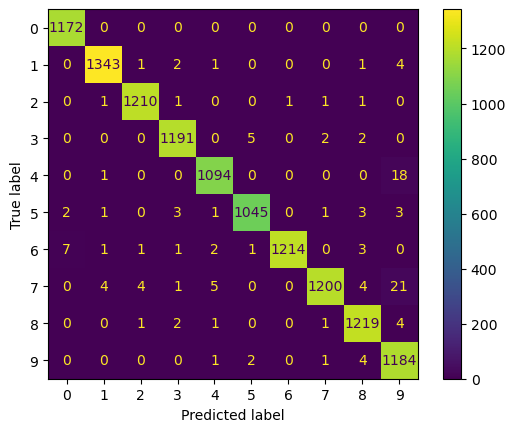

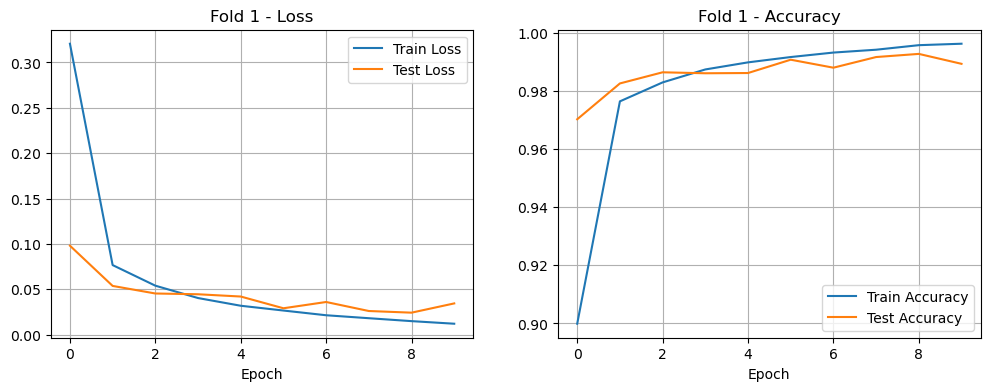

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 0.3284
Test Loss: 0.1115 - Test Accuracy: 96.65%

Epoch [2/10] - Train Loss: 0.0740
Test Loss: 0.0724 - Test Accuracy: 97.73%

Epoch [3/10] - Train Loss: 0.0511
Test Loss: 0.0576 - Test Accuracy: 98.22%

Epoch [4/10] - Train Loss: 0.0387
Test Loss: 0.0477 - Test Accuracy: 98.45%

Epoch [5/10] - Train Loss: 0.0309
Test Loss: 0.0404 - Test Accuracy: 98.69%

Epoch [6/10] - Train Loss: 0.0256
Test Loss: 0.0391 - Test Accuracy: 98.72%

Epoch [7/10] - Train Loss: 0.0212
Test Loss: 0.0334 - Test Accuracy: 98.96%

Epoch [8/10] - Train Loss: 0.0177
Test Loss: 0.0358 - Test Accuracy: 98.90%

Epoch [9/10] - Train Loss: 0.0147
Test Loss: 0.0340 - Test Accuracy: 98.96%

Epoch [10/10] - Train Loss: 0.0127
Test Loss: 0.0338 - Test Accuracy: 98.88%

Recall - Fold 2:
Class 0: Recall = 0.9917
Class 1: Recall = 0.9897
Class 2: Recall = 0.9879
Class 3: Recall = 0.9915
Class 4: Recall = 0.9868
Class 5: Recall = 0.9851
Class 6: Reca

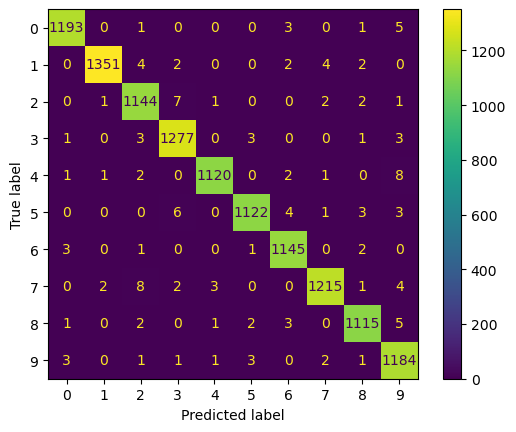

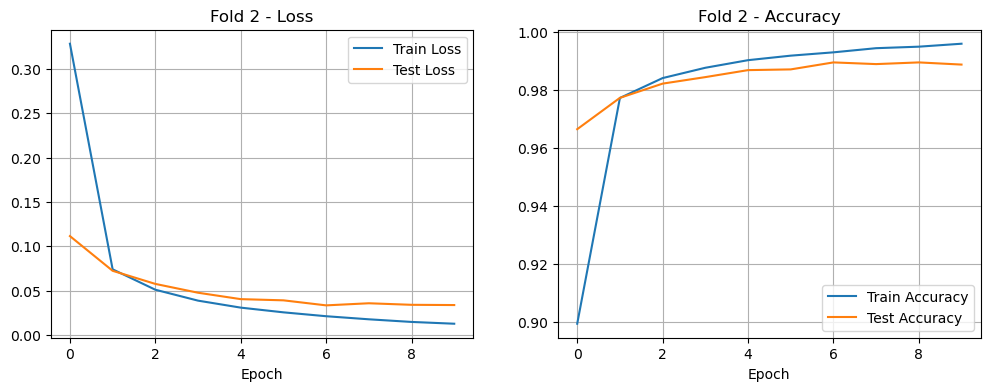

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 0.3186
Test Loss: 0.1011 - Test Accuracy: 96.92%

Epoch [2/10] - Train Loss: 0.0824
Test Loss: 0.0615 - Test Accuracy: 98.14%

Epoch [3/10] - Train Loss: 0.0564
Test Loss: 0.0509 - Test Accuracy: 98.47%

Epoch [4/10] - Train Loss: 0.0429
Test Loss: 0.0367 - Test Accuracy: 99.04%

Epoch [5/10] - Train Loss: 0.0331
Test Loss: 0.0342 - Test Accuracy: 99.02%

Epoch [6/10] - Train Loss: 0.0271
Test Loss: 0.0334 - Test Accuracy: 99.01%

Epoch [7/10] - Train Loss: 0.0228
Test Loss: 0.0352 - Test Accuracy: 98.98%

Epoch [8/10] - Train Loss: 0.0188
Test Loss: 0.0352 - Test Accuracy: 98.97%

Epoch [9/10] - Train Loss: 0.0140
Test Loss: 0.0360 - Test Accuracy: 99.03%

Epoch [10/10] - Train Loss: 0.0138
Test Loss: 0.0290 - Test Accuracy: 99.12%

Recall - Fold 3:
Class 0: Recall = 0.9958
Class 1: Recall = 0.9933
Class 2: Recall = 0.9958
Class 3: Recall = 0.9925
Class 4: Recall = 0.9874
Class 5: Recall = 0.9886
Class 6: Reca

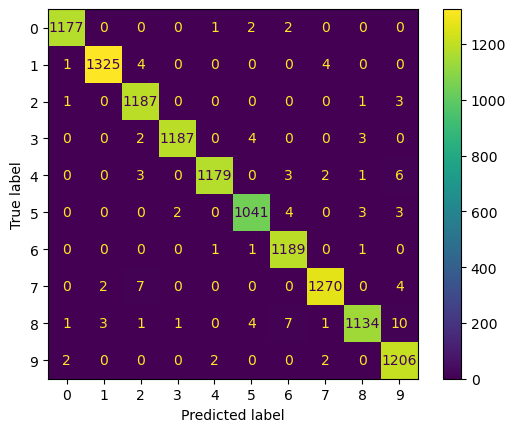

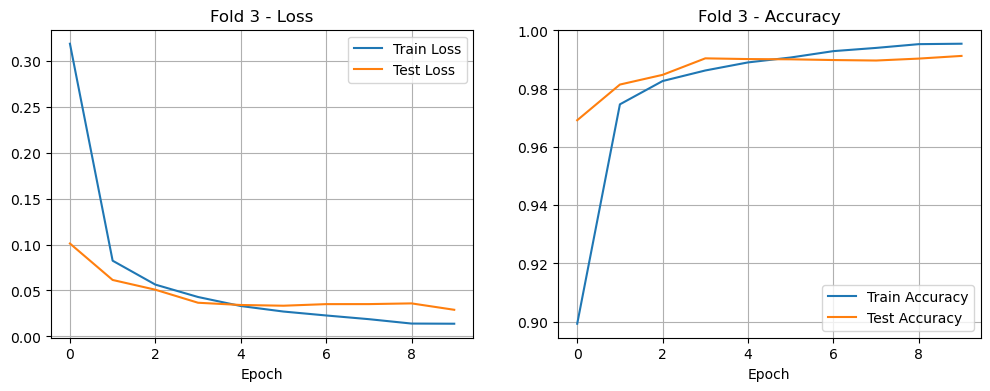

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 0.3339
Test Loss: 0.1091 - Test Accuracy: 96.52%

Epoch [2/10] - Train Loss: 0.0807
Test Loss: 0.0711 - Test Accuracy: 97.86%

Epoch [3/10] - Train Loss: 0.0545
Test Loss: 0.0557 - Test Accuracy: 98.27%

Epoch [4/10] - Train Loss: 0.0414
Test Loss: 0.0536 - Test Accuracy: 98.42%

Epoch [5/10] - Train Loss: 0.0334
Test Loss: 0.0488 - Test Accuracy: 98.60%

Epoch [6/10] - Train Loss: 0.0270
Test Loss: 0.0523 - Test Accuracy: 98.51%

Epoch [7/10] - Train Loss: 0.0218
Test Loss: 0.0399 - Test Accuracy: 98.92%

Epoch [8/10] - Train Loss: 0.0184
Test Loss: 0.0405 - Test Accuracy: 98.89%

Epoch [9/10] - Train Loss: 0.0152
Test Loss: 0.0421 - Test Accuracy: 98.89%

Epoch [10/10] - Train Loss: 0.0139
Test Loss: 0.0411 - Test Accuracy: 98.98%

Recall - Fold 4:
Class 0: Recall = 0.9959
Class 1: Recall = 0.9940
Class 2: Recall = 0.9833
Class 3: Recall = 0.9895
Class 4: Recall = 0.9764
Class 5: Recall = 0.9907
Class 6: Reca

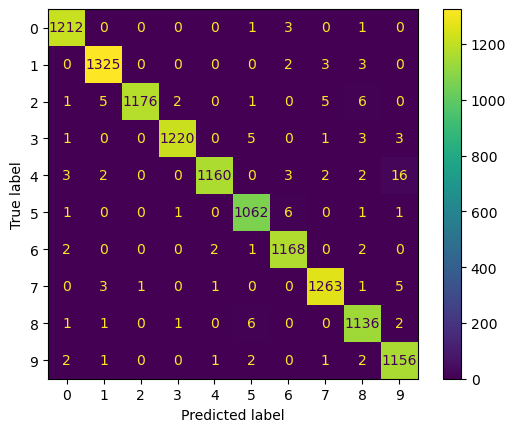

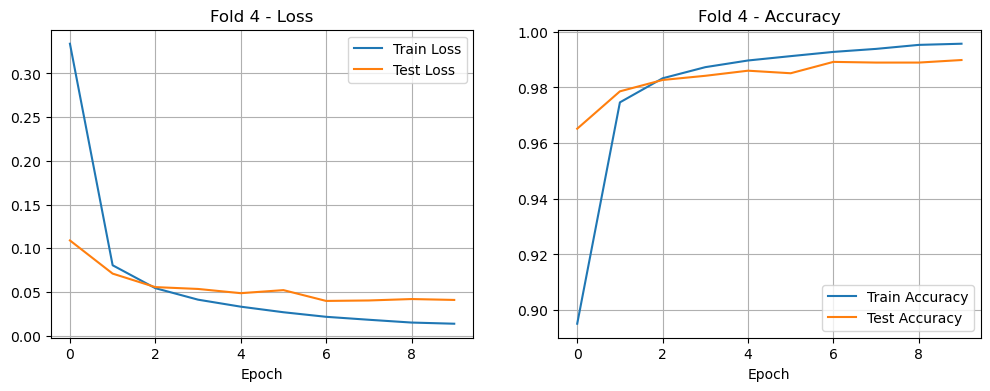

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 0.3012
Test Loss: 0.0969 - Test Accuracy: 97.01%

Epoch [2/10] - Train Loss: 0.0789
Test Loss: 0.0790 - Test Accuracy: 97.52%

Epoch [3/10] - Train Loss: 0.0542
Test Loss: 0.0644 - Test Accuracy: 98.01%

Epoch [4/10] - Train Loss: 0.0412
Test Loss: 0.0465 - Test Accuracy: 98.58%

Epoch [5/10] - Train Loss: 0.0324
Test Loss: 0.0395 - Test Accuracy: 98.87%

Epoch [6/10] - Train Loss: 0.0254
Test Loss: 0.0394 - Test Accuracy: 98.89%

Epoch [7/10] - Train Loss: 0.0211
Test Loss: 0.0448 - Test Accuracy: 98.67%

Epoch [8/10] - Train Loss: 0.0176
Test Loss: 0.0374 - Test Accuracy: 98.91%

Epoch [9/10] - Train Loss: 0.0150
Test Loss: 0.0377 - Test Accuracy: 99.01%

Epoch [10/10] - Train Loss: 0.0121
Test Loss: 0.0350 - Test Accuracy: 98.94%

Recall - Fold 5:
Class 0: Recall = 0.9913
Class 1: Recall = 0.9948
Class 2: Recall = 0.9850
Class 3: Recall = 0.9876
Class 4: Recall = 0.9950
Class 5: Recall = 0.9872
Class 6: Reca

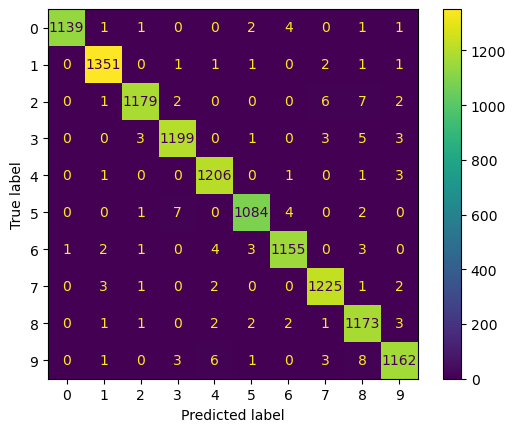

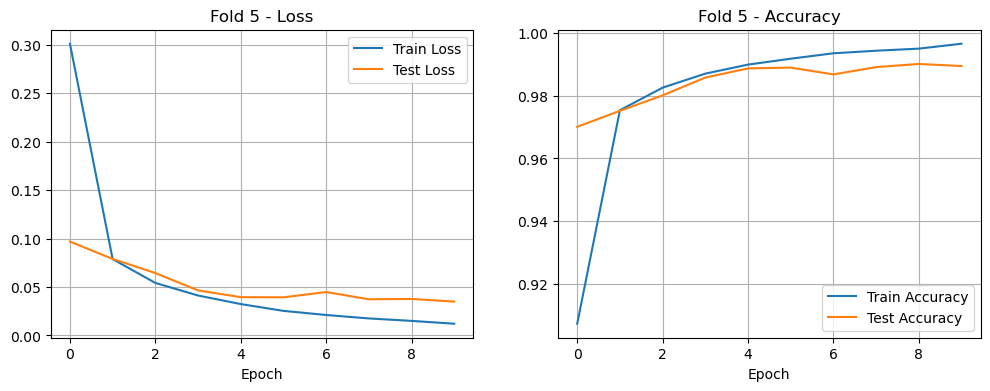

MODELO TERMINADO!!!!
------------------


In [11]:
# testeo del modelo sin dropout
class red_modificada(nn.Module):
    def __init__(self,transforms=None, dropout_prob=0.0): # variable dropout se preocupa de regular las neuronas 
        super(red_modificada,self).__init__()
        
        self.transform = transforms
        self.conv1 = nn.Conv2d(1, 32, 3)   #creamos capas convolucionales 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)  
        self.conv4 = nn.Conv2d(64,128,3)  # añadimos capas
        

        self.fc1 = nn.Linear(1152,256) #41472 caracteristicas esperadas por el modelo 
        self.fc2 = nn.Linear(256,100)
        self.fc3 = nn.Linear(100,10) # capa densa añadida
        

        self.dropout = nn.Dropout(p=dropout_prob) 
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),1))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # Todas las dimensiones excepto la del batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

trainn_loss,trainn_accuracy,testt_loss, testt_accuracy=train_model_kfold2(train_std,trainyy)

En los dos modelo el loss es capaz de llegar por lo bajo de 0.05.
Con el dropout 0.0 se puede observar en las curvas de loss que en ciertas ocasiones
llega hasta un cierto punto y desde ahi se mantiene, es decir, no sigue manteniendo
un aprendizaje, es mas, a veces ocurre un 'cerrito' lo que significa que el error logró
aumentar. Por otro lado, con un dropout en 0.5 su aprendizaje es constante, es decir que 
tiene una dismininucion en la funcion perdida a medida que avanzan sus epocas. Esto indica
que el modelo esta aprendiendo. Ademas, mantiene una estabilidad y no hay presencia constante de 
alguna oscilacion significativa. Es por esto que el early stopping no se aplicó en ninguna parte
del entrenamiento.
Sin dropout se logra registrar un error de 21 veces al predecir la clase 7. Este numero es el mayor respecto
a su propio modelo y a las matrices del modelo con dropout. Las matrices del ultimo modelo mencionado
se puede apreciar una cantidad considerable de ningun error al predecir una clase y si hay presencia de error
sera menor a 10 que es la cantidad mayor de error registrada para predecir la clase 4.

Por lo que se considera un valor de droput 0.5 como mejora para tener un entrenamiento estable y 
tener la menor cantidad de errores 

Por ultimo, se testea un modelo con data augmentation para descubrir si tiene menos errores.

In [4]:
class red_modificada(nn.Module):
    def __init__(self,transforms=None, dropout_prob=0.5): # variable dropout se preocupa de regular las neuronas 
        super(red_modificada,self).__init__()
        
        self.transform = transforms
        self.conv1 = nn.Conv2d(1, 32, 3)   #creamos capas convolucionales 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)  
        self.conv4 = nn.Conv2d(64,128,3)  # añadimos capas
        

        self.fc1 = nn.Linear(1152,256) #41472 caracteristicas esperadas por el modelo 
        self.fc2 = nn.Linear(256,100)
        self.fc3 = nn.Linear(100,10) # capa densa añadida
        

        self.dropout = nn.Dropout(p=dropout_prob) 
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),1))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # Todas las dimensiones excepto la del batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [5]:
transformm = transforms.Compose([  # aplicar data augmentation fue una opcion para poder realizar la tarea
    transforms.ToPILImage(),       # sin embargo, no mejoraba los parametros recalls y f1 
    transforms.RandomRotation(degrees=(-20, 20)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [6]:
def show_images(images, labels): # funcion adicional para poder ver las transformaciones de las imagenes y la normalizacion 
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 3))
    for i in range(num_images):
        axes[i].imshow(np.transpose(images[i], (1, 2, 0)))  # Reorganiza las dimensiones de la imagen
        axes[i].set_title(f"{labels[i]}")
        axes[i].axis('off')
    plt.show()

In [11]:
def train_model_kfold2(trainx, trainy,patience=3,n_folds=5):
    scores, histories, recalls = list(), list(), list()
    
    batch_size = 32
    learning_rate = 0.0001
    num_epochs = 10
   
    # objeto para dividir los datos en n pliegues 
    kfold = KFold(n_splits=n_folds, shuffle=True)

    # itera a través de los pliegues de validación cruzada
    for fold, (train_indices, test_indices) in enumerate(kfold.split(trainx)):
        print(f"Fold {fold + 1}/{n_folds}")
        
        # aqui se divide los datos en conjuntos de entrenamiento y prueba para el fold respectivo 
        train_data, test_data = trainx[train_indices], trainx[test_indices]
        train_labels, test_labels = trainy[train_indices], trainy[test_indices]

        # Crea dataloaders para entrenamiento y prueba para el fold respectivo 
        train_loader = torch.utils.data.DataLoader(dataset=CustomDataset(train_data, train_labels,transforms=transformm), batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=CustomDataset(test_data, test_labels,transforms=transformm), batch_size=batch_size, shuffle=False)

        # Inicializa el modelo y el optimizador
        model = red_modificada().to('cuda') # modelo en la gpu 
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        aux1 = [] # lista para obtener los errores del train
        aux2 = [] # lista para obtener los errores del test 

        aux3 = [] # lista para obtener accuracy del data train 
        aux4 = [] # lista para obtener accuracy del data test 

        best_val_loss=2
        # Entrena el modelo
        for epoch in range(num_epochs):
            train_loss, train_accuracy = train(model, train_loader, criterion, optimizer) # en este momento se entrena el modelo por epocas 
            aux1.append(train_loss) # lista de errores en data train
            aux3.append(train_accuracy) # lista de accuracy en data train
            print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

            # Evalúa el modelo en el conjunto de prueba
            test_loss, test_accuracy = evaluate(model, test_loader, criterion)# se llama a la funcion para evaluar el modelo y obtener el error y accuracy por epocas
            print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2%}\n")
            aux2.append(test_loss) # lista para obtener los errores del data test 
            
            aux4.append(test_accuracy) # lista de accuracy en data test 
            data_iterator = iter(train_loader)
            images, labels = next(data_iterator)

            # Llama a la función show_images para mostrar las imágenes
            show_images(images, labels)
            #implemento early stopping 
            if test_loss < best_val_loss: #comparacion simple de variables
                best_val_loss = test_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
                
            if no_improvement_count >= patience:
                print(f"Early stopping en fold {fold + 1}, epoch {epoch + 1}")
                break
        
        y_true = test_labels # variables true reales 
        y_pred = predict(model, test_loader)   # prediccion del modelo         
        report = classification_report(y_true, y_pred, output_dict=True)
        #Calcular y mostrar el recall
        print(f'Recall - Fold {fold + 1}:')
        for class_name, recall_value in report.items(): # itero la variable de recall en report.items()
            if class_name.isdigit():
                print(f'Class {class_name}: Recall = {recall_value["recall"]:.4f}')

        # calcular y mostrar valores F1 
        print(f'Valor F1 - Fold {fold + 1}:')
        for class_name, f1_value in report.items():
            if class_name.isdigit():
                print(f'Class {class_name}: F1-Score = {f1_value["f1-score"]:.4f}')

        
     

       
        recalls.append(report)  # Almacena el reporte de clasificación
        confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
        cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = None)
        cm_display.plot()
        plt.show()

        visualization_curves(aux1,aux3,aux2,aux4,fold)  

        print("MODELO TERMINADO!!!!")
        print('------------------')
        
      
       
    
    return aux1,aux3,aux2,aux4 # loss-train, accuracy-train, loss-test, accuracy-test

In [8]:
def estandarizacion(train, test):
    # Calcula la media y la desviación estándar de los datos de entrenamiento
    mean = torch.mean(train)
    std = torch.std(train)

    # Aplica la estandarización a los datos de entrenamiento y prueba
    train_std = (train - mean) / std
    test_std = (test - mean) / std

    return train_std, test_std

trainxx, trainyy, testxx, testyy = load_dataset() # cargo los datos 
train_std , test_std = estandarizacion(trainxx, testxx) # aplicamos la normalizacion de datos 

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])


Fold 1/5
Epoch [1/10] - Train Loss: 1.0945
Test Loss: 0.5586 - Test Accuracy: 81.49%



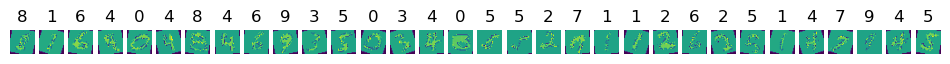

Epoch [2/10] - Train Loss: 0.5429
Test Loss: 0.3901 - Test Accuracy: 86.88%



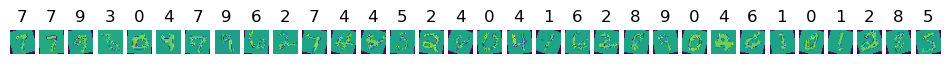

Epoch [3/10] - Train Loss: 0.4092
Test Loss: 0.3129 - Test Accuracy: 89.62%



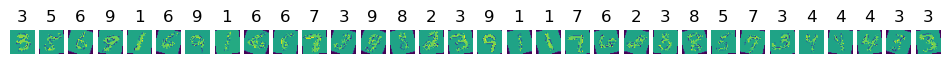

Epoch [4/10] - Train Loss: 0.3335
Test Loss: 0.2731 - Test Accuracy: 90.81%



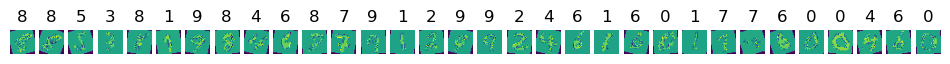

Epoch [5/10] - Train Loss: 0.2786
Test Loss: 0.2151 - Test Accuracy: 92.73%



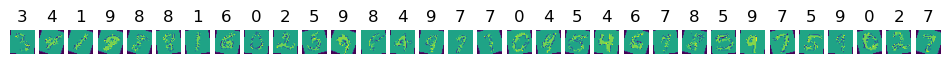

Epoch [6/10] - Train Loss: 0.2475
Test Loss: 0.2169 - Test Accuracy: 92.88%



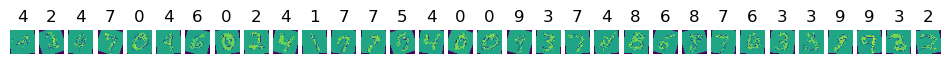

Epoch [7/10] - Train Loss: 0.2184
Test Loss: 0.1743 - Test Accuracy: 94.32%



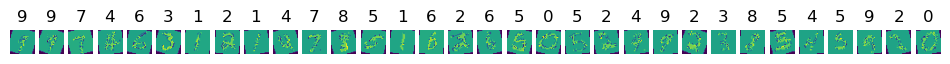

Epoch [8/10] - Train Loss: 0.1989
Test Loss: 0.1537 - Test Accuracy: 94.83%



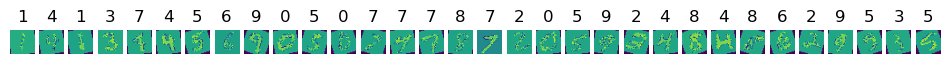

Epoch [9/10] - Train Loss: 0.1833
Test Loss: 0.1359 - Test Accuracy: 95.62%



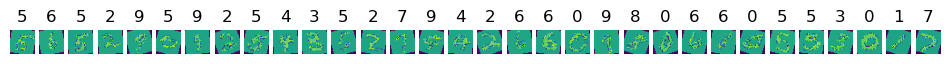

Epoch [10/10] - Train Loss: 0.1702
Test Loss: 0.1300 - Test Accuracy: 95.71%



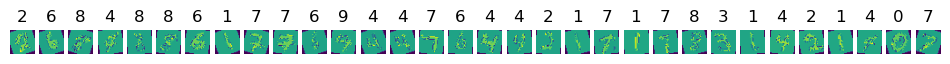

Recall - Fold 1:
Class 0: Recall = 0.9783
Class 1: Recall = 0.9762
Class 2: Recall = 0.9711
Class 3: Recall = 0.9571
Class 4: Recall = 0.9407
Class 5: Recall = 0.9384
Class 6: Recall = 0.9609
Class 7: Recall = 0.9510
Class 8: Recall = 0.9460
Class 9: Recall = 0.9355
Valor F1 - Fold 1:
Class 0: F1-Score = 0.9795
Class 1: F1-Score = 0.9835
Class 2: F1-Score = 0.9592
Class 3: F1-Score = 0.9456
Class 4: F1-Score = 0.9444
Class 5: F1-Score = 0.9496
Class 6: F1-Score = 0.9676
Class 7: F1-Score = 0.9604
Class 8: F1-Score = 0.9403
Class 9: F1-Score = 0.9257


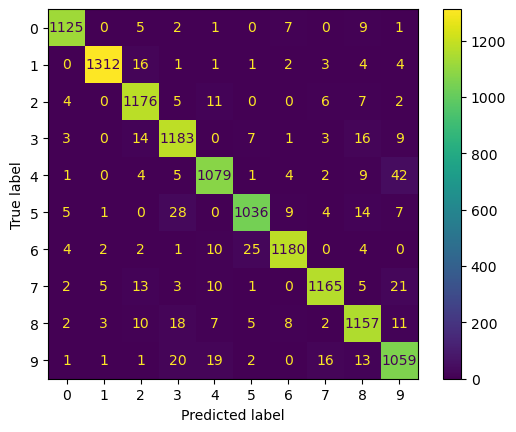

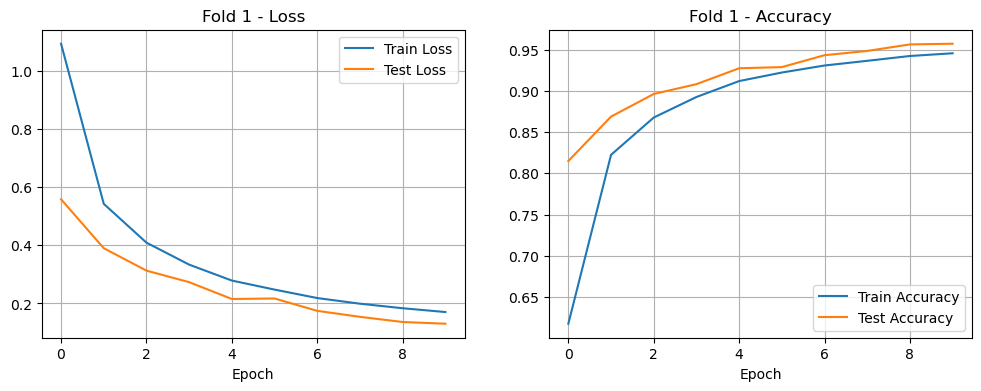

MODELO TERMINADO!!!!
------------------
Fold 2/5
Epoch [1/10] - Train Loss: 1.1711
Test Loss: 0.5774 - Test Accuracy: 81.12%



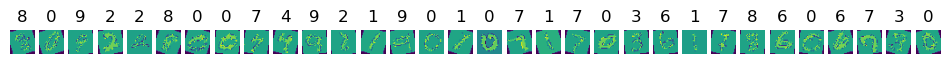

Epoch [2/10] - Train Loss: 0.5950
Test Loss: 0.4381 - Test Accuracy: 85.48%



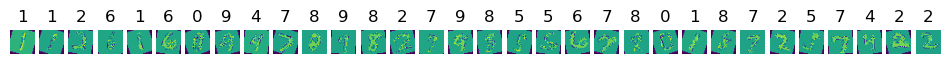

Epoch [3/10] - Train Loss: 0.4648
Test Loss: 0.3467 - Test Accuracy: 88.55%



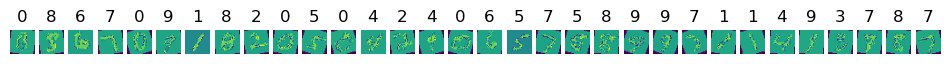

Epoch [4/10] - Train Loss: 0.3781
Test Loss: 0.2954 - Test Accuracy: 90.31%



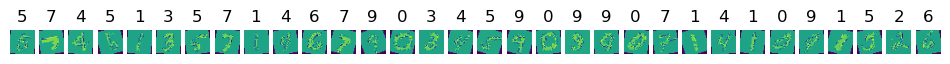

Epoch [5/10] - Train Loss: 0.3188
Test Loss: 0.2439 - Test Accuracy: 92.05%



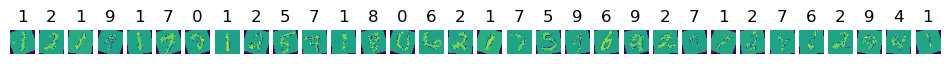

Epoch [6/10] - Train Loss: 0.2754
Test Loss: 0.2034 - Test Accuracy: 93.51%



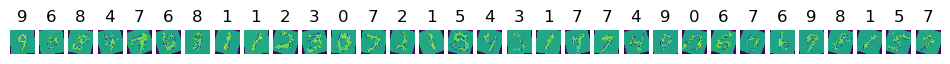

Epoch [7/10] - Train Loss: 0.2417
Test Loss: 0.1868 - Test Accuracy: 94.03%



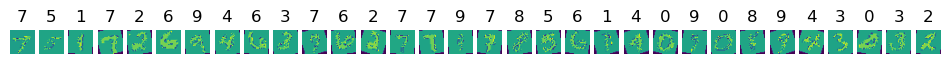

Epoch [8/10] - Train Loss: 0.2161
Test Loss: 0.1854 - Test Accuracy: 94.08%



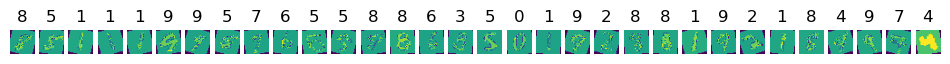

Epoch [9/10] - Train Loss: 0.1977
Test Loss: 0.1574 - Test Accuracy: 95.12%



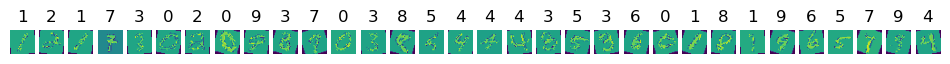

Epoch [10/10] - Train Loss: 0.1804
Test Loss: 0.1564 - Test Accuracy: 94.94%



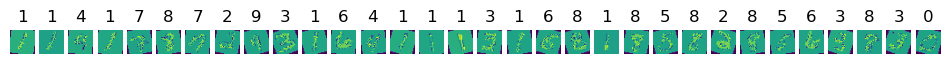

Recall - Fold 2:
Class 0: Recall = 0.9626
Class 1: Recall = 0.9832
Class 2: Recall = 0.9416
Class 3: Recall = 0.9444
Class 4: Recall = 0.9305
Class 5: Recall = 0.9634
Class 6: Recall = 0.9461
Class 7: Recall = 0.9528
Class 8: Recall = 0.9225
Class 9: Recall = 0.9247
Valor F1 - Fold 2:
Class 0: F1-Score = 0.9738
Class 1: F1-Score = 0.9818
Class 2: F1-Score = 0.9520
Class 3: F1-Score = 0.9313
Class 4: F1-Score = 0.9518
Class 5: F1-Score = 0.9269
Class 6: F1-Score = 0.9668
Class 7: F1-Score = 0.9445
Class 8: F1-Score = 0.9212
Class 9: F1-Score = 0.9210


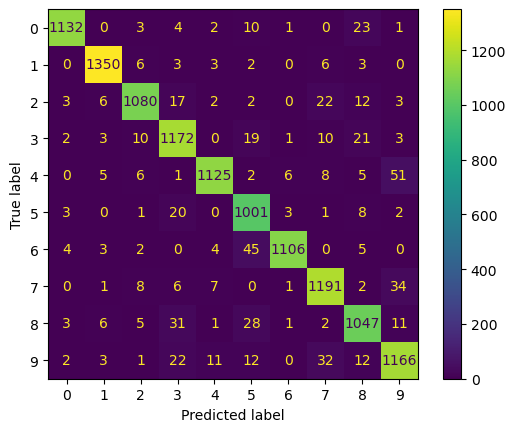

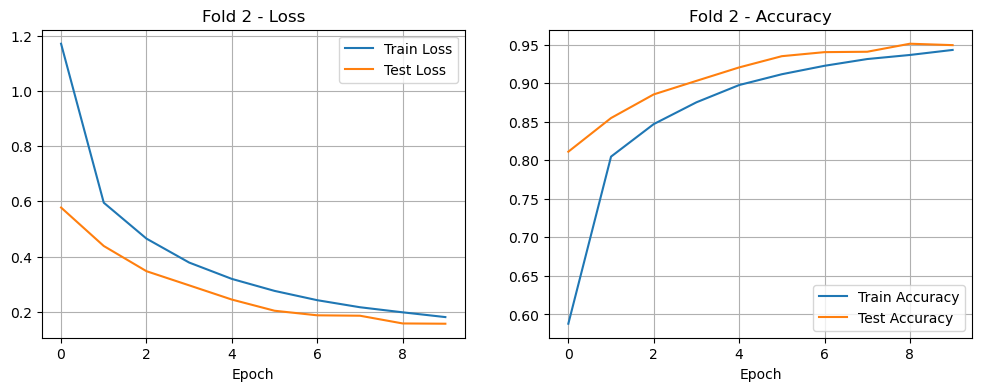

MODELO TERMINADO!!!!
------------------
Fold 3/5
Epoch [1/10] - Train Loss: 1.2030
Test Loss: 0.6563 - Test Accuracy: 78.46%



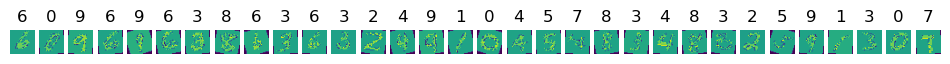

Epoch [2/10] - Train Loss: 0.6108
Test Loss: 0.4573 - Test Accuracy: 84.87%



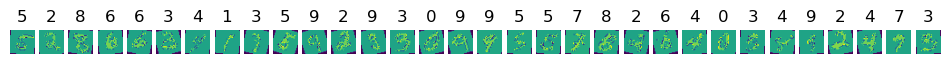

Epoch [3/10] - Train Loss: 0.4773
Test Loss: 0.3532 - Test Accuracy: 88.32%



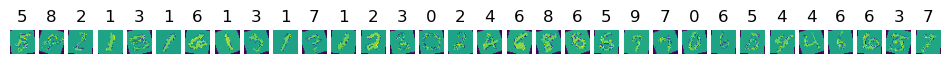

Epoch [4/10] - Train Loss: 0.3874
Test Loss: 0.2953 - Test Accuracy: 90.09%



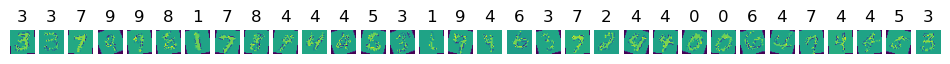

Epoch [5/10] - Train Loss: 0.3267
Test Loss: 0.2451 - Test Accuracy: 92.02%



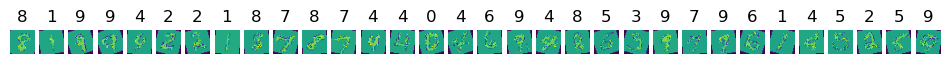

Epoch [6/10] - Train Loss: 0.2776
Test Loss: 0.2135 - Test Accuracy: 92.98%



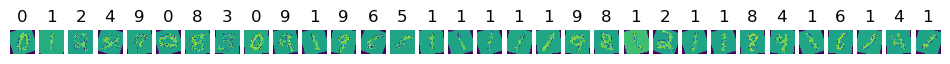

Epoch [7/10] - Train Loss: 0.2401
Test Loss: 0.1910 - Test Accuracy: 93.93%



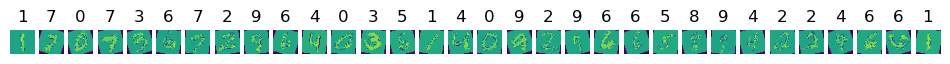

Epoch [8/10] - Train Loss: 0.2138
Test Loss: 0.1673 - Test Accuracy: 94.61%



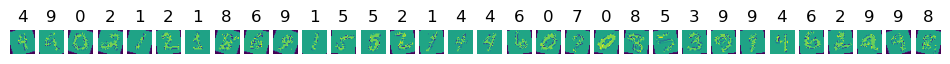

Epoch [9/10] - Train Loss: 0.1949
Test Loss: 0.1554 - Test Accuracy: 95.03%



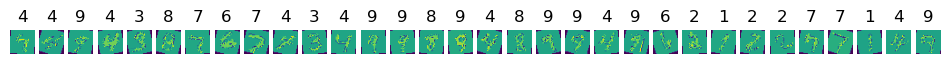

Epoch [10/10] - Train Loss: 0.1795
Test Loss: 0.1536 - Test Accuracy: 94.97%



Recall - Fold 3:
Class 0: Recall = 0.9805
Class 1: Recall = 0.9719
Class 2: Recall = 0.9639
Class 3: Recall = 0.9465
Class 4: Recall = 0.9560
Class 5: Recall = 0.9410
Class 6: Recall = 0.9569
Class 7: Recall = 0.9487
Class 8: Recall = 0.9462
Class 9: Recall = 0.9154
Valor F1 - Fold 3:
Class 0: F1-Score = 0.9788
Class 1: F1-Score = 0.9824
Class 2: F1-Score = 0.9515
Class 3: F1-Score = 0.9354
Class 4: F1-Score = 0.9508
Class 5: F1-Score = 0.9402
Class 6: F1-Score = 0.9673
Class 7: F1-Score = 0.9561
Class 8: F1-Score = 0.9394
Class 9: F1-Score = 0.9242


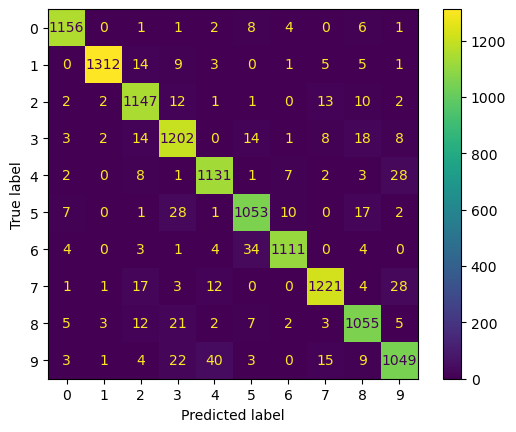

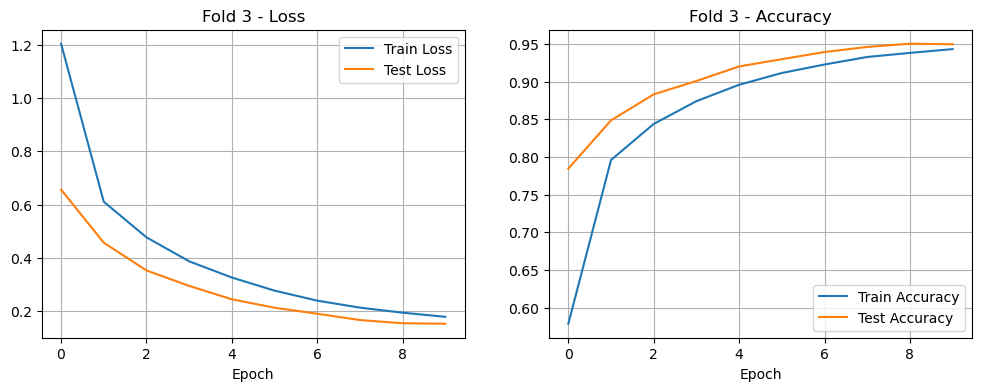

MODELO TERMINADO!!!!
------------------
Fold 4/5
Epoch [1/10] - Train Loss: 1.1368
Test Loss: 0.6114 - Test Accuracy: 78.92%



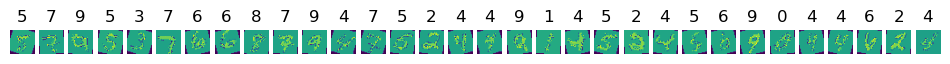

Epoch [2/10] - Train Loss: 0.5809
Test Loss: 0.4146 - Test Accuracy: 86.17%



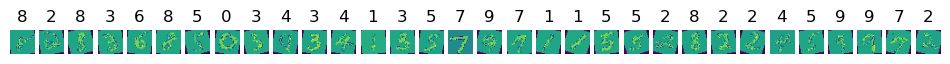

Epoch [3/10] - Train Loss: 0.4474
Test Loss: 0.3434 - Test Accuracy: 88.38%



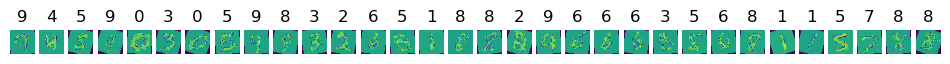

Epoch [4/10] - Train Loss: 0.3675
Test Loss: 0.2775 - Test Accuracy: 91.01%



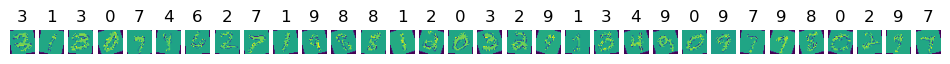

Epoch [5/10] - Train Loss: 0.3100
Test Loss: 0.2464 - Test Accuracy: 91.84%



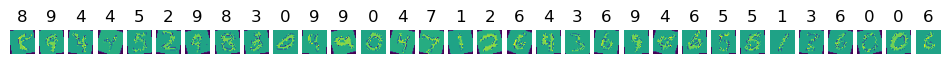

Epoch [6/10] - Train Loss: 0.2649
Test Loss: 0.2045 - Test Accuracy: 93.38%



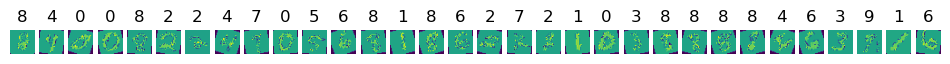

Epoch [7/10] - Train Loss: 0.2328
Test Loss: 0.1914 - Test Accuracy: 93.68%



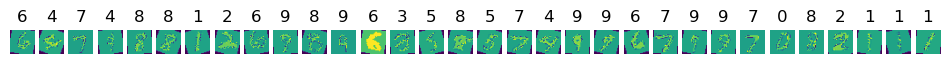

Epoch [8/10] - Train Loss: 0.2111
Test Loss: 0.1804 - Test Accuracy: 94.03%



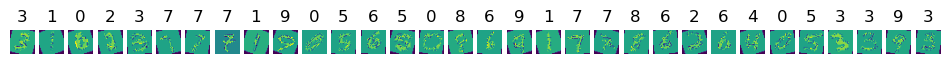

Epoch [9/10] - Train Loss: 0.1936
Test Loss: 0.1609 - Test Accuracy: 94.65%



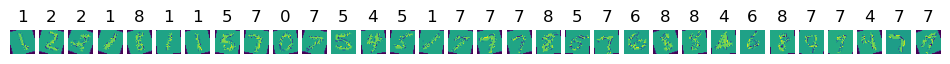

Epoch [10/10] - Train Loss: 0.1790
Test Loss: 0.1570 - Test Accuracy: 94.75%



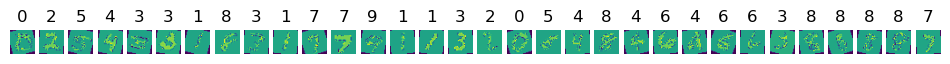

Recall - Fold 4:
Class 0: Recall = 0.9796
Class 1: Recall = 0.9838
Class 2: Recall = 0.9723
Class 3: Recall = 0.9400
Class 4: Recall = 0.9294
Class 5: Recall = 0.9394
Class 6: Recall = 0.9730
Class 7: Recall = 0.9429
Class 8: Recall = 0.8810
Class 9: Recall = 0.9350
Valor F1 - Fold 4:
Class 0: F1-Score = 0.9800
Class 1: F1-Score = 0.9812
Class 2: F1-Score = 0.9442
Class 3: F1-Score = 0.9171
Class 4: F1-Score = 0.9463
Class 5: F1-Score = 0.9381
Class 6: F1-Score = 0.9751
Class 7: F1-Score = 0.9530
Class 8: F1-Score = 0.9166
Class 9: F1-Score = 0.9264


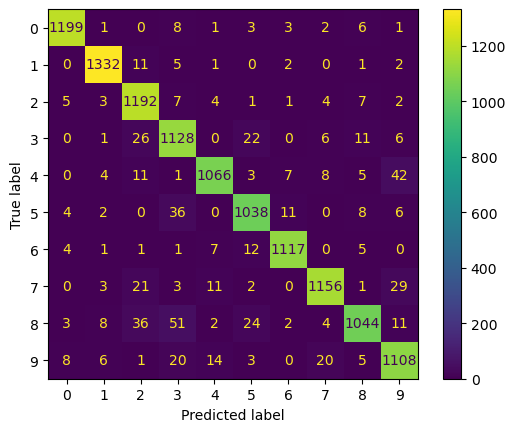

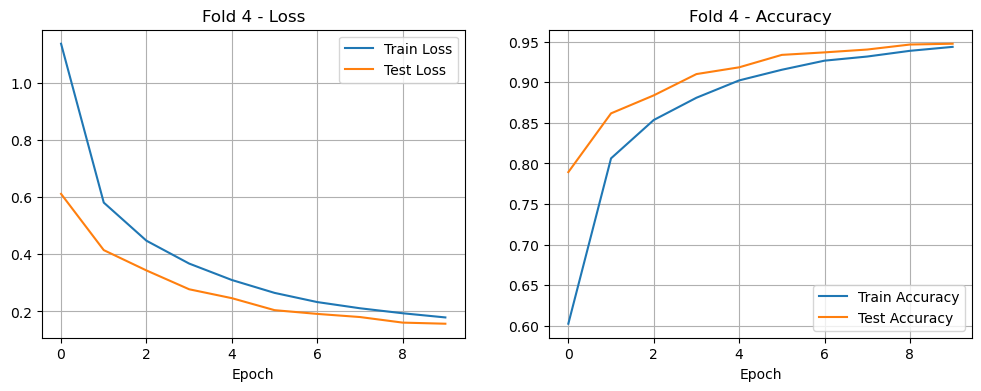

MODELO TERMINADO!!!!
------------------
Fold 5/5
Epoch [1/10] - Train Loss: 1.1123
Test Loss: 0.5642 - Test Accuracy: 81.18%



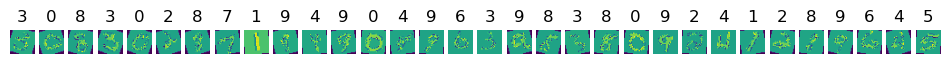

Epoch [2/10] - Train Loss: 0.5761
Test Loss: 0.4085 - Test Accuracy: 86.16%



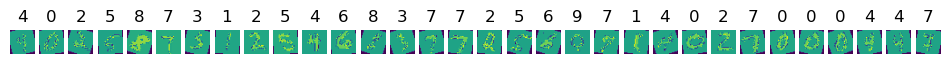

Epoch [3/10] - Train Loss: 0.4556
Test Loss: 0.3340 - Test Accuracy: 88.82%



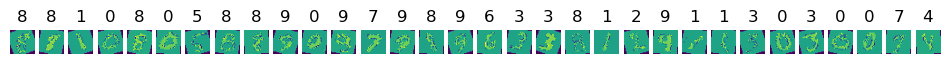

Epoch [4/10] - Train Loss: 0.3778
Test Loss: 0.2759 - Test Accuracy: 90.74%



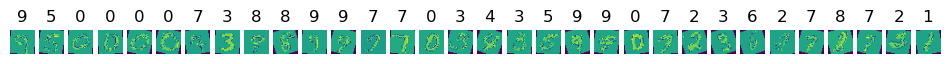

Epoch [5/10] - Train Loss: 0.3210
Test Loss: 0.2441 - Test Accuracy: 91.91%



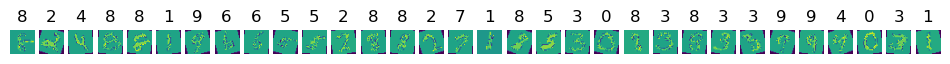

Epoch [6/10] - Train Loss: 0.2821
Test Loss: 0.2114 - Test Accuracy: 92.72%



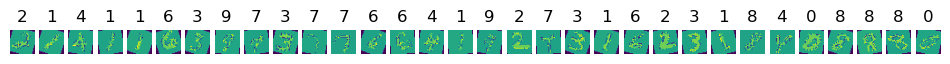

Epoch [7/10] - Train Loss: 0.2511
Test Loss: 0.1864 - Test Accuracy: 94.00%



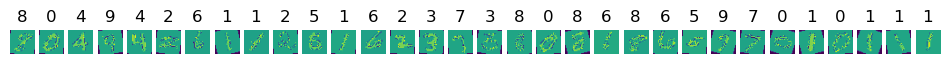

Epoch [8/10] - Train Loss: 0.2273
Test Loss: 0.1754 - Test Accuracy: 94.28%



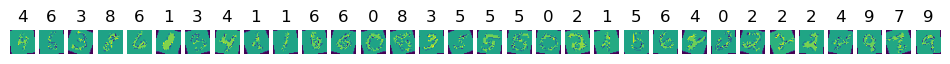

Epoch [9/10] - Train Loss: 0.2061
Test Loss: 0.1588 - Test Accuracy: 94.68%



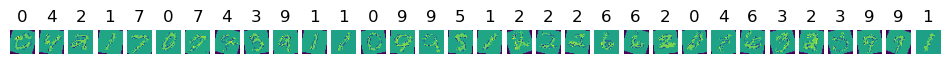

Epoch [10/10] - Train Loss: 0.1879
Test Loss: 0.1419 - Test Accuracy: 95.23%



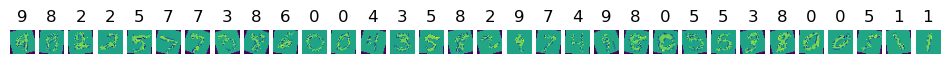

Recall - Fold 5:
Class 0: Recall = 0.9866
Class 1: Recall = 0.9811
Class 2: Recall = 0.9611
Class 3: Recall = 0.9265
Class 4: Recall = 0.9455
Class 5: Recall = 0.9279
Class 6: Recall = 0.9728
Class 7: Recall = 0.9491
Class 8: Recall = 0.9396
Class 9: Recall = 0.9355
Valor F1 - Fold 5:
Class 0: F1-Score = 0.9829
Class 1: F1-Score = 0.9800
Class 2: F1-Score = 0.9523
Class 3: F1-Score = 0.9360
Class 4: F1-Score = 0.9443
Class 5: F1-Score = 0.9486
Class 6: F1-Score = 0.9660
Class 7: F1-Score = 0.9495
Class 8: F1-Score = 0.9385
Class 9: F1-Score = 0.9302


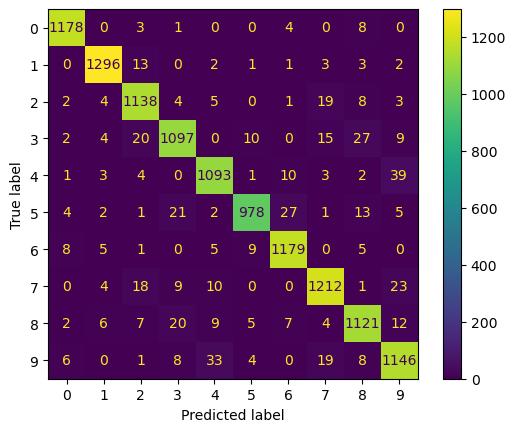

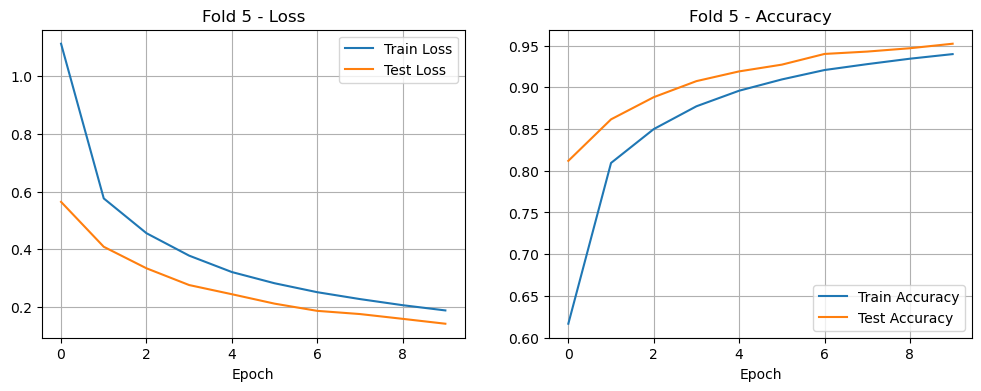

MODELO TERMINADO!!!!
------------------


In [12]:
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy=train_model_kfold2(train_std,trainyy)

En conclusion, para mejorar el modelo base hay que experimentar valores del learning_rate 
para encontrar el valor mas adecuado para poder tener un entrenamiento efectivo -sin overfitting-, 
y tambien obsverar una convergencia mas proxima. 
Estos casos se han experimentado en un algoritmo de gridsearch obteniendo valores bastante particulares.
El algoritmo me recomienda usar un valor de 0.001 con una precisión promedio: 0.98, sin embargo, las curvas
de entrenamiento indican una alta probabilidad de tener un entrenamiento con overfitting,
mientras que por otro lado, usando el valor lr=0.0001 las curvas de entrenamiento muestran un progreso suave
y constante a lo largo del proceso, es decir, que la funcion perdida disminuye de manera constate a medida 
que avanzan las epocas, lo cual es un indicio que el modelo esta mejorando para obtener mejores predicciones.
Ademas, la perdida demuestra estabilidad y comienza a converger hacia un valor minimo. Esto Significa que 
el modelo se esta ajustando a los datos de entrenamiento sin sobreajustar. 
Usando lr=0.0001 hay un aumento en la precision y ademas tiene una convergencia temprana, maximo 10 epocas.

En la experimentacion de pre procesamiento de las imagenes se puede observar que tiene un gran impacto en las 
predicciones. Esto se puede ver en las distintas graficas que estan a su disposicion en el excel, notando que
con una normalizacion de [-1,1] a pesar de tener buenos recalls no es tan estable en f1-score, ademas, tiene
mayores errores en las predicciones de las clases -matriz de confusion en el excel- lo cual no nos conviene 
irnos por aquel camino. Respecto a sus curvas de entrenamiento mantienen una gran brecha de distncia entre
los data train-test identificando a temprana vista que podria tener un posible overfitting.
Por otro lado, con la normalizacion centrada se tienen las mismas observaciones. Al modelo le cuesta reconocer
las clases correctas, teniendo asi grandes valores de errores en las predicciones. En sus graficas el overfitting
es mas notorio, observando 'cerritos' que dificultan el entrenamiento.
Por ultimo con la normalizacion estandarizada se puede observar resultados mas solidos respectoa recalls y
f1-score. Sus datos son mas estables en ambos graficos, ademas, los numeros de errores es mucho menor en 
comparacion a las demas normalizaciones. Respecto a sus graficas tambien se puede observar un overfitting 
con la salvedad de que se ve mas 'tratable' porque en sus curvas no hay tanta presencia de 'peak' o 'cerrito'
de errores.

La adicion de capas convolucionales y densas mejoro el rendimiento del modelo porque es capaz de aprender
caracteristicas de mayor nivel y abstracciones mas complejas, ademas de, bordes, texturas y patrones simples.
Con la implementacion de maxpooling podemos reducir la dimensionalidad de los datos al retener solo las
caracteristicas mas importantes. Esto no solo reduce la cantidad de parámetros en el modelo, lo que facilita 
el entrenamiento, sino que también aumenta la invariancia a las pequeñas variaciones en la posición de las 
características en la imagen.

Las capas densas en la parte final del modelo pueden combinar y agrupar las características
aprendidas en las capas de convolución para realizar tareas de clasificación y toma de decisiones. Estas capas permiten
al modelo realizar inferencias basadas en las características extraídas.

Al aumentar la profundidad y la complejidad del modelo mediante la adición de capas, el modelo puede 
aprender patrones más sofisticados en los datos. Al final de todo se puede ver una mejora despues 
de implementar estas adiciones de capas.

Por utlimo, para mejorar el modelo base hay que ajustar el lr a 0.0001 para poder tener un entrenamiento mas efectivo,
luego, añadir tecnicas de regularizacion como el dropout para poder evitar y mejorar el overfitting - lo cual fue efectivo -.
Experimentar con distintas normalizaciones, lo cual, en este caso fue elegida la estandarizacion.
Añadir mas capas convolucionales y densas al modelo pero no en exceso, porque podria ocurrir que el modelo
tenga que procesar muchos parametros lo que impactaria en el tiempo de entrenamiento. - Añadir muchas capas 
no signfica que se tendra una mejor prediccion -. Añadir un data augmentation no fue efectivo, dado que en las curvas
de entrenamiento muestra algo inusual que corresponde a que en los graficos loss, el data test tiene menor error al del train
y eso no puede pasar. Seria ilogico que en el test tenga menos error que en el data donde se estan entrenando las imagenes.
Pasa lo mismo con las curvas accuracy, ademas de tener una cantidad de errores muy grande en las predicciones - ver matrices -.

In [4]:
import pandas as pd
def train_final(trainx, trainy,patience=3,n_folds=5):
    # scores, histories, recalls = list(), list(), list()
    
    batch_size = 32
    learning_rate = 0.0001
    num_epochs = 10
   
    train_data, test_data, train_labels, test_labels = train_test_split(trainx, trainy, test_size=0.2)
    
    train_loader = torch.utils.data.DataLoader(dataset=CustomDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=CustomDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)
    model = red_modificada().to('cuda') # modelo en la gpu 
        
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    aux1 = [] # lista para obtener los errores del train
    aux2 = [] # lista para obtener los errores del test 

    aux3 = [] # lista para obtener accuracy del data train 
    aux4 = [] # lista para obtener accuracy del data test 

    best_val_loss=2
    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer) # en este momento se entrena el modelo por epocas 
        aux1.append(train_loss) # lista de errores en data train
        aux3.append(train_accuracy) # lista de accuracy en data train
        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

        # Evalúa el modelo en el conjunto de prueba
        test_loss, test_accuracy = evaluate(model, test_loader, criterion)# se llama a la funcion para evaluar el modelo y obtener el error y accuracy por epocas
        print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2%}\n")
        aux2.append(test_loss) # lista para obtener los errores del data test 
            
        aux4.append(test_accuracy) # lista de accuracy en data test 
            
        #implemento early stopping 
        if test_loss < best_val_loss: #comparacion simple de variables
            best_val_loss = test_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1
                
        if no_improvement_count >= patience:
            print(f"Early stopping en fold {fold + 1}, epoch {epoch + 1}")
            break

    y_true = test_labels # variables true reales 
    y_pred = predict(model, test_loader)   # prediccion del modelo 
    results_df = pd.DataFrame({
    'Etiqueta Real': y_true,
    'Predicción': y_pred
    })        
    csv_filename = 'resultados_predicciones.csv'
    results_df.to_csv(csv_filename, index=False)
    report = classification_report(y_true, y_pred, output_dict=True)
    #Calcular y mostrar el recall
    print(f'Recall:')
    for class_name, recall_value in report.items(): # itero la variable de recall en report.items()
        if class_name.isdigit():
            print(f'Class {class_name}: Recall = {recall_value["recall"]:.4f}')

    # calcular y mostrar valores F1 
    print(f'Valor F1:')
    for class_name, f1_value in report.items():
        if class_name.isdigit():
            print(f'Class {class_name}: F1-Score = {f1_value["f1-score"]:.4f}')

        
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = None)
    cm_display.plot()
    plt.show()

    visualization_curves(aux1,aux3,aux2,aux4,0)  

    print("MODELO TERMINADO!!!!")
    print('------------------')
        
      
       
    
    return aux1,aux3,aux2,aux4 # loss-train, accuracy-train, loss-test, accuracy-test


In [5]:
class red_modificada(nn.Module):
    def __init__(self,transforms=None, dropout_prob=0.5): # variable dropout se preocupa de regular las neuronas 
        super(red_modificada,self).__init__()
        
        self.transform = transforms
        self.conv1 = nn.Conv2d(1, 32, 3)   #creamos capas convolucionales 
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)  
        self.conv4 = nn.Conv2d(64,128,3)  # añadimos capas
        

        self.fc1 = nn.Linear(1152,256) #41472 caracteristicas esperadas por el modelo 
        self.fc2 = nn.Linear(256,100)
        self.fc3 = nn.Linear(100,10) # capa densa añadida
        

        self.dropout = nn.Dropout(p=dropout_prob) 
    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x),1))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = F.relu(self.conv4(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # Todas las dimensiones excepto la del batch
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
def estandarizacion(train, test):
    # Calcula la media y la desviación estándar de los datos de entrenamiento
    mean = torch.mean(train)
    std = torch.std(train)

    # Aplica la estandarización a los datos de entrenamiento y prueba
    train_std = (train - mean) / std
    test_std = (test - mean) / std

    return train_std, test_std

trainxx, trainyy, testxx, testyy = load_dataset() # cargo los datos 
train_std , test_std = estandarizacion(trainxx, testxx) # aplicamos la normalizacion de datos 

Dimensiones de trainX: torch.Size([60000, 1, 28, 28])
Dimensiones de trainY: torch.Size([60000])
Dimensiones de testX: torch.Size([10000, 1, 28, 28])
Dimensiones de testY: torch.Size([10000])


Epoch [1/10] - Train Loss: 0.4151
Test Loss: 0.0986 - Test Accuracy: 96.98%

Epoch [2/10] - Train Loss: 0.1076
Test Loss: 0.0785 - Test Accuracy: 97.52%

Epoch [3/10] - Train Loss: 0.0749
Test Loss: 0.0535 - Test Accuracy: 98.32%

Epoch [4/10] - Train Loss: 0.0604
Test Loss: 0.0497 - Test Accuracy: 98.52%

Epoch [5/10] - Train Loss: 0.0479
Test Loss: 0.0454 - Test Accuracy: 98.76%

Epoch [6/10] - Train Loss: 0.0405
Test Loss: 0.0437 - Test Accuracy: 98.84%

Epoch [7/10] - Train Loss: 0.0347
Test Loss: 0.0395 - Test Accuracy: 98.88%

Epoch [8/10] - Train Loss: 0.0309
Test Loss: 0.0398 - Test Accuracy: 98.91%

Epoch [9/10] - Train Loss: 0.0272
Test Loss: 0.0387 - Test Accuracy: 98.96%

Epoch [10/10] - Train Loss: 0.0233
Test Loss: 0.0344 - Test Accuracy: 99.02%

Recall:
Class 0: Recall = 0.9950
Class 1: Recall = 0.9919
Class 2: Recall = 0.9924
Class 3: Recall = 0.9877
Class 4: Recall = 0.9889
Class 5: Recall = 0.9936
Class 6: Recall = 0.9921
Class 7: Recall = 0.9898
Class 8: Recall = 0.9

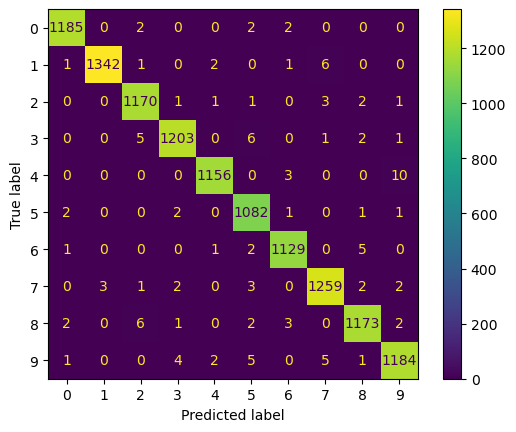

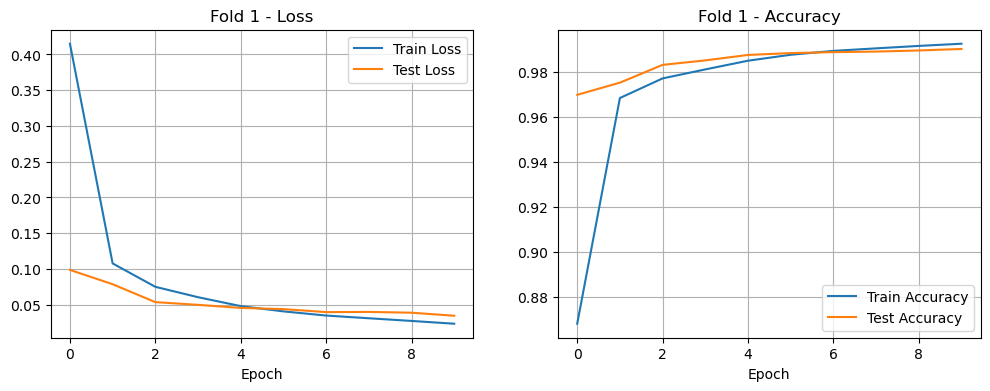

MODELO TERMINADO!!!!
------------------


In [7]:
trainn_loss,trainn_accuracy,testt_loss, testt_accuracy=train_final(train_std,trainyy)

In [8]:
df = pd.read_csv("resultados_predicciones.csv")
df

Etiqueta Real  Predicción
0                  9           9
1                  5           5
2                  6           6
3                  8           8
4                  9           9
...              ...         ...
11995              3           3
11996              5           5
11997              6           6
11998              7           7
11999              5           5

[12000 rows x 2 columns]